In [1]:
import pandas as pd
import os
import ast
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import json
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from model import MoleculeACEDataset
from preprocessing import get_cliff_groups_test

# Preprocessing

In [2]:
df_test = pd.read_csv("../data/df_test.csv")
group_dict = get_cliff_groups_test(path_to_test="../data/df_test.csv")
group_map = {idx: key for key, indices in group_dict.items() for idx in indices}
df_test['cliff_group'] = df_test.index.map(group_map)
df_test = df_test.dropna(subset=['cliff_group'])
df_test['cliff_group'] = df_test['cliff_group'].astype(int)

df_test.head()

smiles  exp_mean [nM]         y  \
8   Cc1cccc(C(=O)NCN2CCN(c3ccccc3Cl)CC2)c1         464.00 -2.666518   
9   Cc1ccc(C(=O)NCN2CCN(c3ccccc3Cl)CC2)cc1          49.00 -1.690196   
15              c1ccc(CCCNCCCOc2ccccc2)cc1          17.00 -1.230449   
16             Cc1ccc(OCCNCCCOc2ccccc2)cc1         169.41 -2.228939   
17          Cc1ccc(OCCNCCCOc2ccc(F)cc2)cc1         233.21 -2.367747   

    cliff_mol split  y [pEC50/pKi]  active  \
8           0  test       6.333482       0   
9           0  test       7.309804       1   
15          1  test       7.769551       1   
16          1  test       6.771061       0   
17          0  test       6.632253       0   

                                                 ecfp  cliff_mol_binary  \
8   [-0.06217700042172756, 3.0942948523831184, -0....                 1   
9   [-0.06217700042172756, 3.0942948523831184, -0....                 1   
15  [-0.06217700042172756, -0.3231754075504108, -0...                 1   
16  [-0.06217700042172756, -0.3231754075504108, -0...                 1   
17  [-0.06217700042172756, -0.3231754075504108, -0...                 0   

       similar_molecules  cliff_group  
8                    [9]            0  
9                    [8]            0  
15              [16, 22]            1  
16  [15, 17, 18, 22, 24]            1  
17                  [16]            1

In [3]:
results_cliff_groups_mlp_bce = pd.read_csv("../results/Results_Cliff_Groups_Test_MLP_BCE.csv")
results_cliff_groups_mlp_manhattan = pd.read_csv("../results/Results_Cliff_Groups_Test_MLP_Manhattan.csv")
results_cliff_groups_mlp_cosine = pd.read_csv("../results/Results_Cliff_Groups_Test_MLP_Cosine.csv")

results_cliff_groups_mlp_bce.head()

Cliff_Group  Loss_mean  Loss_std  ROC-AUC_mean  ROC-AUC_std  Accuracy_mean  \
0            0   1.060315  0.417994      1.000000     0.000000       0.500000   
1            1   0.710834  0.117132      0.777778     0.111111       0.633333   
2            2   0.413902  0.278940      1.000000     0.000000       0.700000   
3            3   0.654375  0.167726      0.755556     0.092962       0.733333   
4            4   1.566129  0.606159      0.600000     0.223607       0.466667   

   Accuracy_std  Precision_mean  Precision_std  Recall_mean  Recall_std  \
0      0.000000            0.10       0.223607     0.200000    0.447214   
1      0.139443            0.65       0.418330     0.400000    0.365148   
2      0.273861            0.60       0.418330     0.800000    0.447214   
3      0.091287            0.80       0.182574     0.666667    0.000000   
4      0.182574            0.40       0.091287     1.000000    0.000000   

   F1-Score_mean  F1-Score_std  Balanced_Accuracy_mean  Balanced_Accuracy_std  
0       0.133333      0.298142                0.500000               0.000000  
1       0.451429      0.306494                0.633333               0.139443  
2       0.666667      0.408248                0.700000               0.273861  
3       0.720000      0.073030                0.733333               0.091287  
4       0.566667      0.091287                0.600000               0.136931

In [4]:
networks_seeds = {
    12: [torch.load('../models/MLP_BCE_seed12.pt', weights_only=False).to(torch.device("cpu")), torch.load('../models/MLP_Manhattan_seed12.pt', weights_only=False).to(torch.device("cpu")), torch.load('../models/MLP_Cosine_seed12.pt', weights_only=False).to(torch.device("cpu"))], 
    68: [torch.load('../models/MLP_BCE_seed68.pt', weights_only=False).to(torch.device("cpu")), torch.load('../models/MLP_Manhattan_seed68.pt', weights_only=False).to(torch.device("cpu")), torch.load('../models/MLP_Cosine_seed68.pt', weights_only=False).to(torch.device("cpu"))], 
    94: [torch.load('../models/MLP_BCE_seed94.pt', weights_only=False).to(torch.device("cpu")), torch.load('../models/MLP_Manhattan_seed94.pt', weights_only=False).to(torch.device("cpu")), torch.load('../models/MLP_Cosine_seed94.pt', weights_only=False).to(torch.device("cpu"))], 
    39: [torch.load('../models/MLP_BCE_seed39.pt', weights_only=False).to(torch.device("cpu")), torch.load('../models/MLP_Manhattan_seed39.pt', weights_only=False).to(torch.device("cpu")), torch.load('../models/MLP_Cosine_seed39.pt', weights_only=False).to(torch.device("cpu"))], 
    7:[torch.load('../models/MLP_BCE_seed7.pt', weights_only=False).to(torch.device("cpu")), torch.load('../models/MLP_Manhattan_seed7.pt', weights_only=False).to(torch.device("cpu")), torch.load('../models/MLP_Cosine_seed7.pt', weights_only=False).to(torch.device("cpu"))]
}

network_titles = ["MLP BCE", "MLP Manhattan", "MLP Cosine"]
results_networks = [results_cliff_groups_mlp_bce, results_cliff_groups_mlp_manhattan, results_cliff_groups_mlp_cosine]


In [5]:
data_groups = dict()

data_groups['Percentage_active'] = []
data_groups['Size_of_group'] = []

for group_id, group_data in df_test.groupby('cliff_group'):
    data_groups['Percentage_active'].append(sum(group_data['active']) / len(group_data))
    data_groups['Size_of_group'].append(len(group_data))

data_groups = pd.DataFrame(data_groups)


# Visualizations

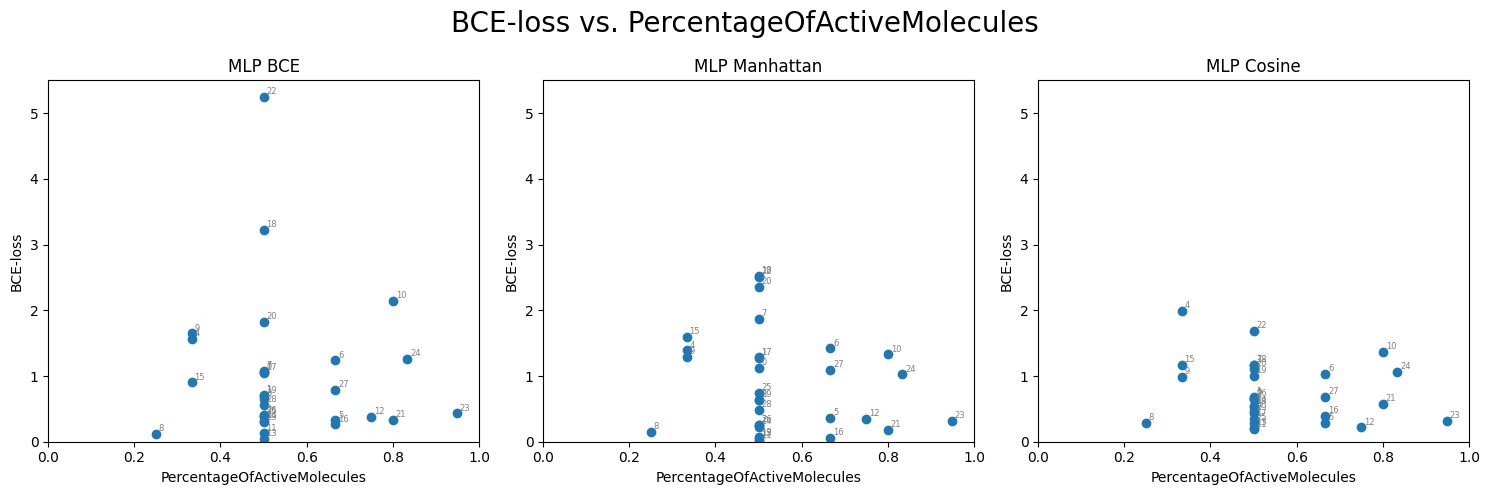

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for i, results in enumerate(results_networks):
    axes[i].scatter(data_groups['Percentage_active'], results["Loss_mean"])
    axes[i].set_title(network_titles[i])
    axes[i].set_xlabel("PercentageOfActiveMolecules")
    axes[i].set_ylabel("BCE-loss")
    axes[i].set_xlim(0, 1)
    axes[i].set_ylim(0, 5.5)

    for j in range(len(results)):
        axes[i].annotate(
            str(j),  
            (data_groups['Percentage_active'][j], results["Loss_mean"][j]),  # position of annotation
            textcoords="offset points",  # offset the text
            xytext=(2, 2),  # offset by 2 
            fontsize=6,
            color="grey"
        )

fig.suptitle("BCE-loss vs. PercentageOfActiveMolecules", fontsize=20)

plt.tight_layout()
plt.show()

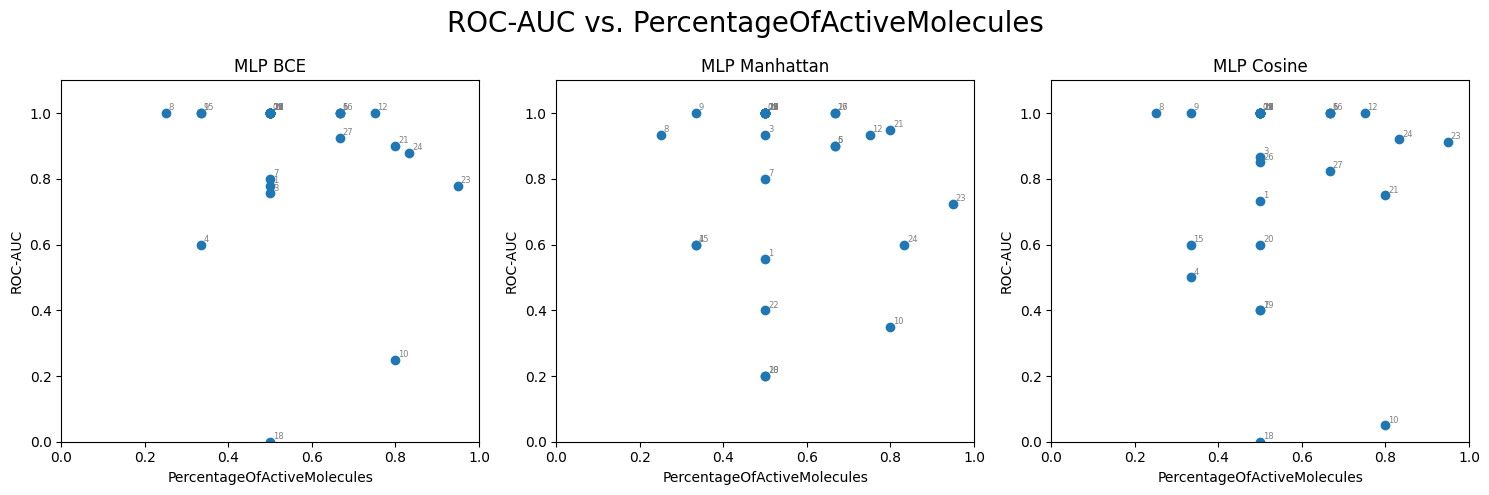

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for i, results in enumerate(results_networks):
    axes[i].scatter(data_groups['Percentage_active'], results["ROC-AUC_mean"])
    axes[i].set_title(network_titles[i])
    axes[i].set_xlabel("PercentageOfActiveMolecules")
    axes[i].set_ylabel("ROC-AUC")
    axes[i].set_xlim(0, 1)
    axes[i].set_ylim(0, 1.1)

    for j in range(len(results)):
        axes[i].annotate(
            str(j),  
            (data_groups['Percentage_active'][j], results["ROC-AUC_mean"][j]),  # position of annotation
            textcoords="offset points",  # offset the text
            xytext=(2, 2),  # offset by 2 
            fontsize=6,
            color="grey"
        )

fig.suptitle("ROC-AUC vs. PercentageOfActiveMolecules", fontsize=20)

plt.tight_layout()
plt.show()

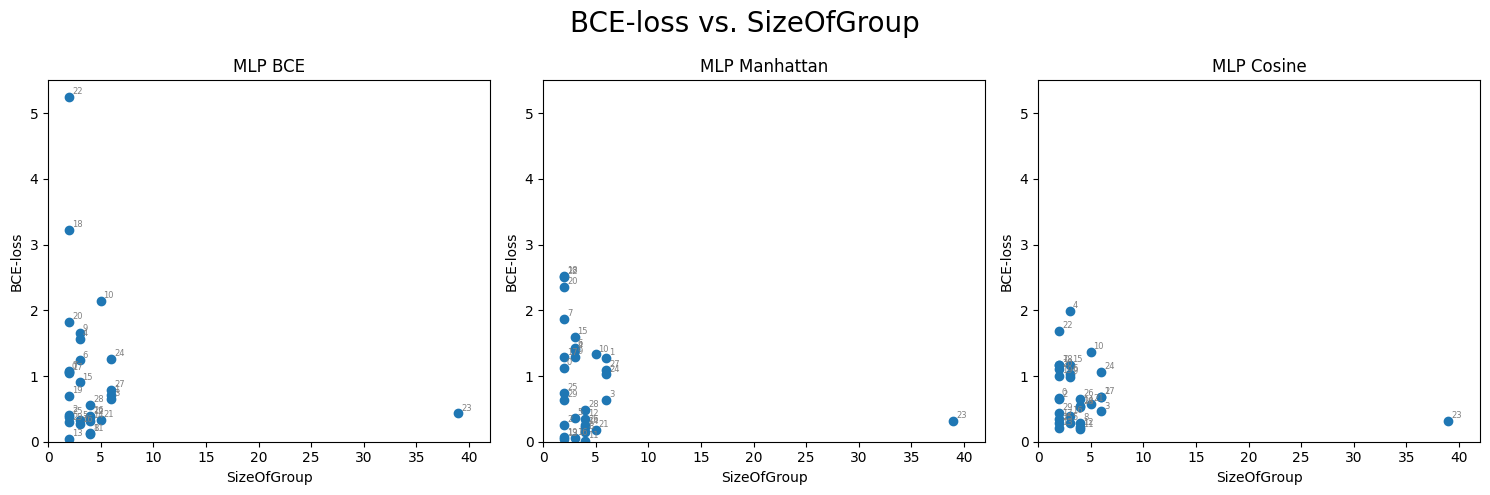

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for i, results in enumerate(results_networks):
    axes[i].scatter(data_groups['Size_of_group'], results["Loss_mean"])
    axes[i].set_title(network_titles[i])
    axes[i].set_xlabel("SizeOfGroup")
    axes[i].set_ylabel("BCE-loss")
    axes[i].set_xlim(0, 42)
    axes[i].set_ylim(0, 5.5)

    for j in range(len(results)):
        axes[i].annotate(
            str(j),  
            (data_groups['Size_of_group'][j], results["Loss_mean"][j]),  # position of annotation
            textcoords="offset points",  # offset the text
            xytext=(2, 2),  # offset by 2 
            fontsize=6,
            color="grey"
        )

fig.suptitle("BCE-loss vs. SizeOfGroup", fontsize=20)

plt.tight_layout()
plt.show()

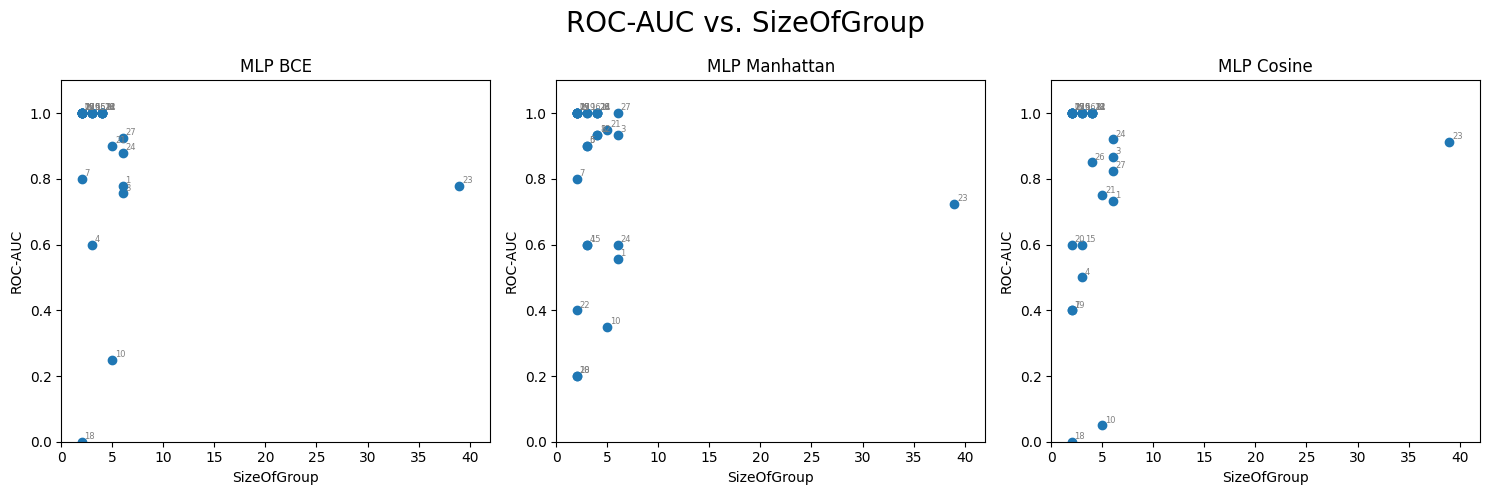

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for i, results in enumerate(results_networks):
    axes[i].scatter(data_groups['Size_of_group'], results["ROC-AUC_mean"])
    axes[i].set_title(network_titles[i])
    axes[i].set_xlabel("SizeOfGroup")
    axes[i].set_ylabel("ROC-AUC")
    axes[i].set_xlim(0, 42)
    axes[i].set_ylim(0, 1.1)

    for j in range(len(results)):
        axes[i].annotate(
            str(j),  
            (data_groups['Size_of_group'][j], results["ROC-AUC_mean"][j]),  # position of annotation
            textcoords="offset points",  # offset the text
            xytext=(2, 2),  # offset by 2 
            fontsize=6,
            color="grey"
        )

fig.suptitle("ROC-AUC vs. SizeOfGroup", fontsize=20)

plt.tight_layout()
plt.show()

In [10]:
def plot_pca(group_id, seed):

    def str_to_array(x):
        return np.array(json.loads(x), dtype=np.float32)


    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    class_colors = {0: 'blue', 1: 'red'}

    for i, network in enumerate(networks_seeds[seed]):

        filtered_df = df_test[df_test["cliff_group"] == group_id]

        network.eval()
        dataset = MoleculeACEDataset(filtered_df["ecfp"].apply(str_to_array), filtered_df['active'])
        data_loader = DataLoader(dataset, batch_size=len(filtered_df))

        samples, targets = next(iter(data_loader))
        assert len(samples) == len(filtered_df)

        outputs, emb = network(samples)

        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(emb.detach().numpy())
        pca = PCA(n_components=2)
        principal_components = pca.fit_transform(data_scaled)

        colors = filtered_df["active"].map(class_colors)

        axes[i].scatter(principal_components[:, 0], principal_components[:, 1], c=colors)
        axes[i].set_title(network_titles[i])
        axes[i].set_xlabel("PC1")
        axes[i].set_ylabel("PC2")

    handles = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=class_colors[0], markersize=10, label='Inactive'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=class_colors[1], markersize=10, label='Active')
    ]
    fig.legend(handles=handles, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.05))

    fig.suptitle(f"PCA of Network Embeddings for Cliff Group {group_id}", fontsize=20)

    plt.tight_layout()
    plt.show()

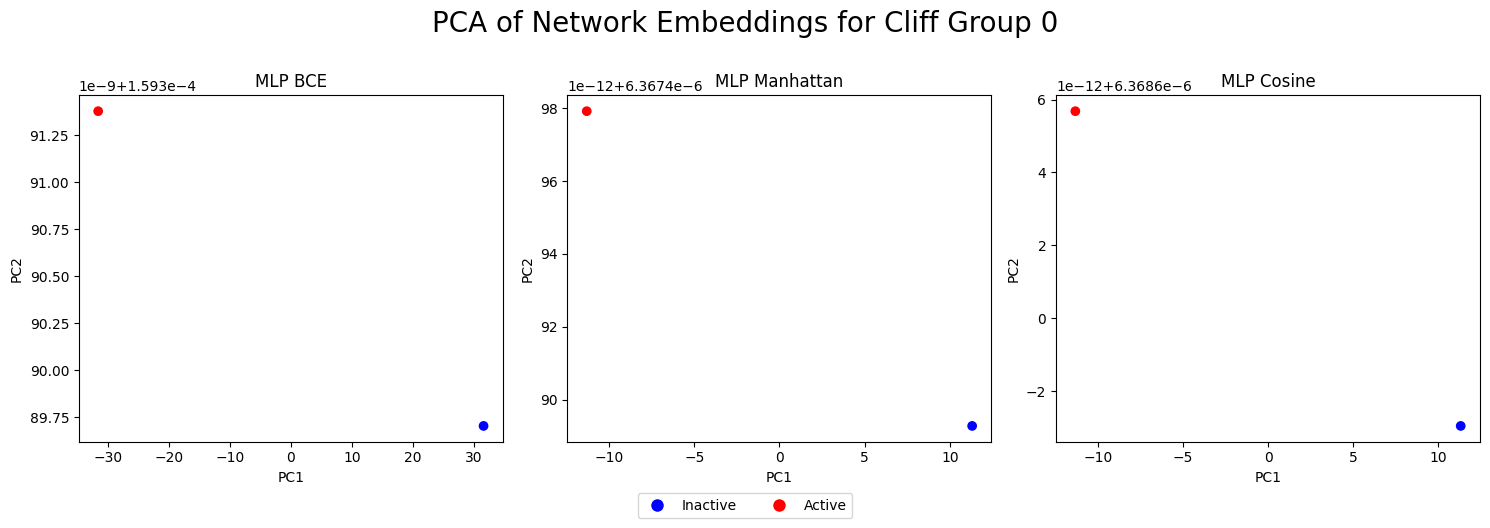

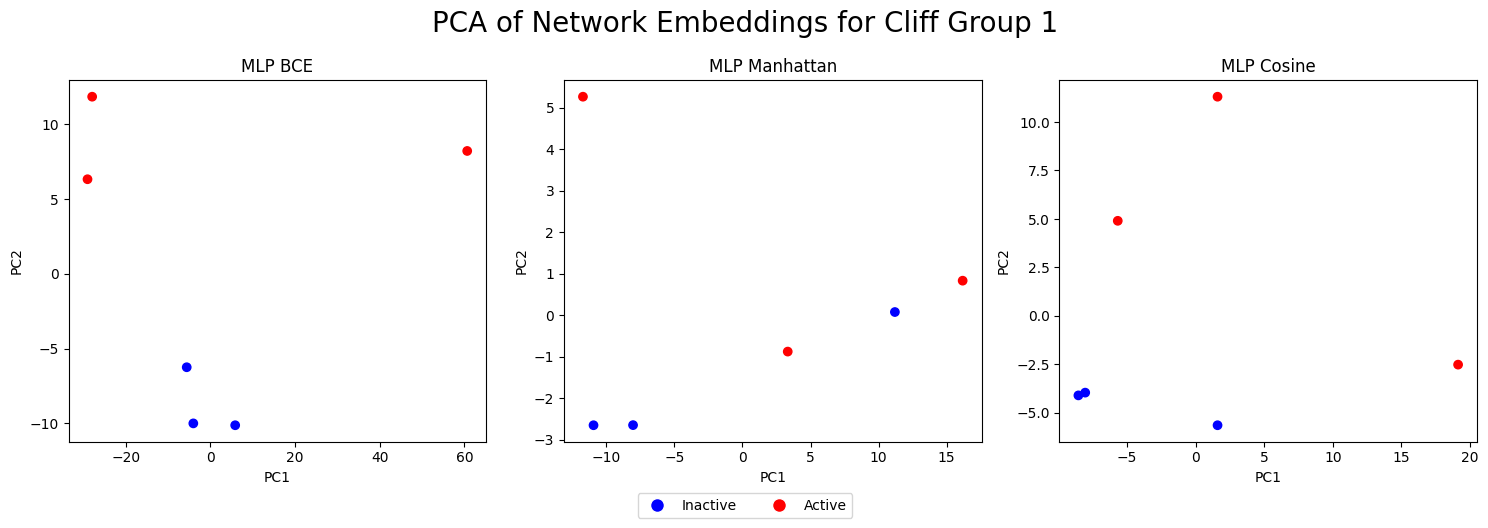

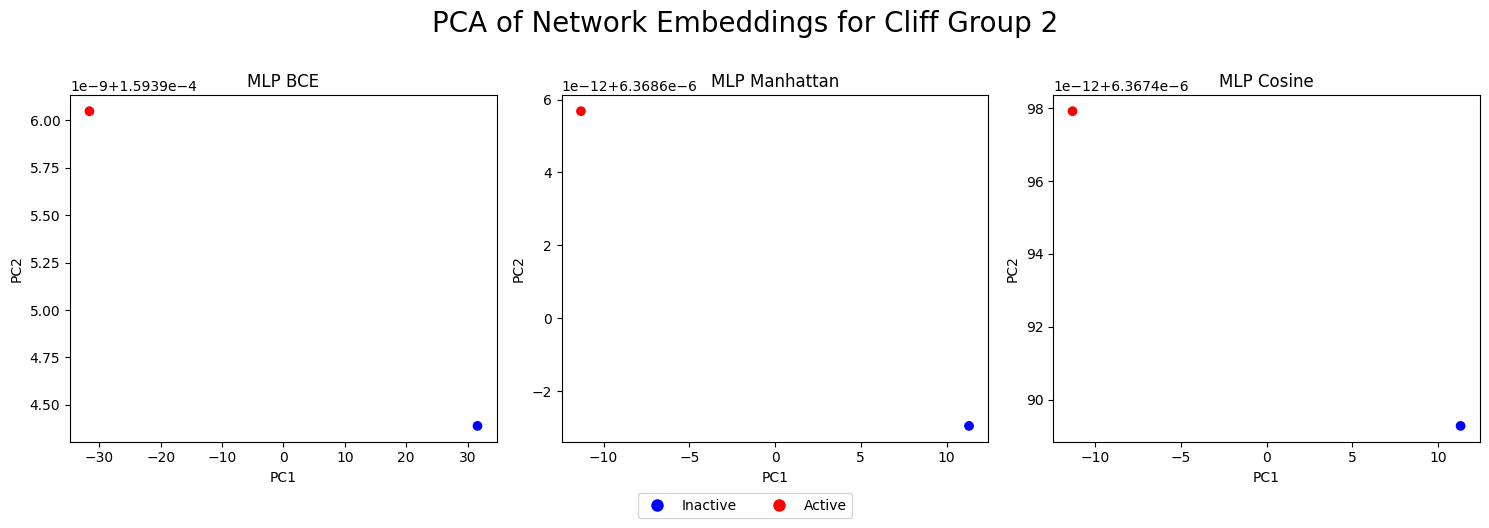

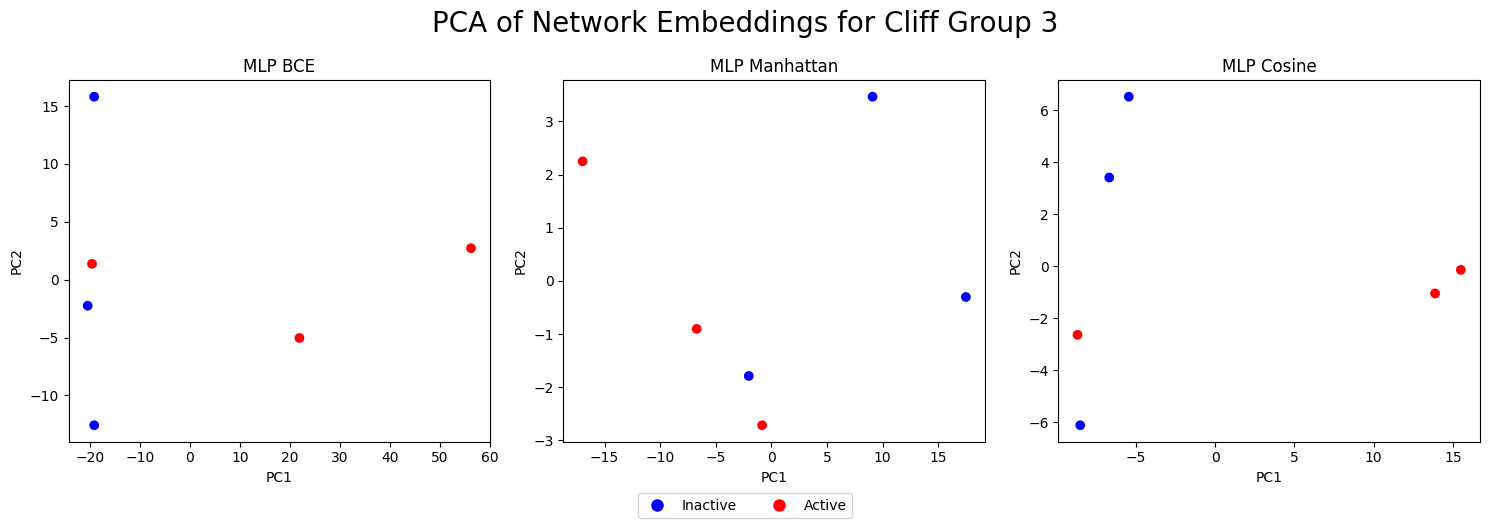

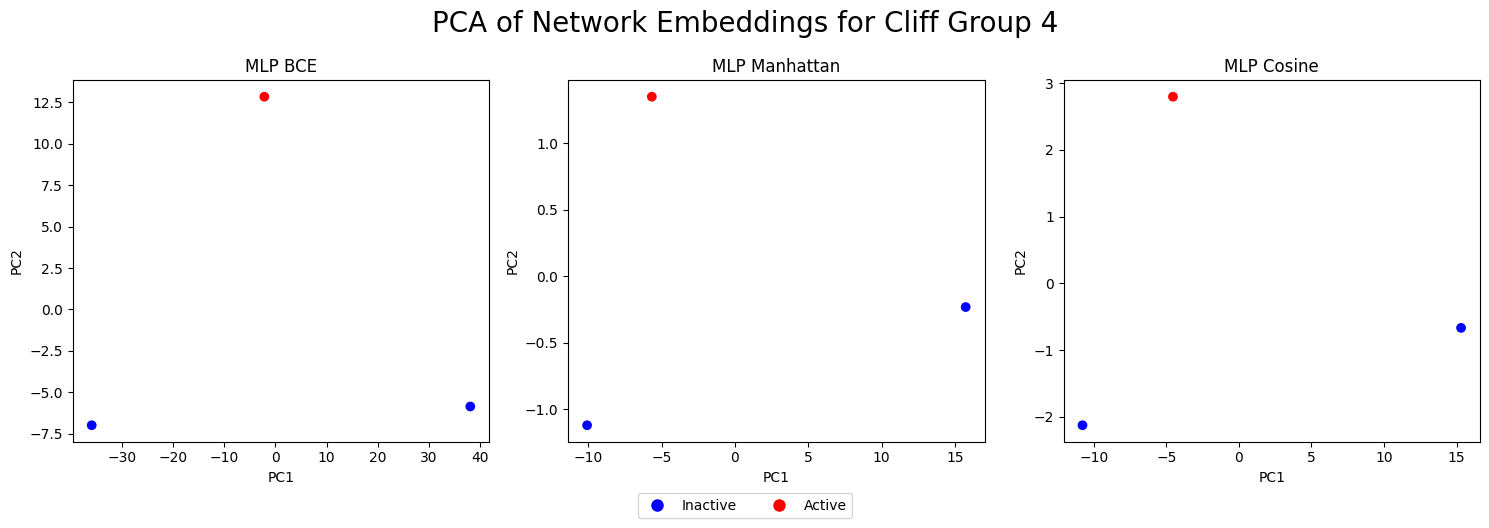

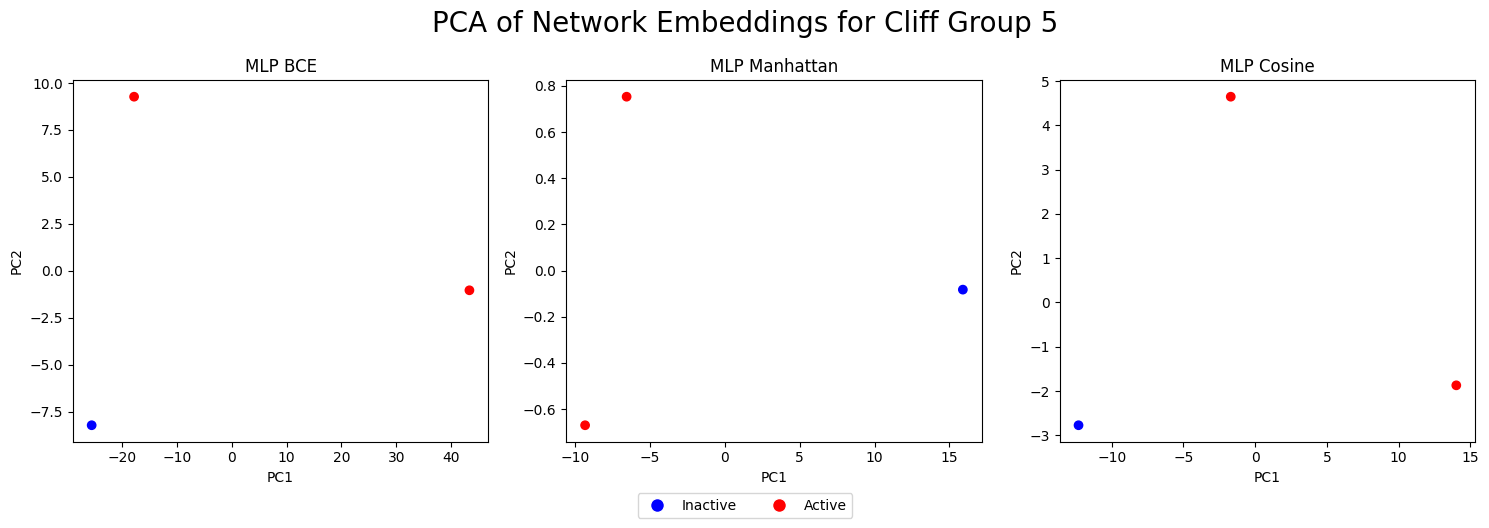

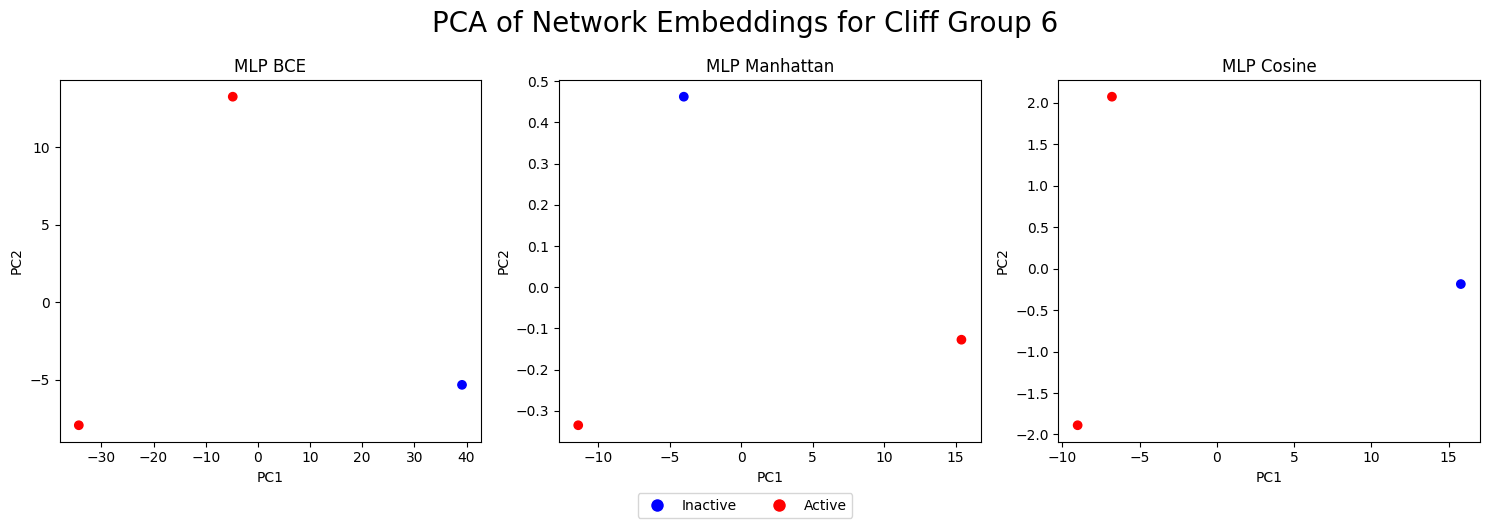

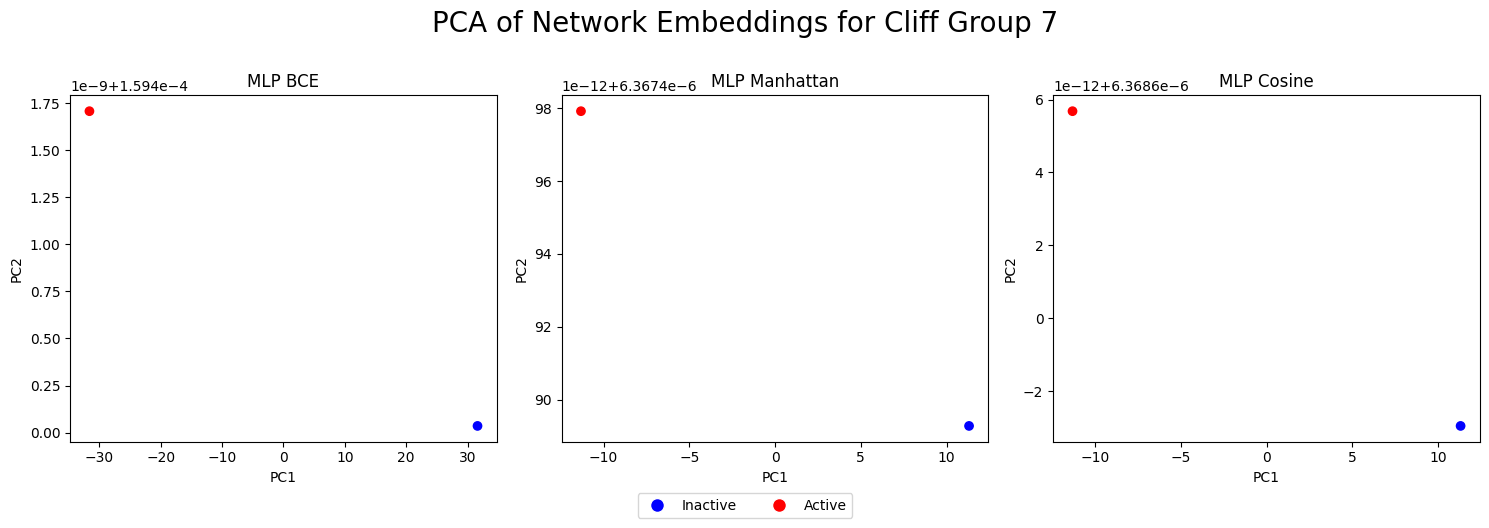

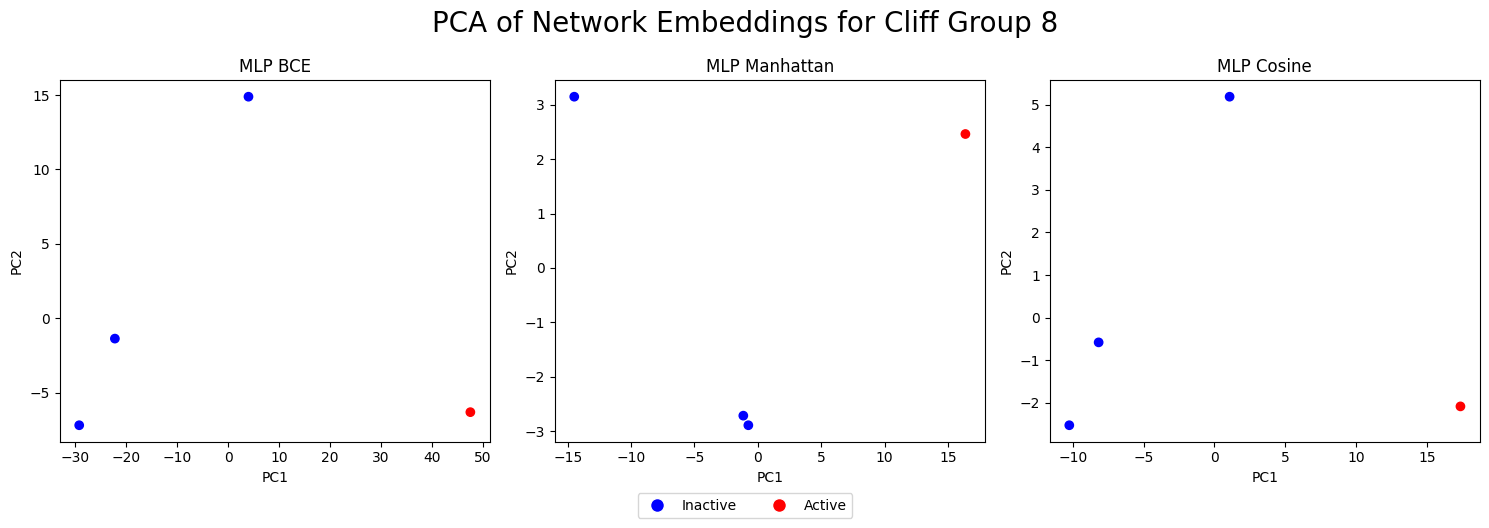

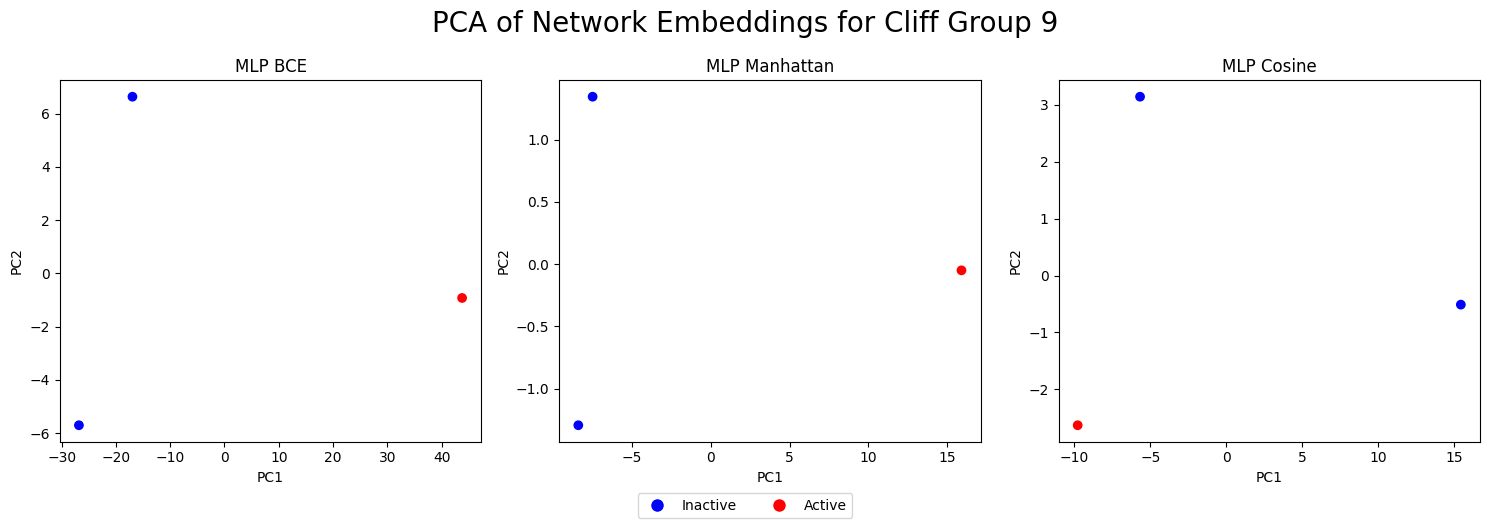

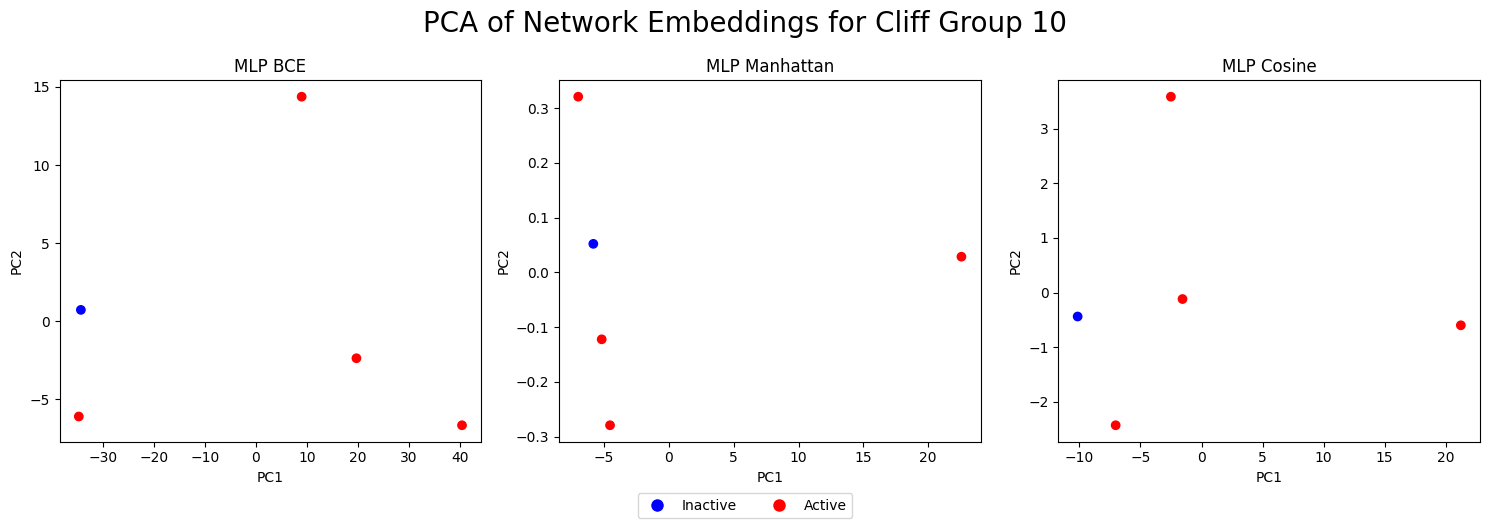

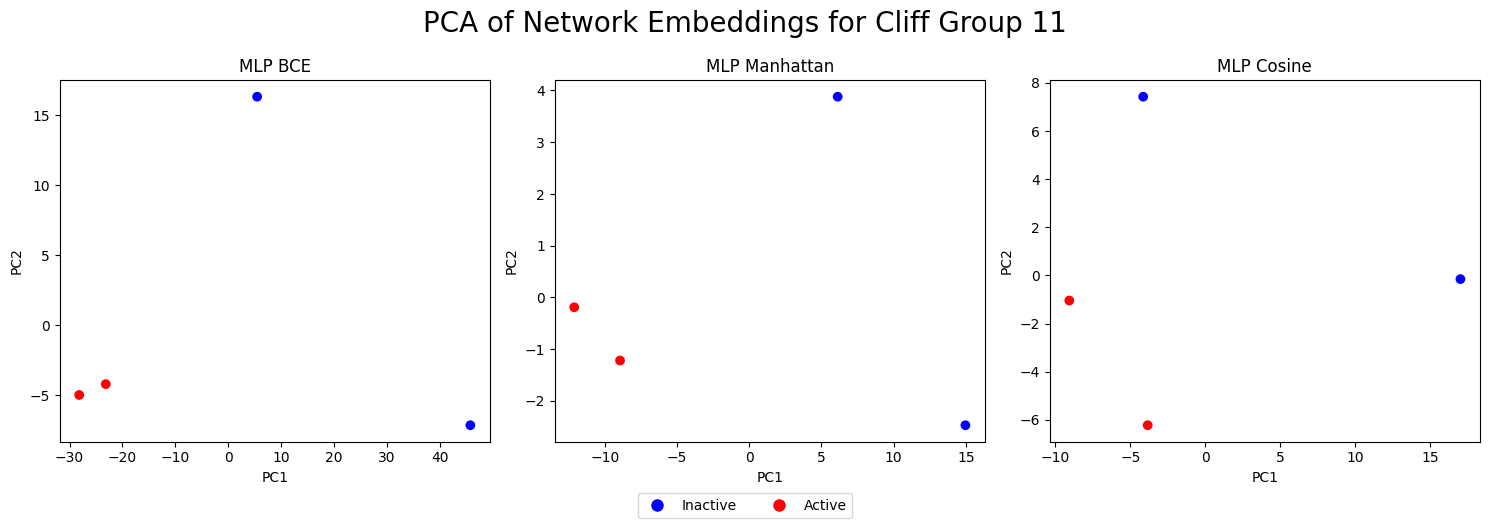

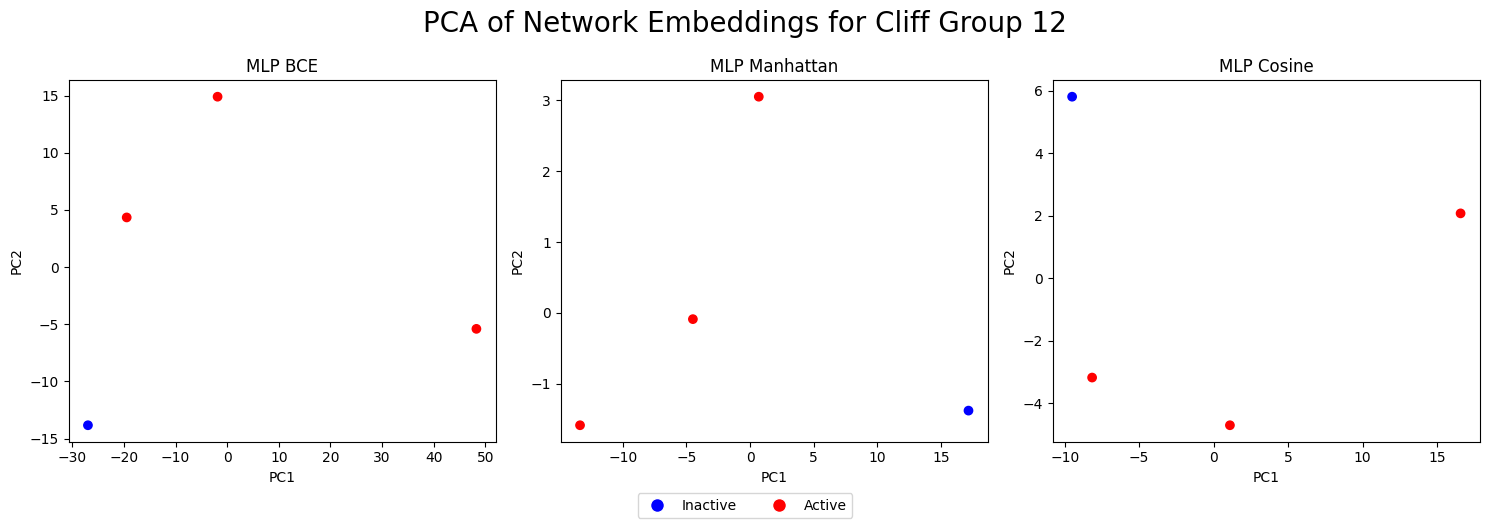

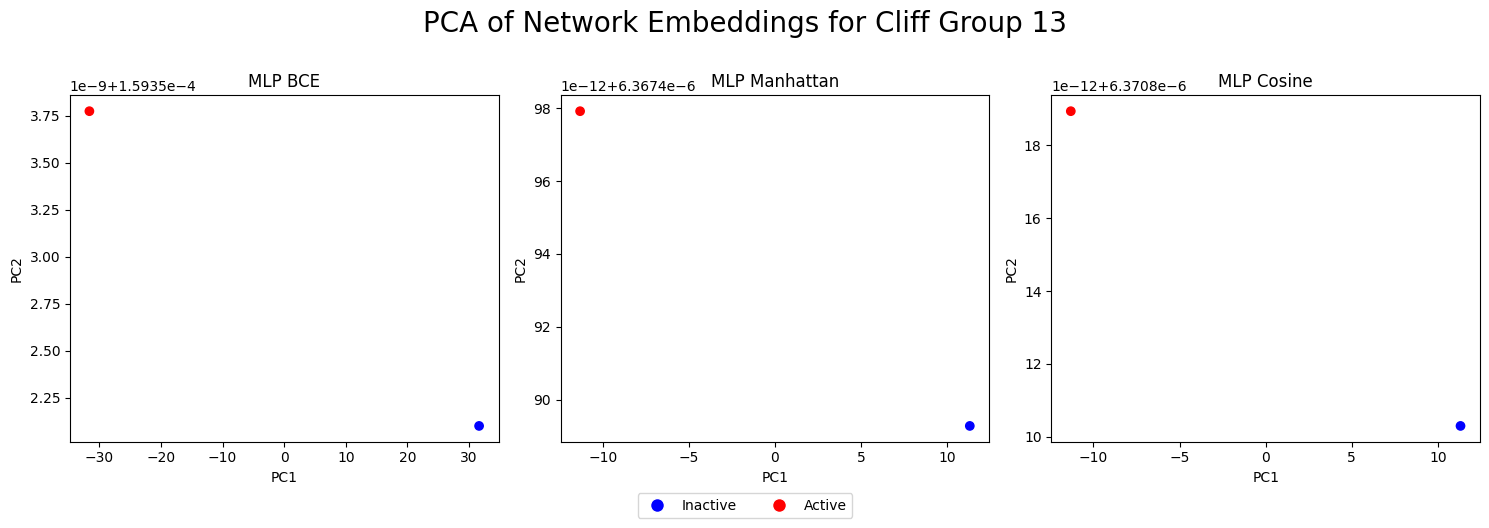

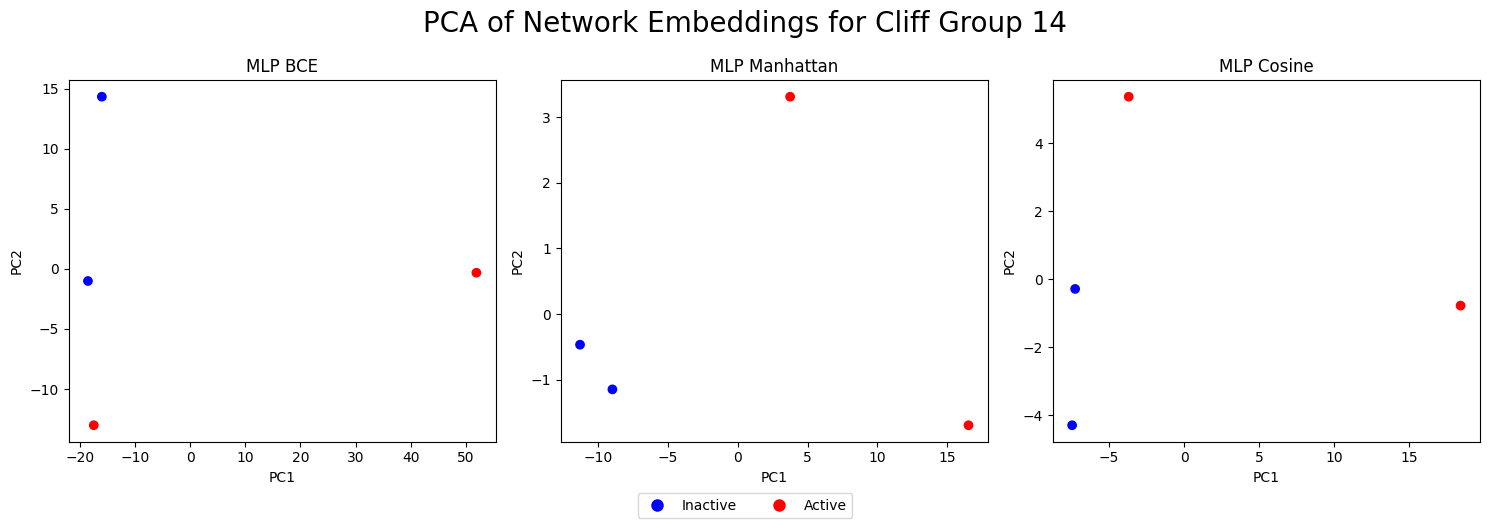

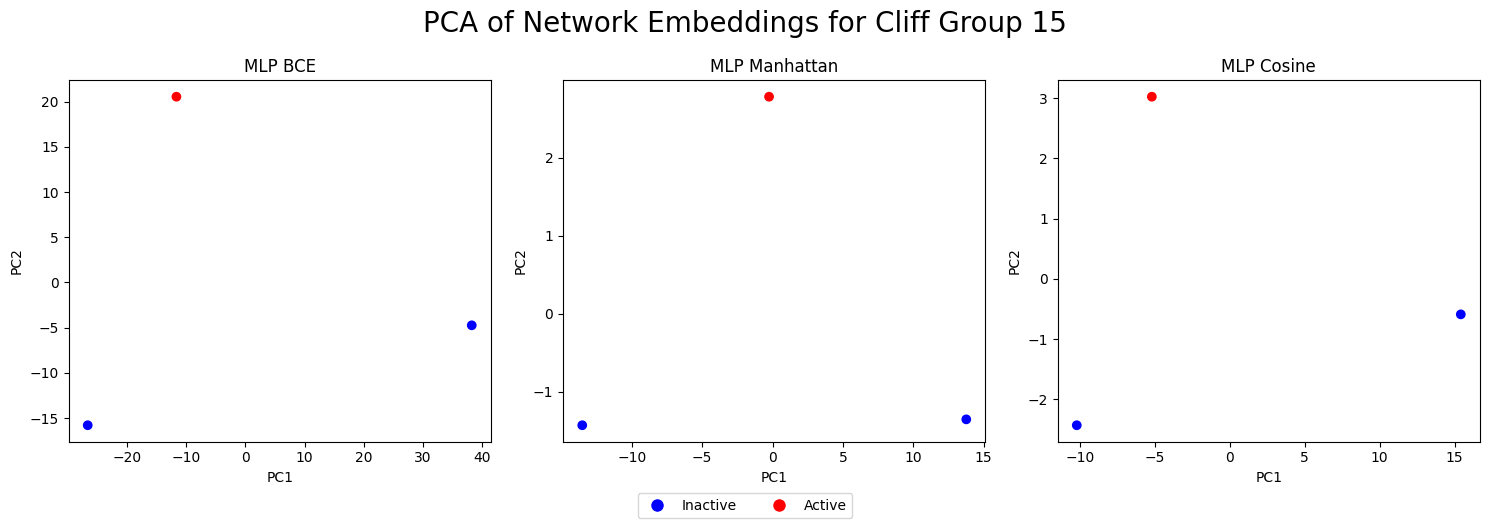

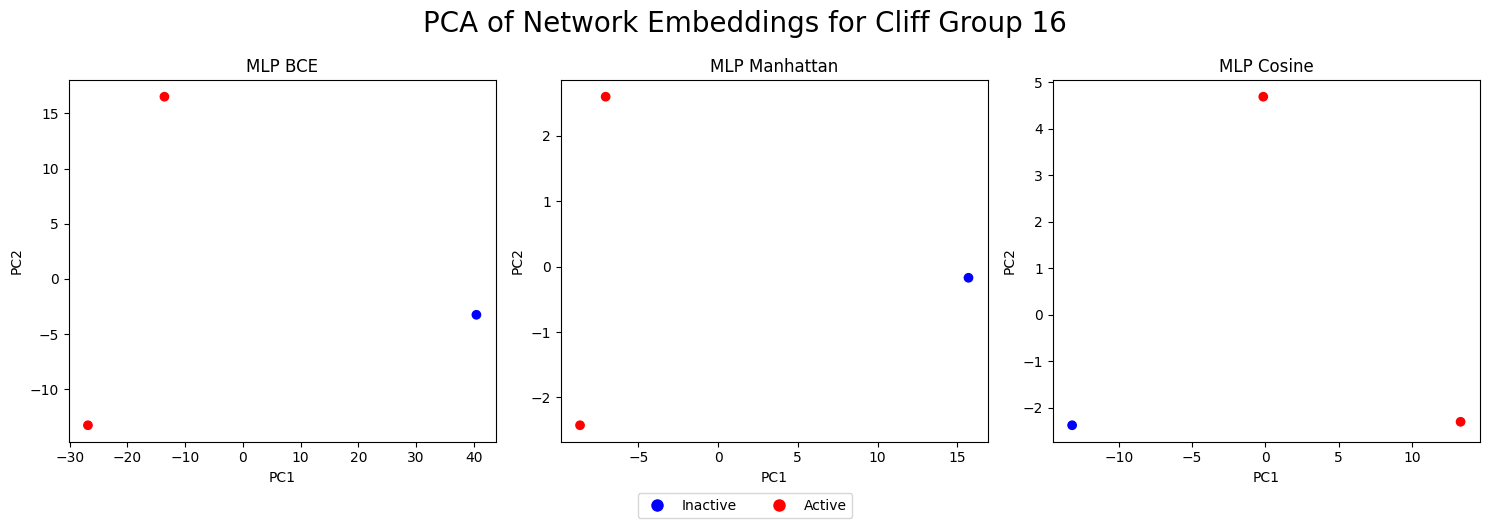

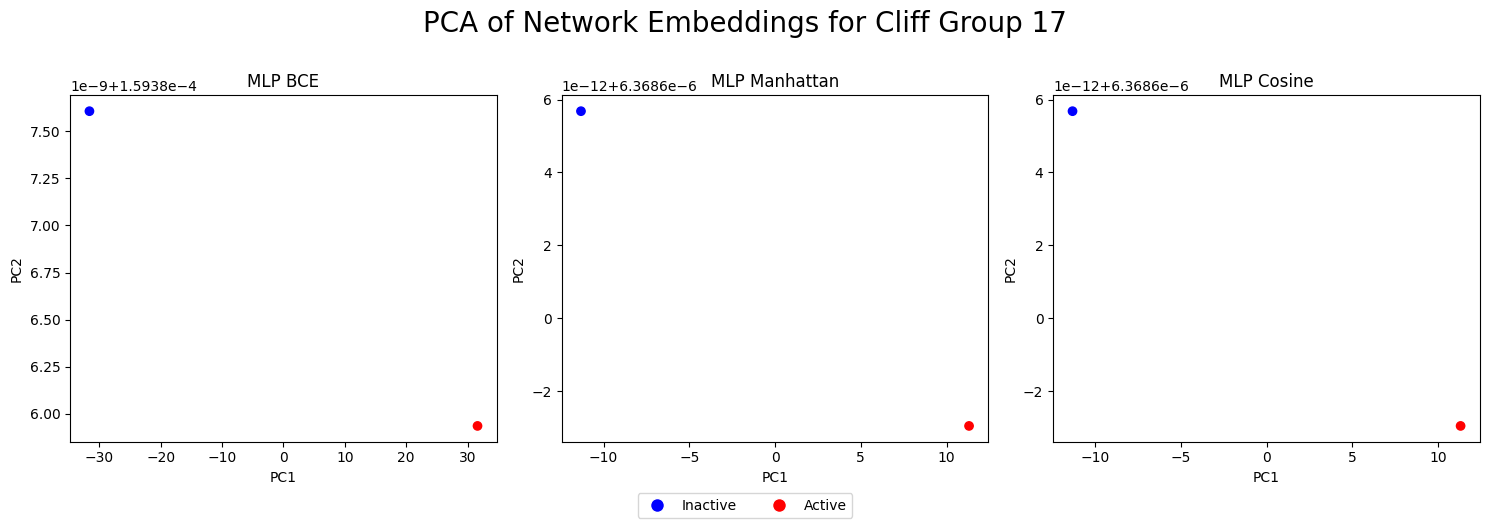

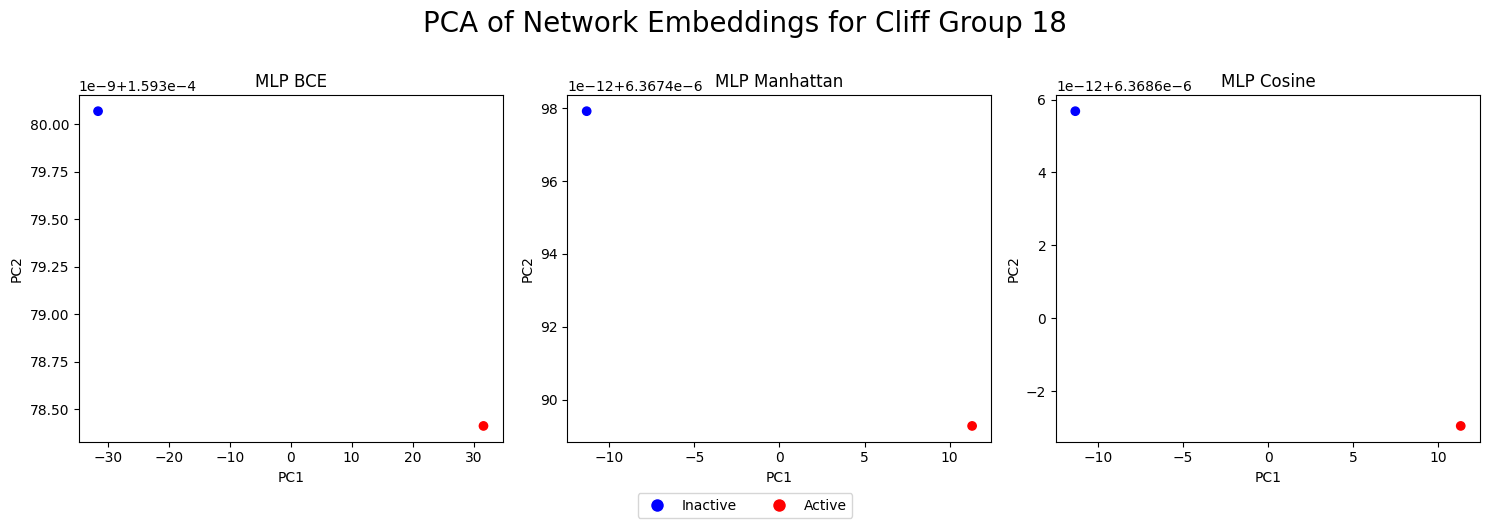

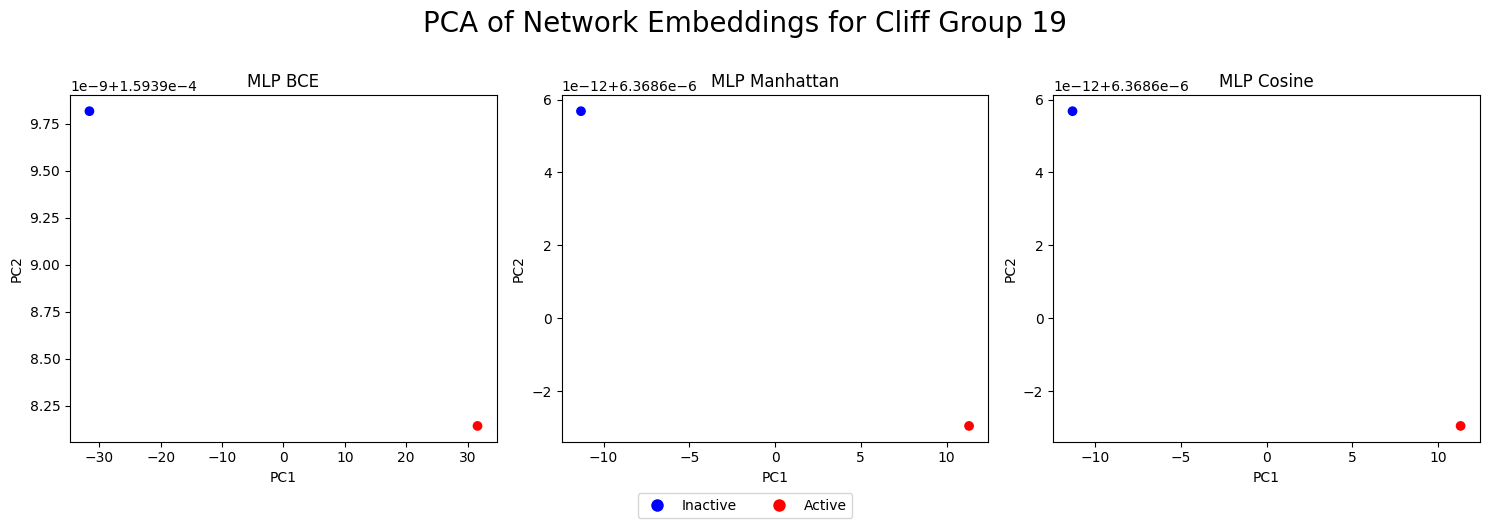

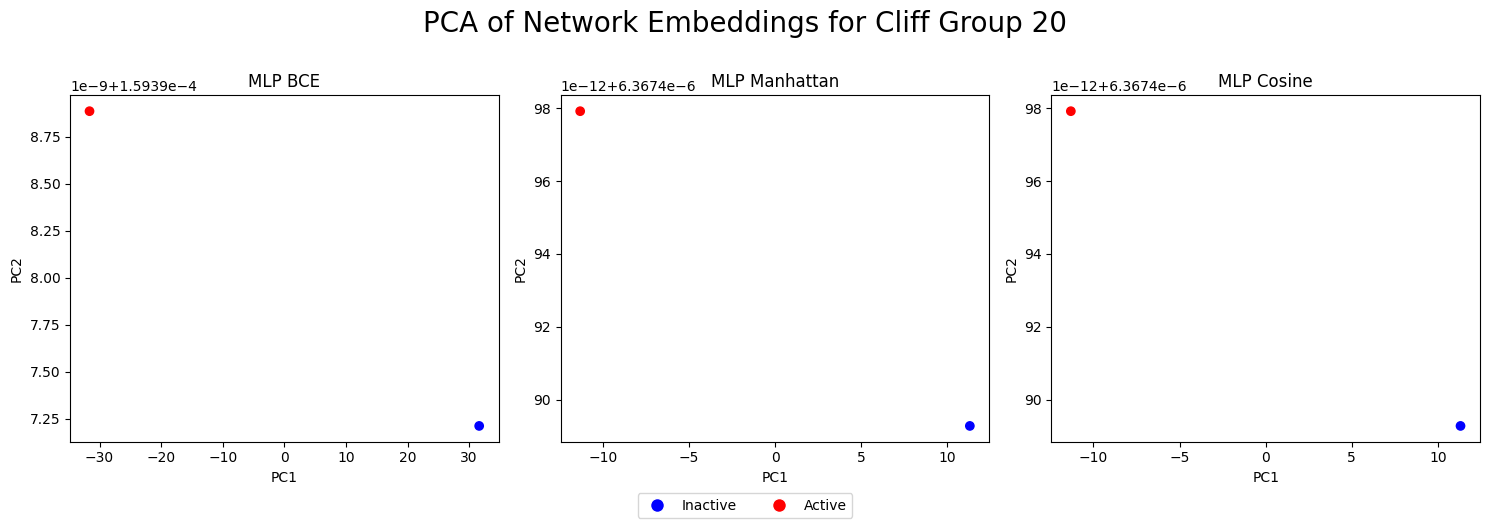

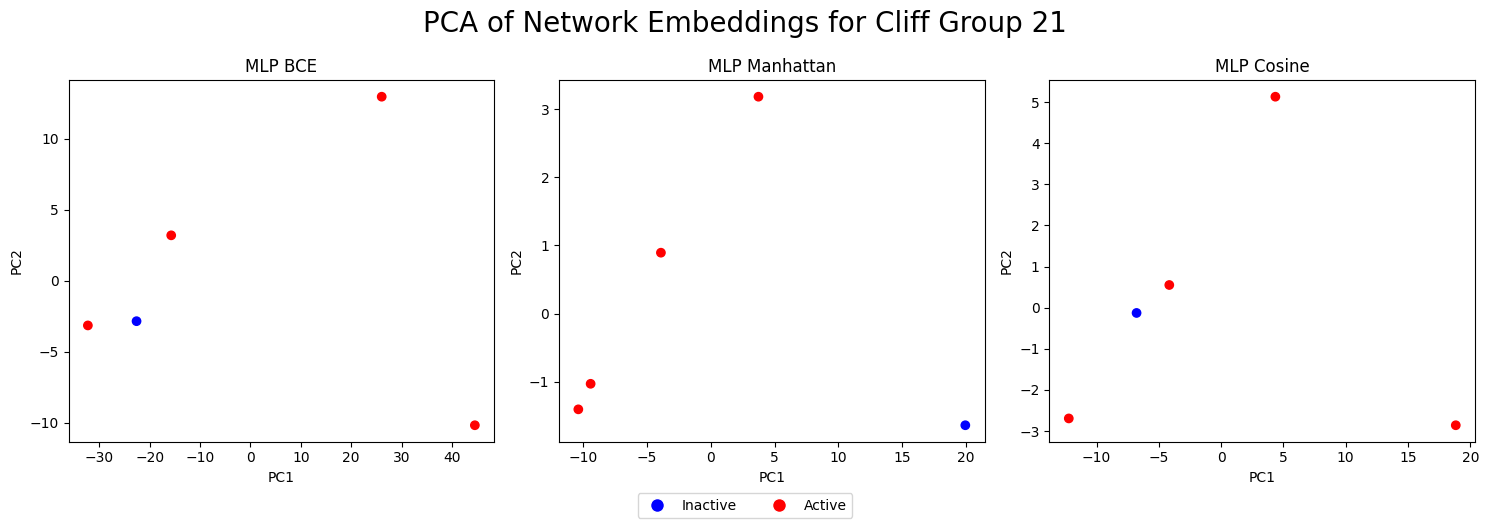

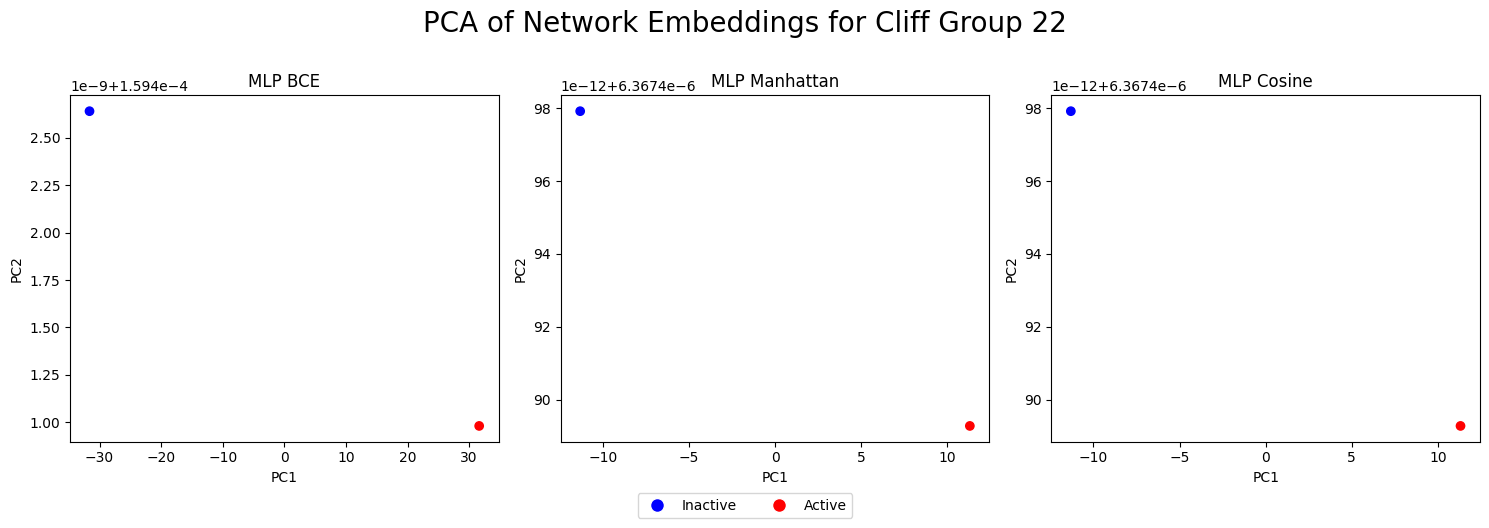

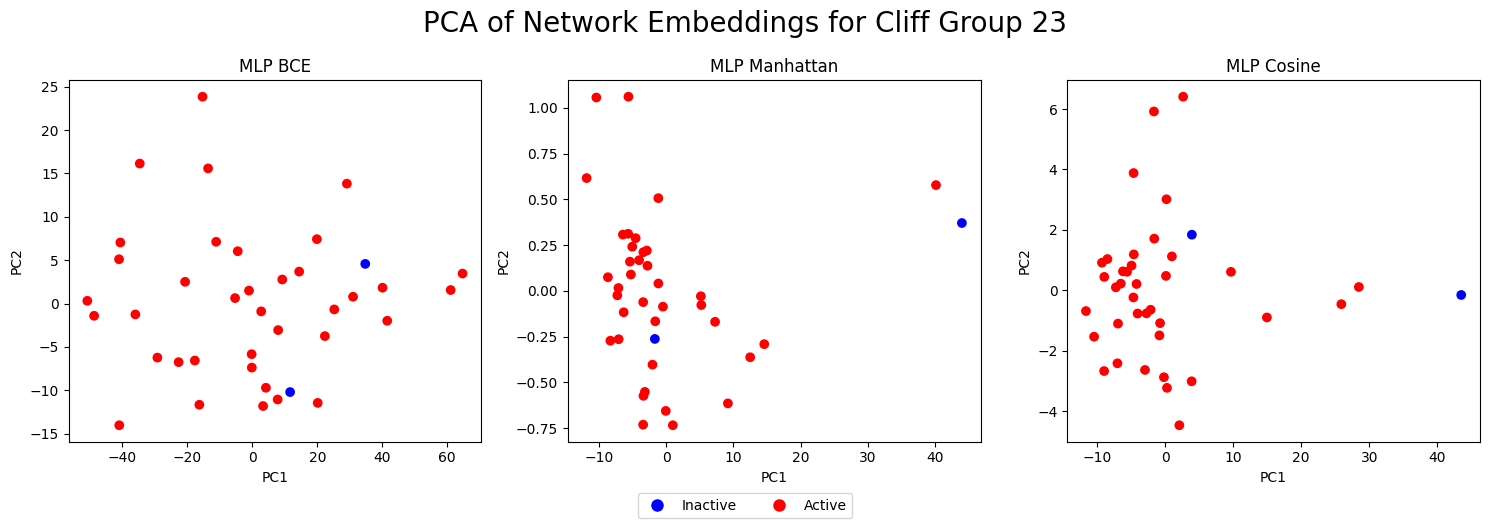

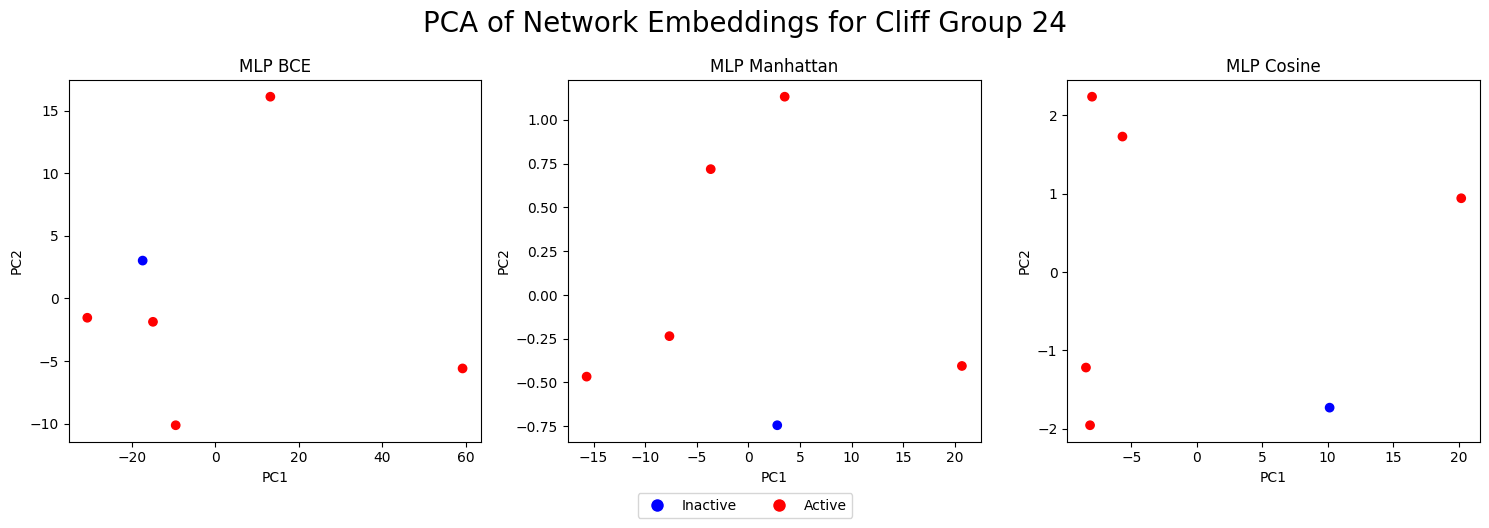

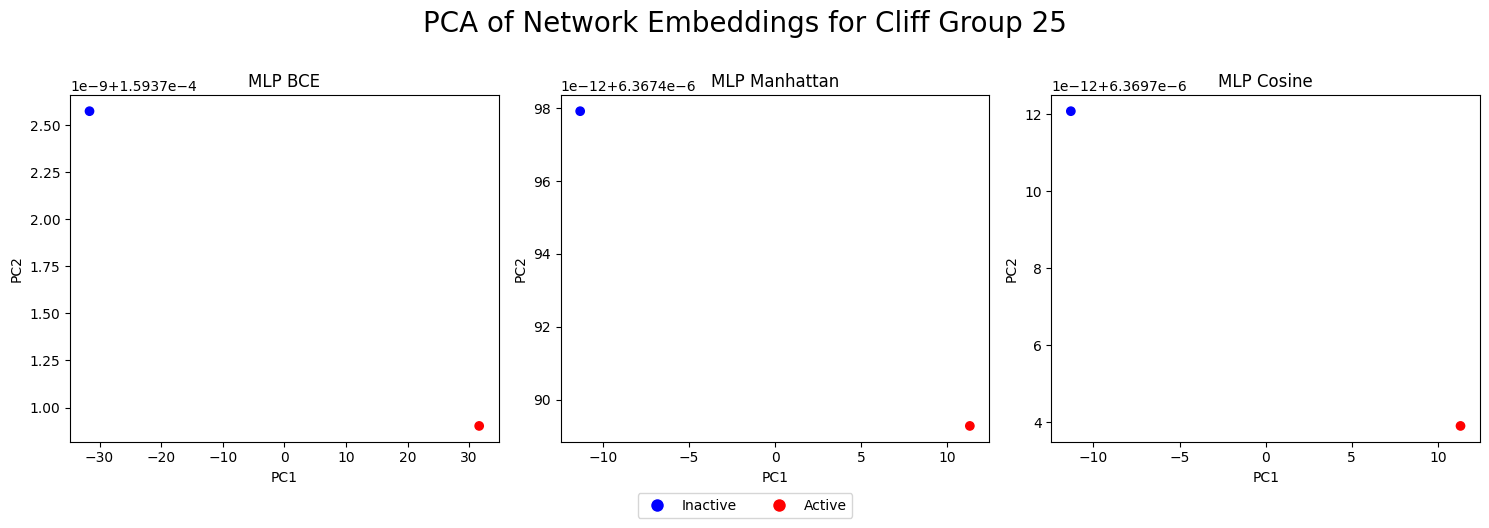

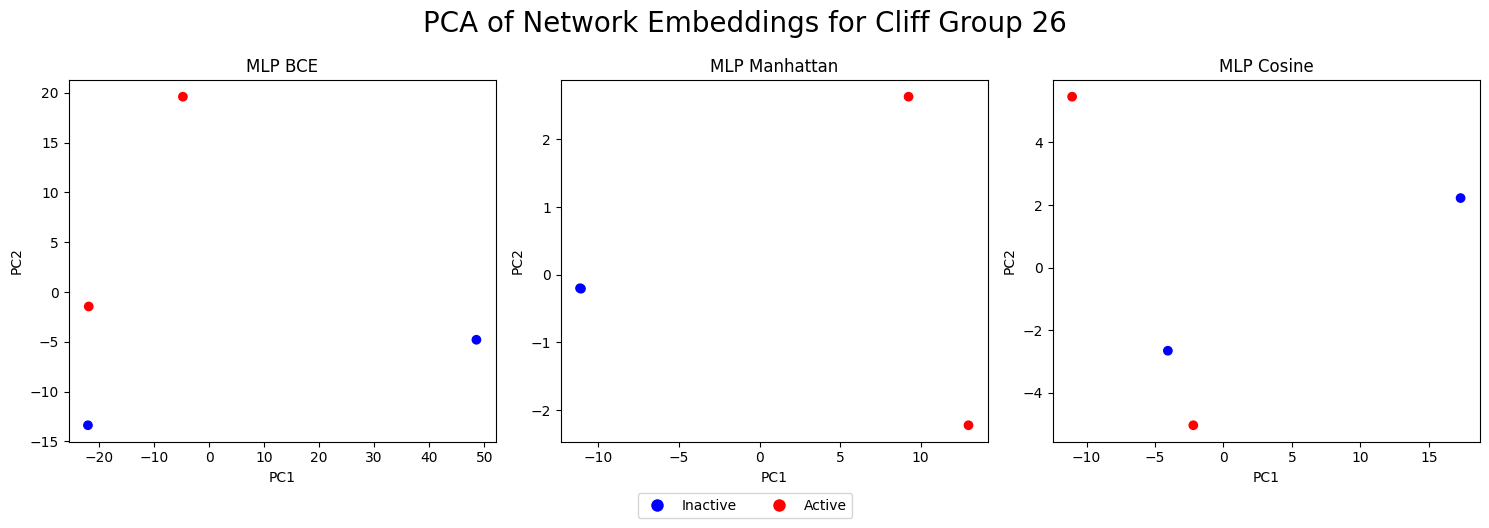

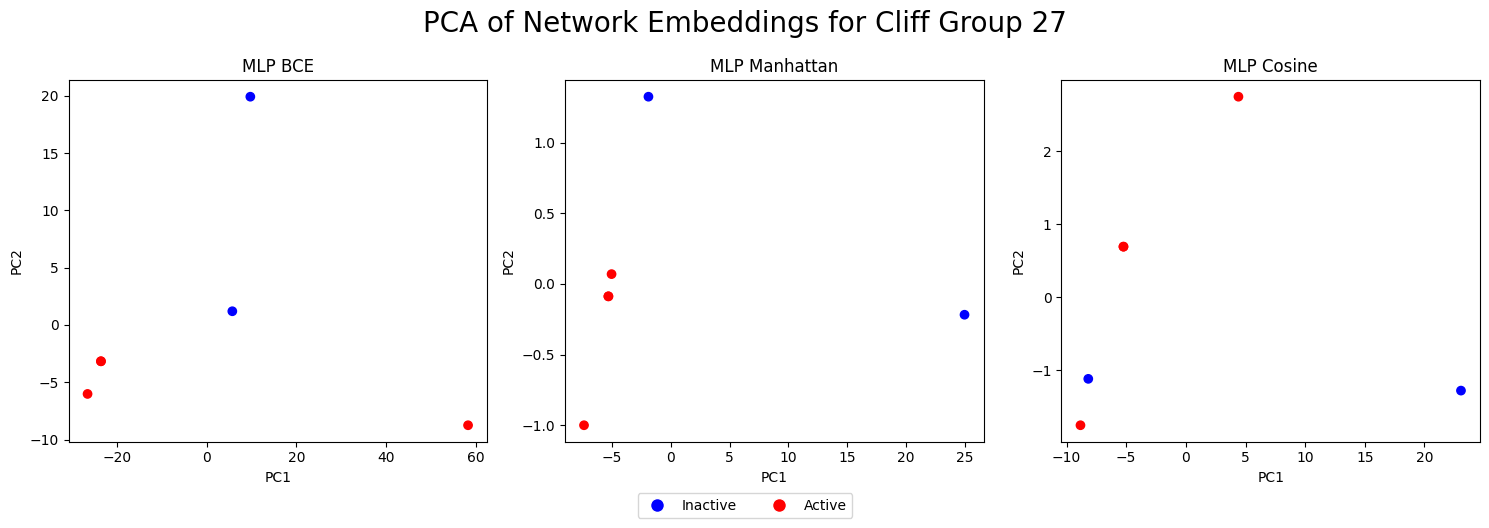

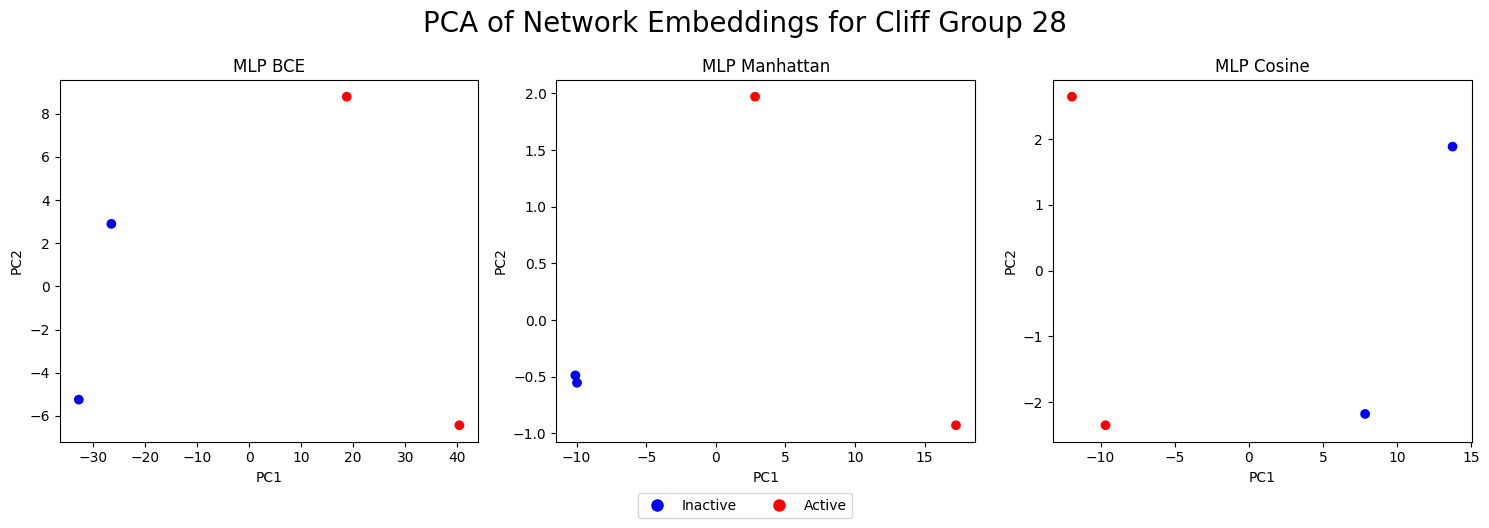

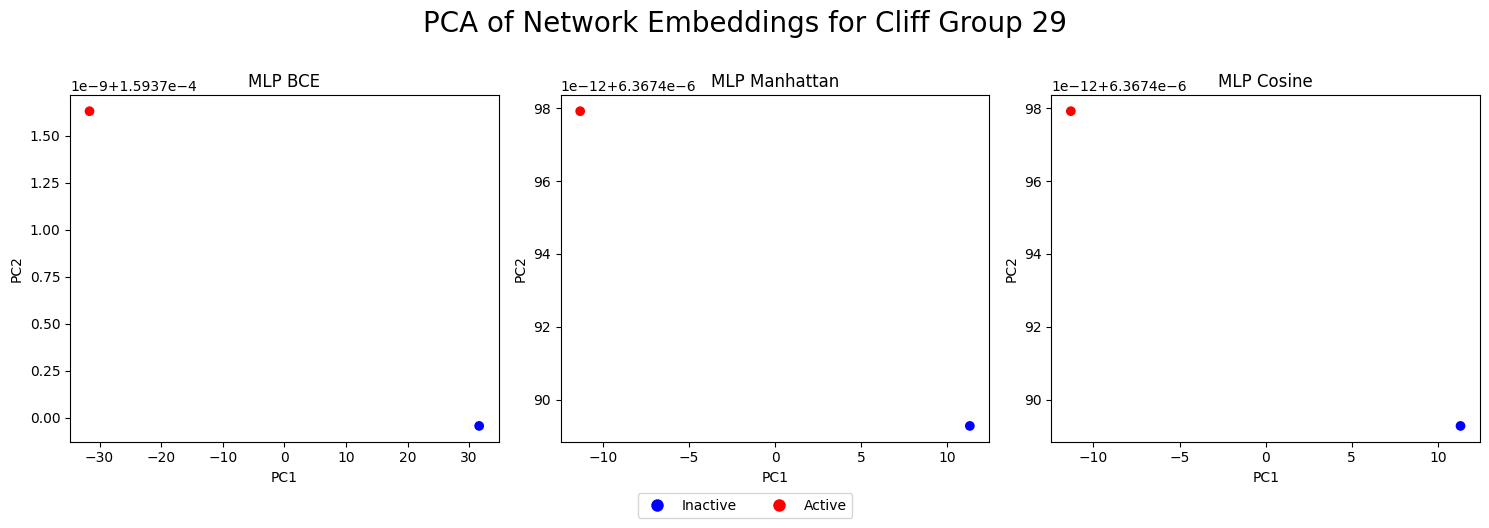

In [11]:
for i in range(len(group_dict)):
    plot_pca(group_id=i, seed=12)

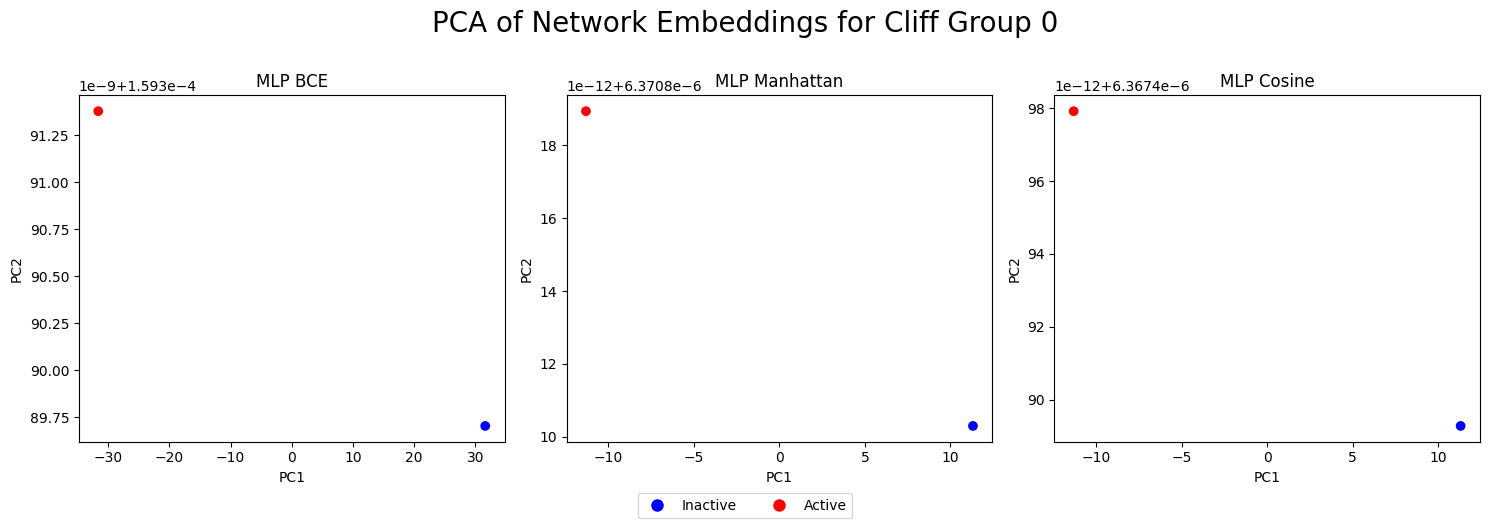

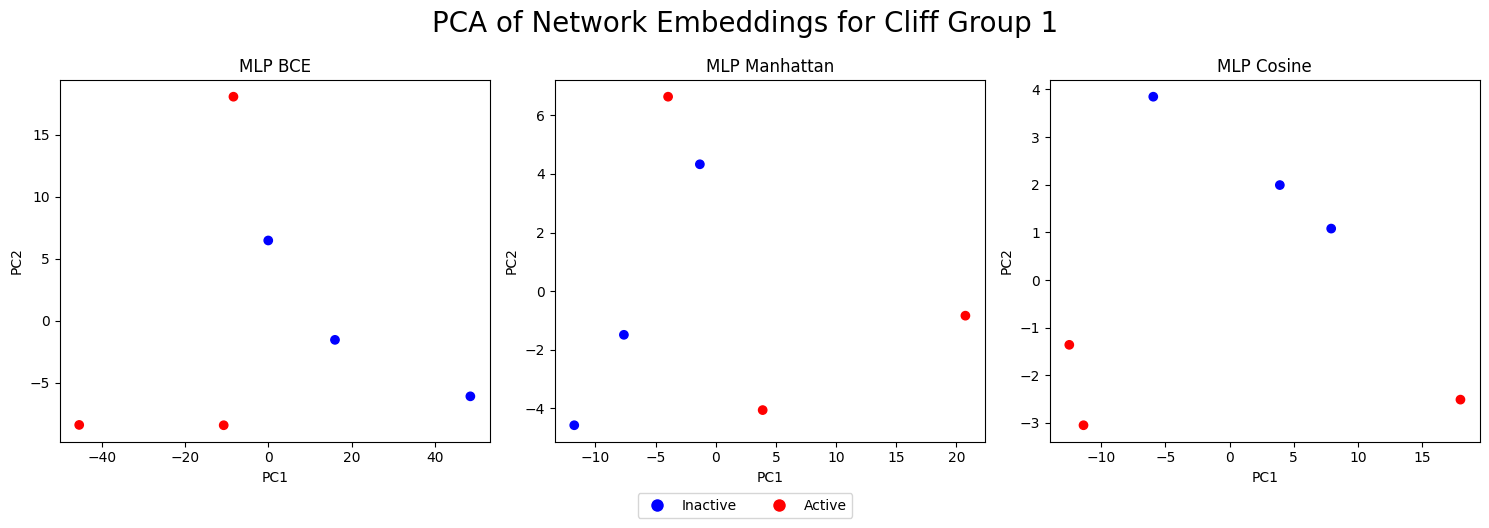

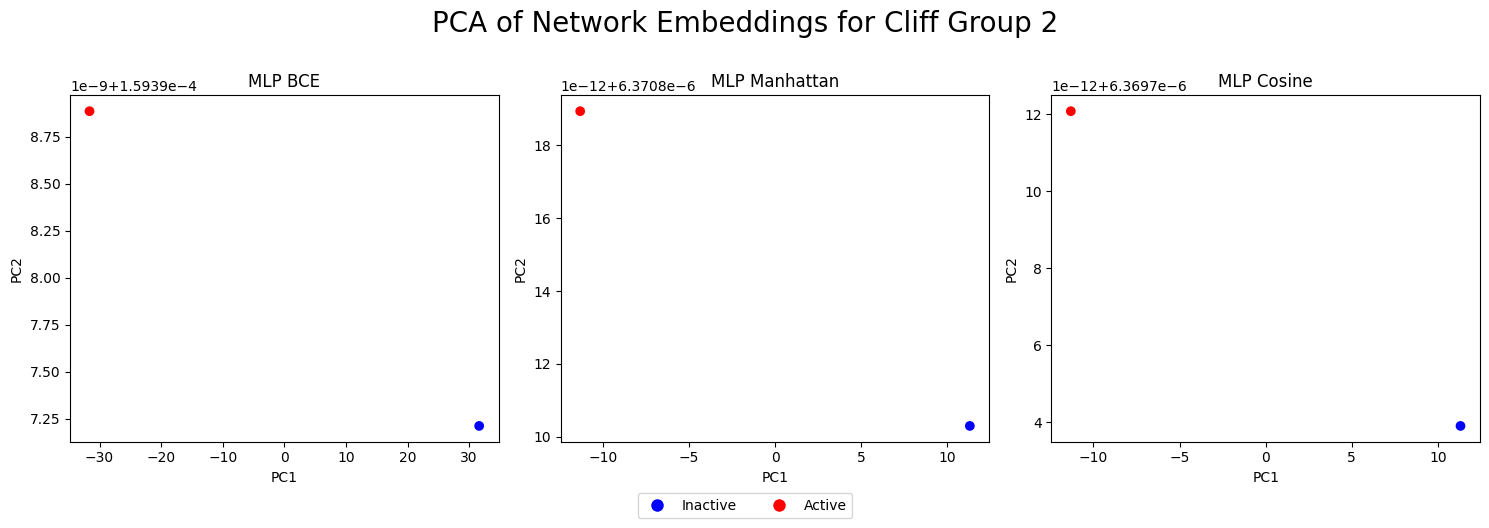

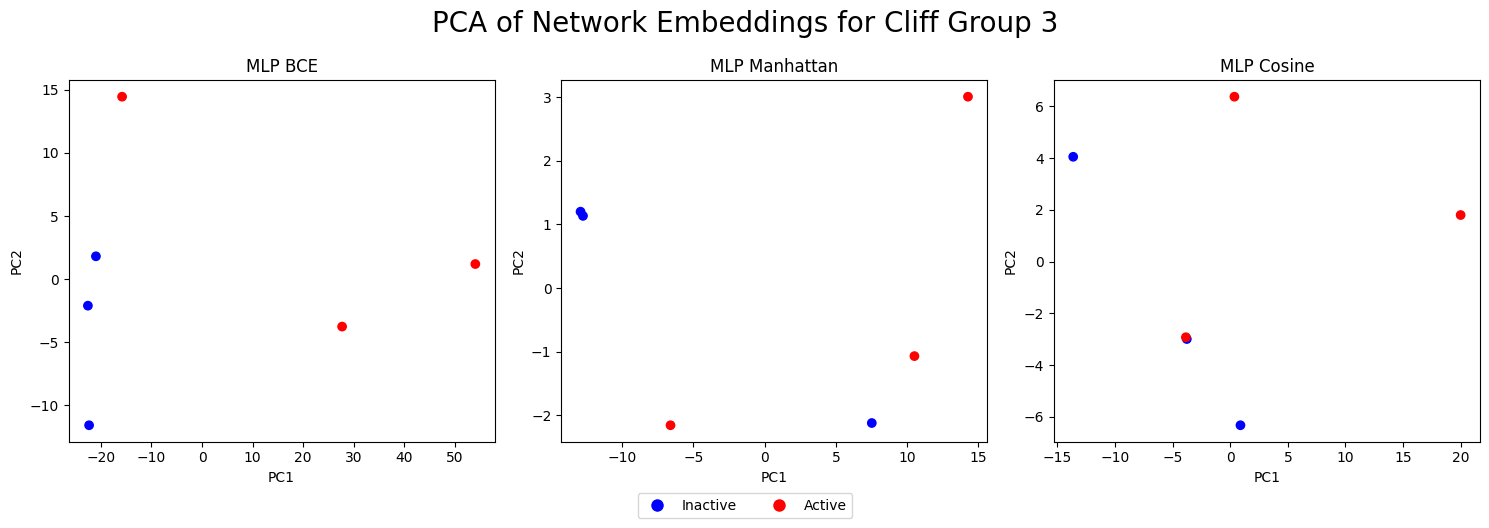

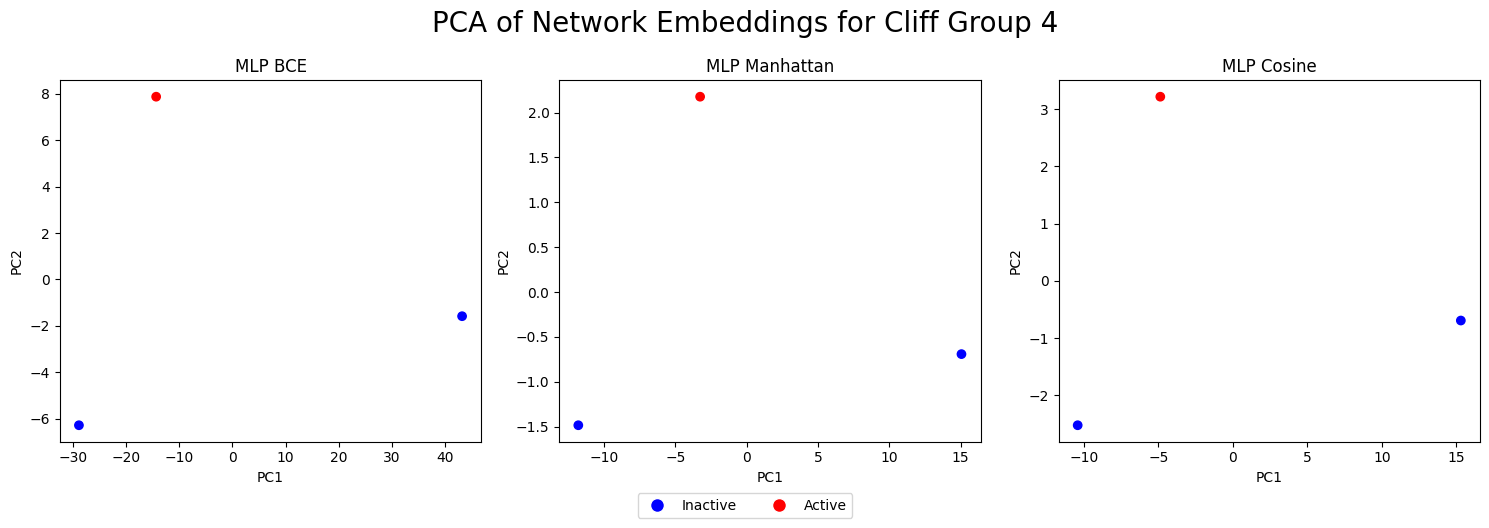

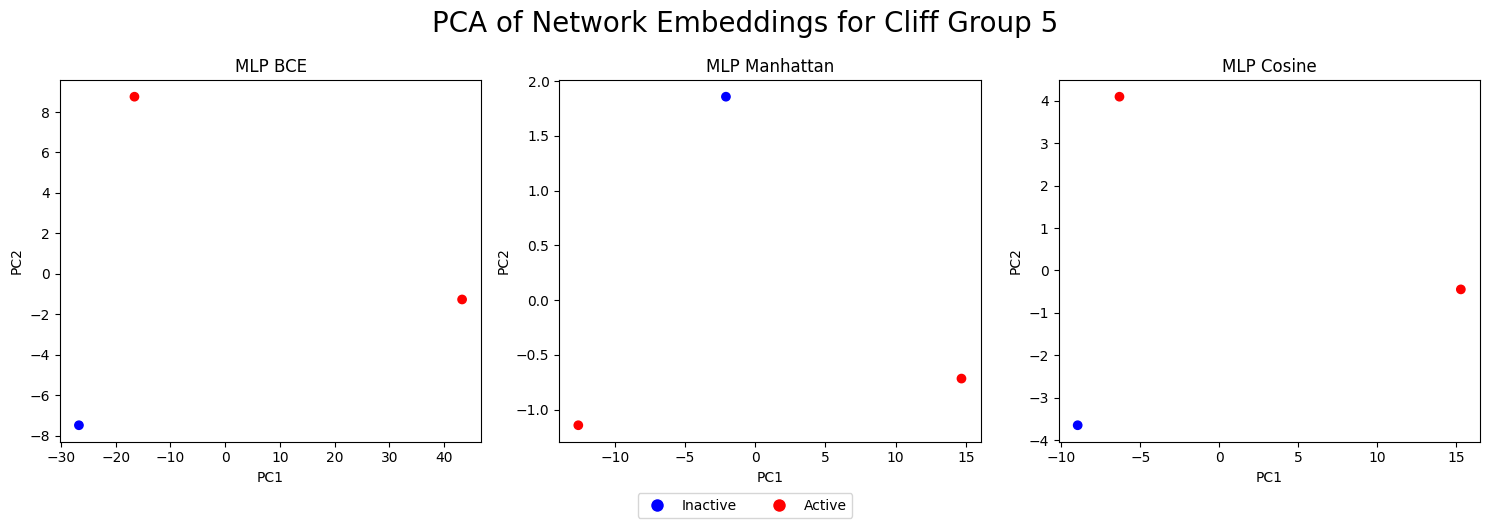

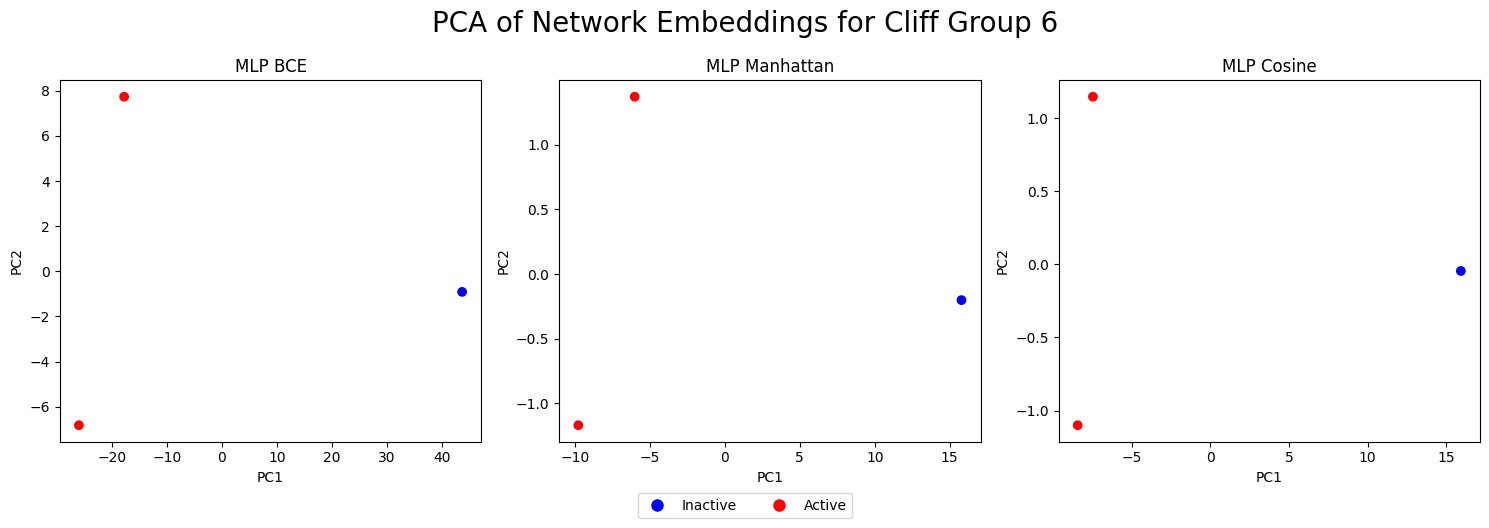

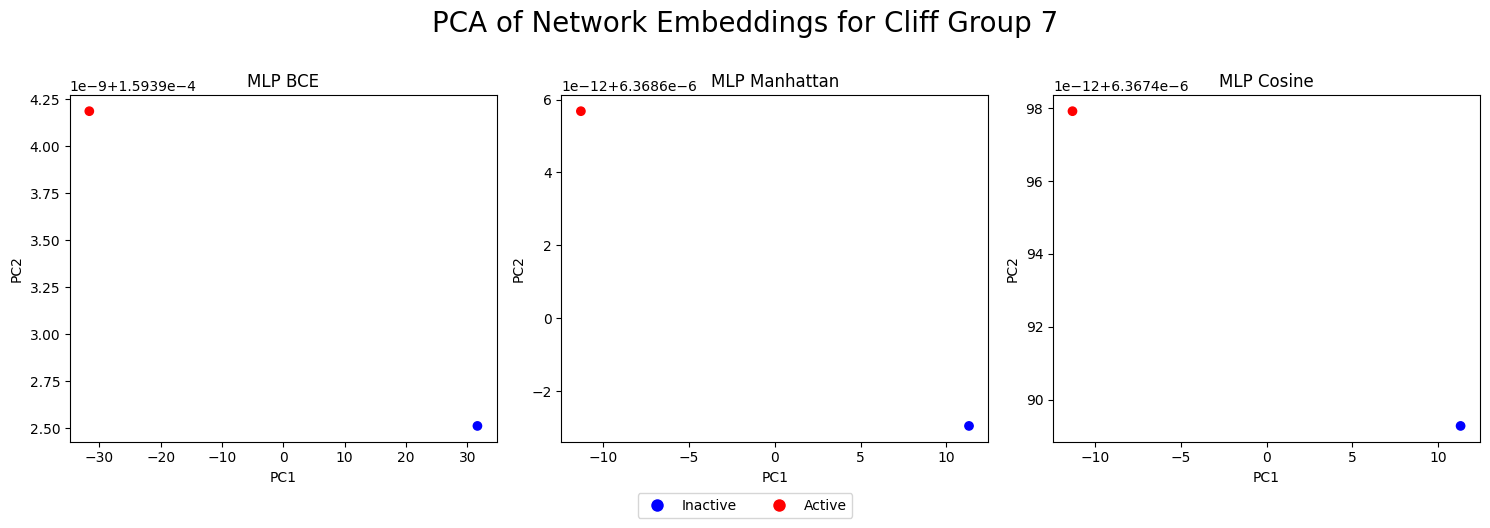

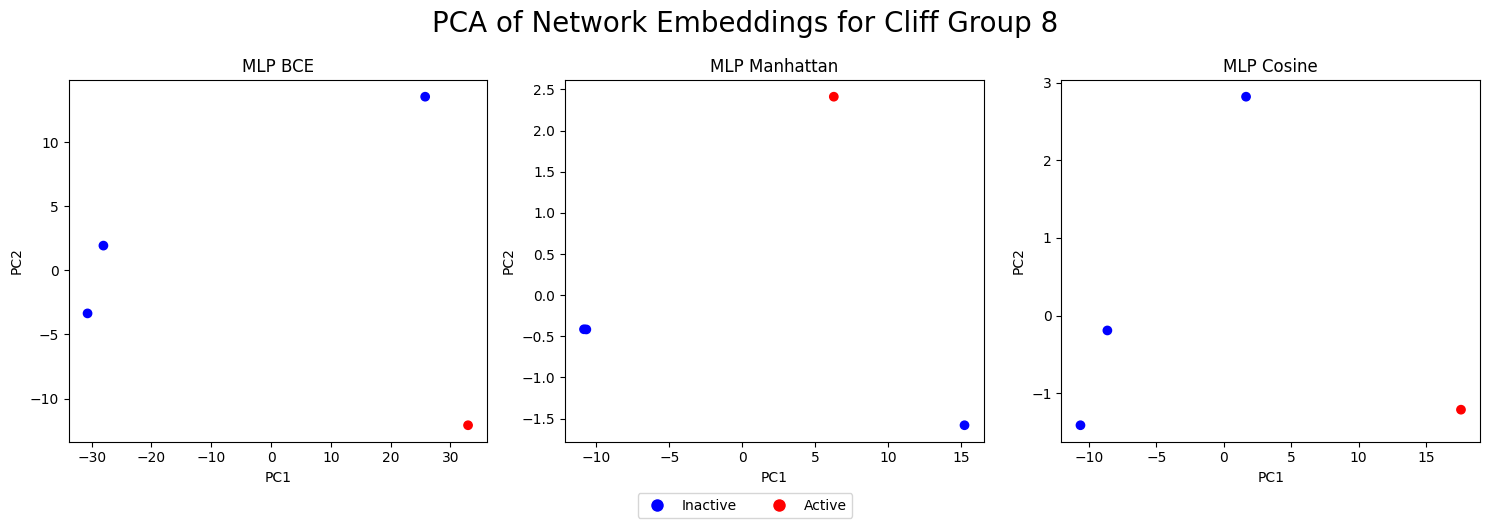

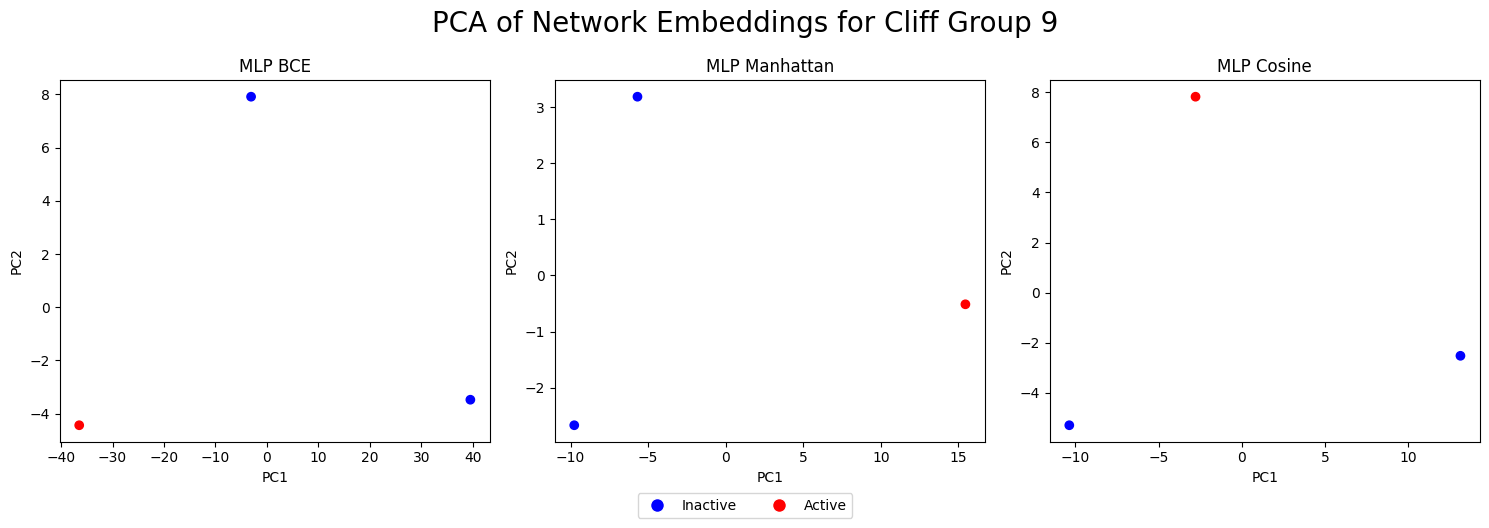

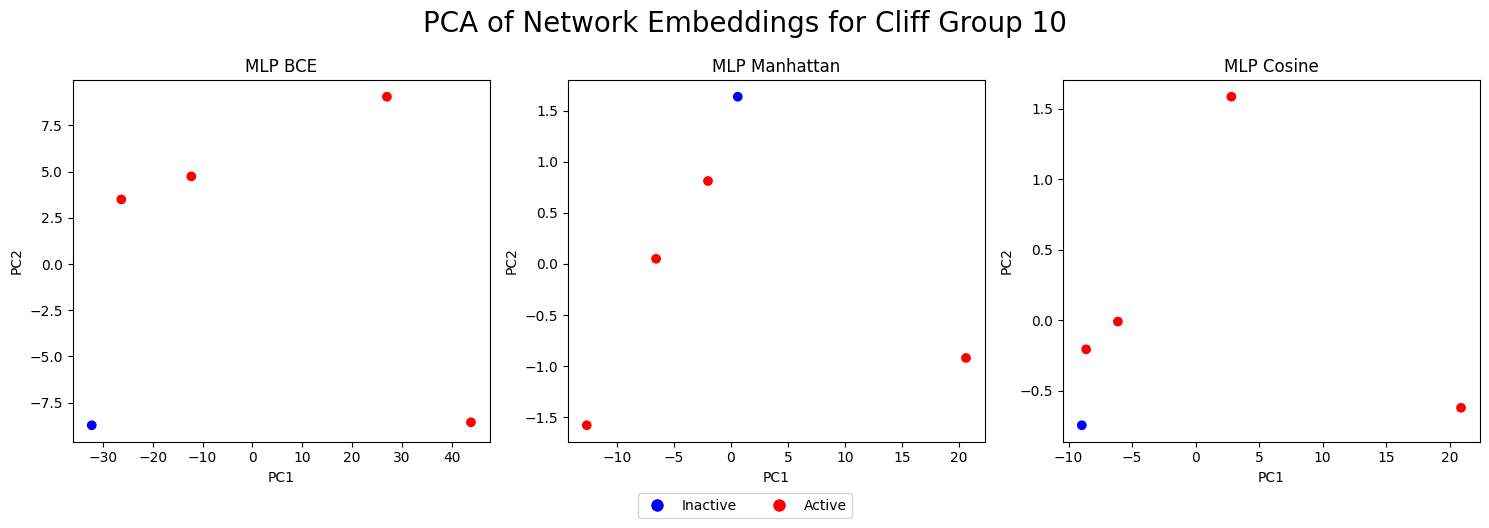

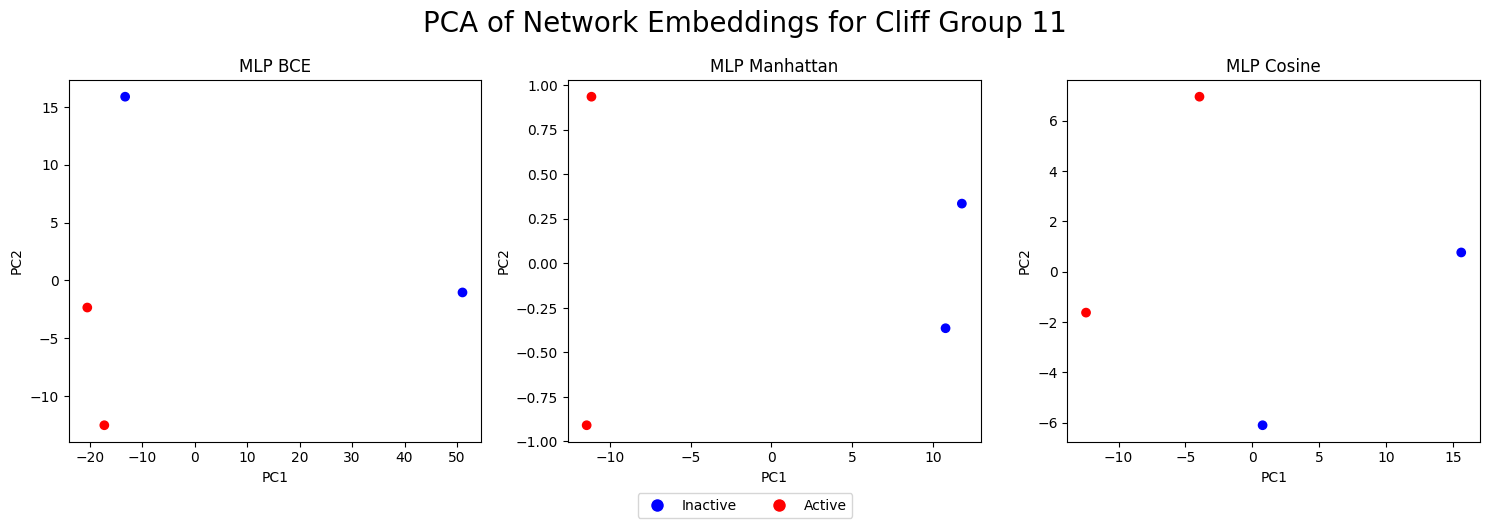

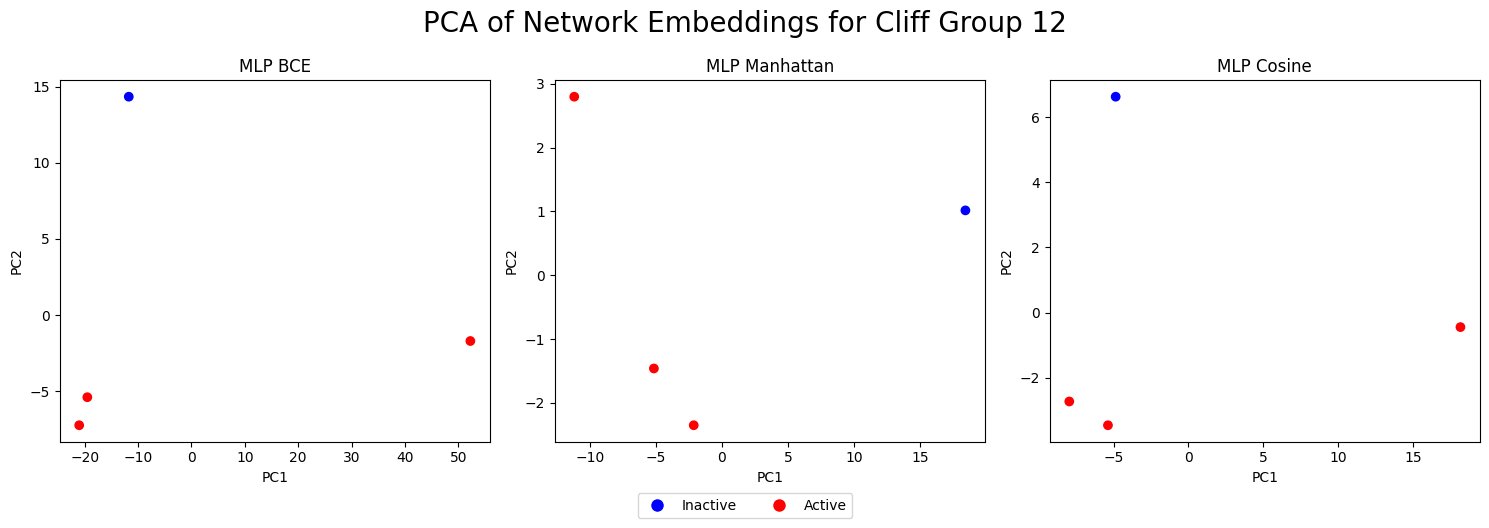

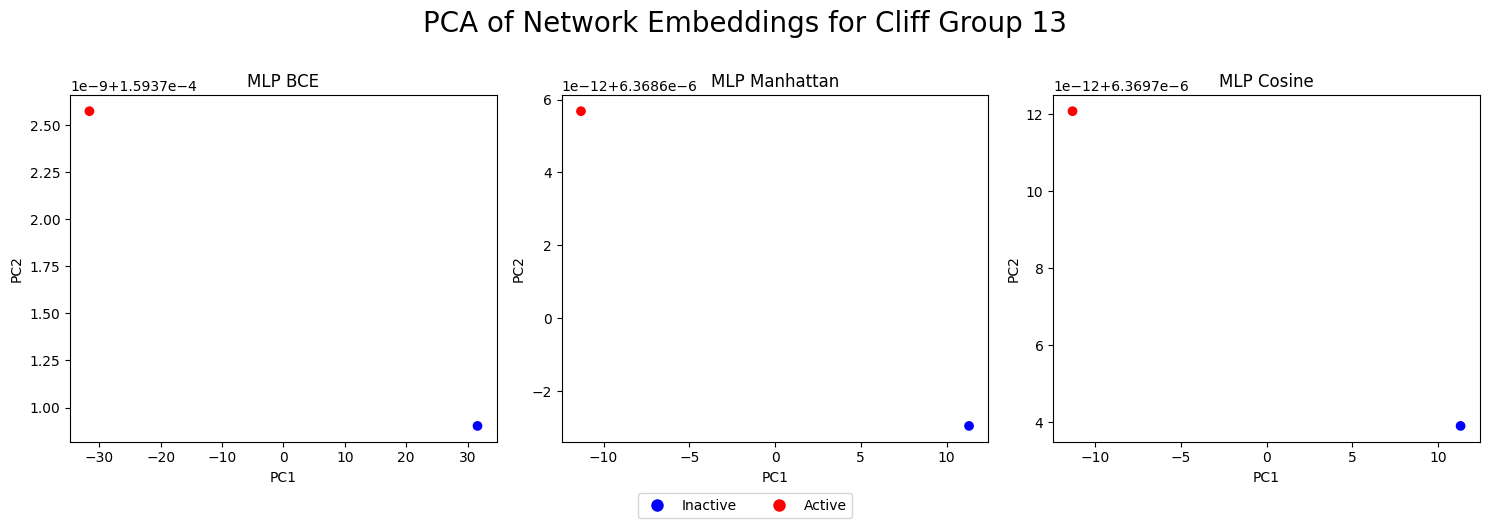

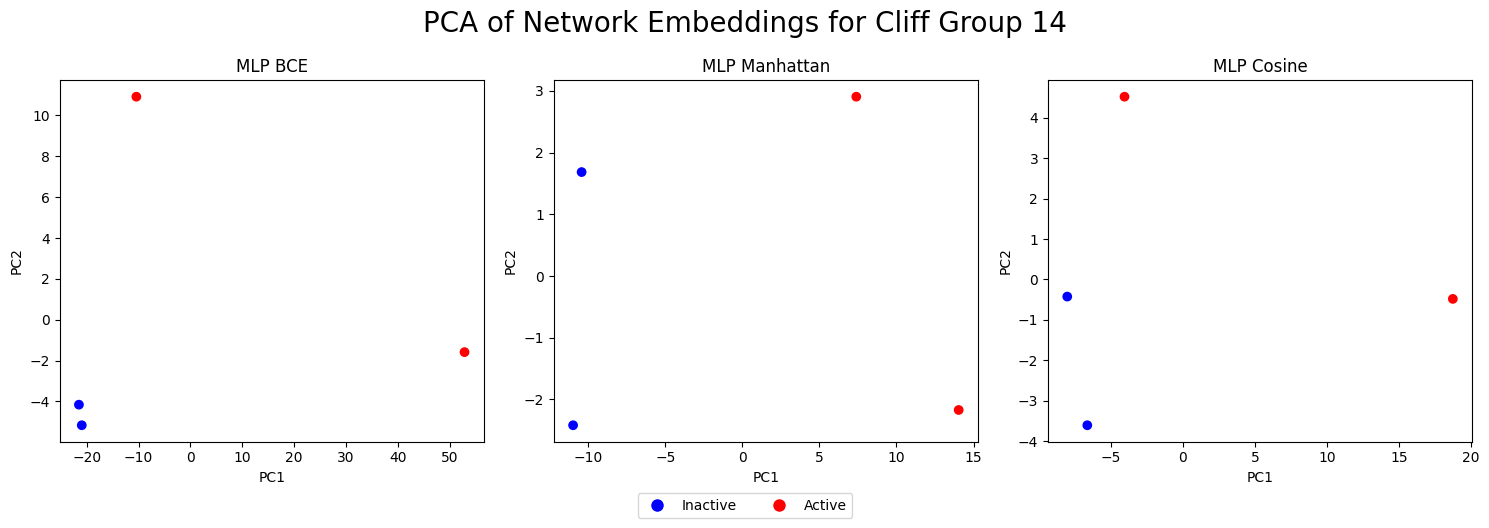

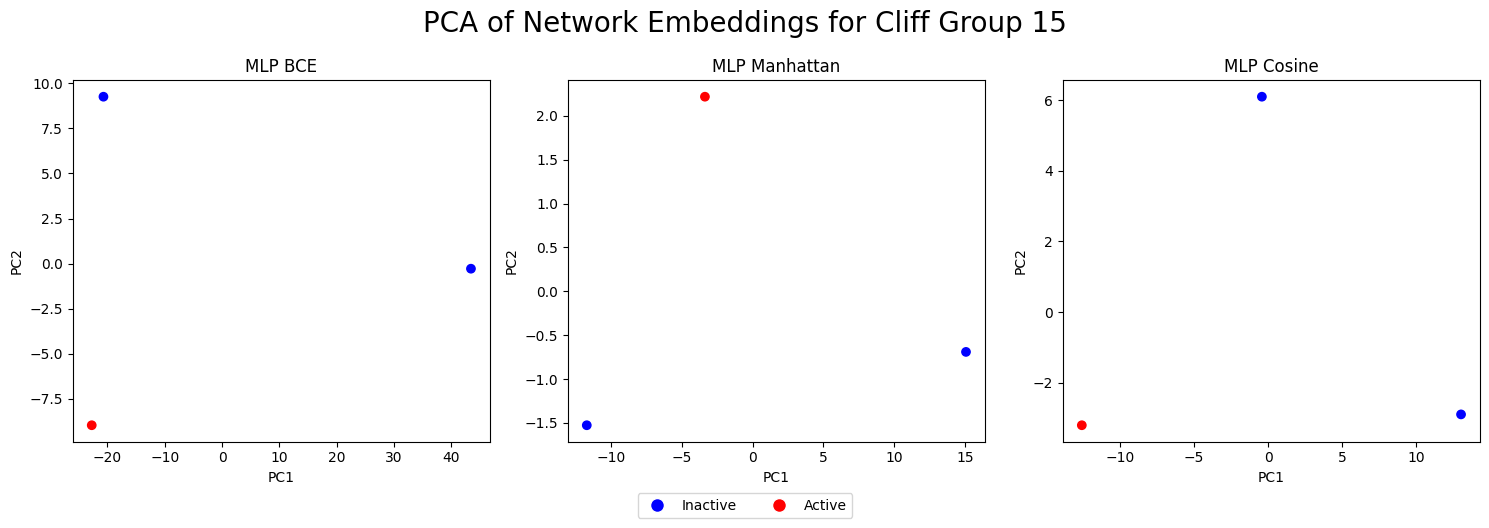

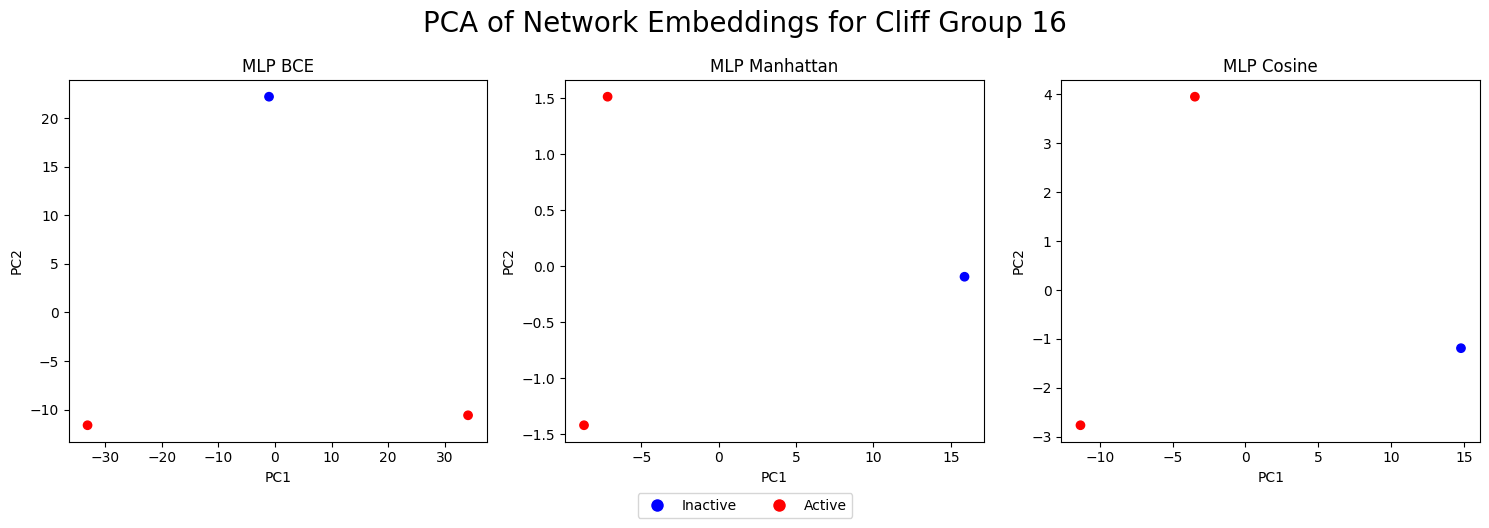

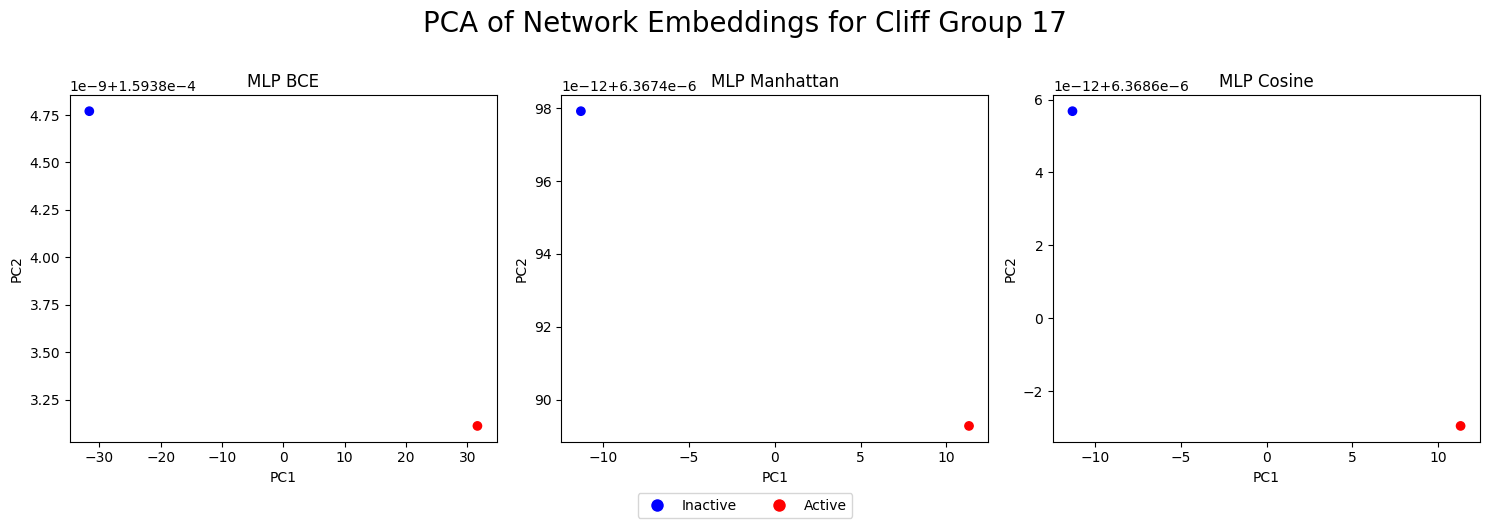

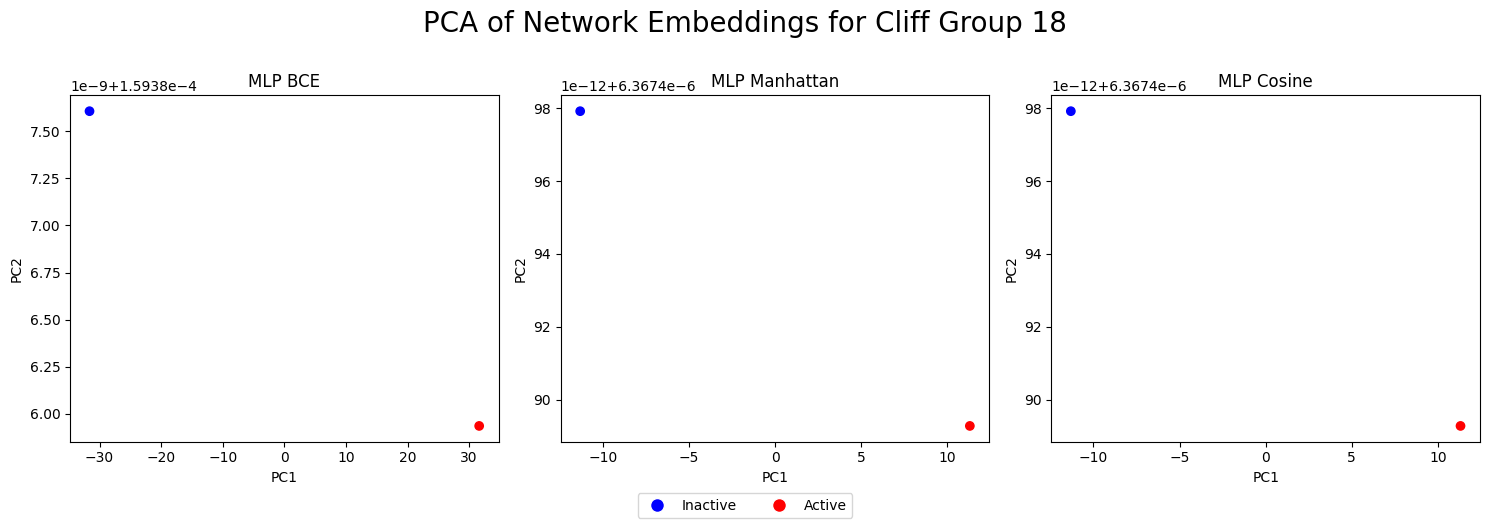

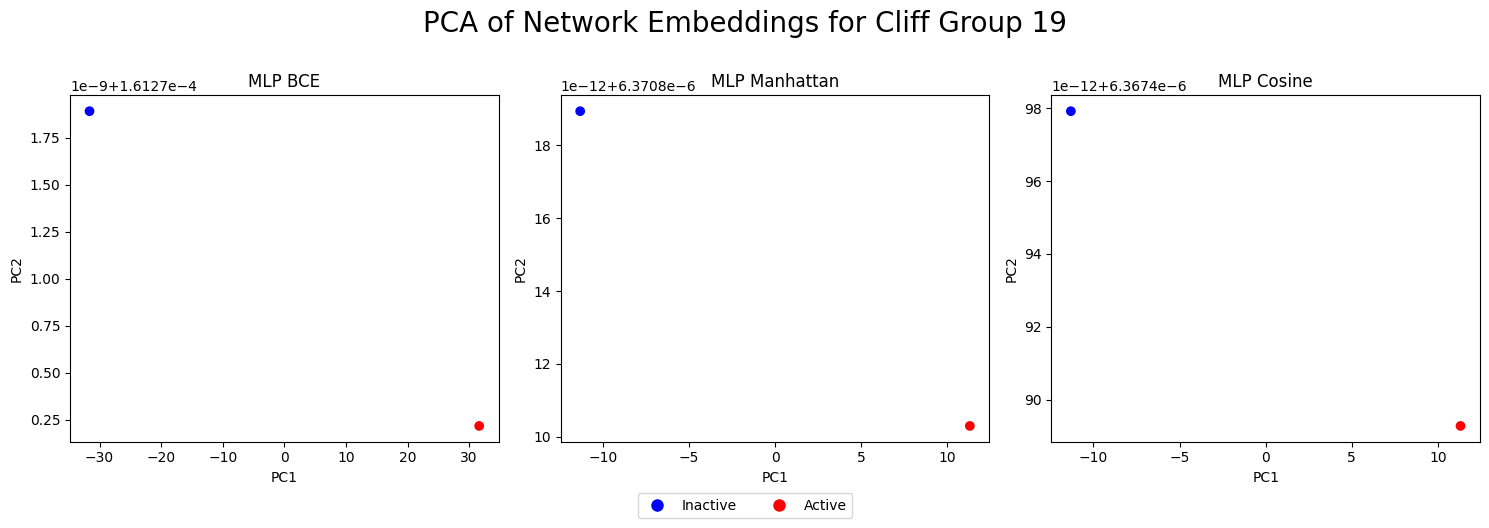

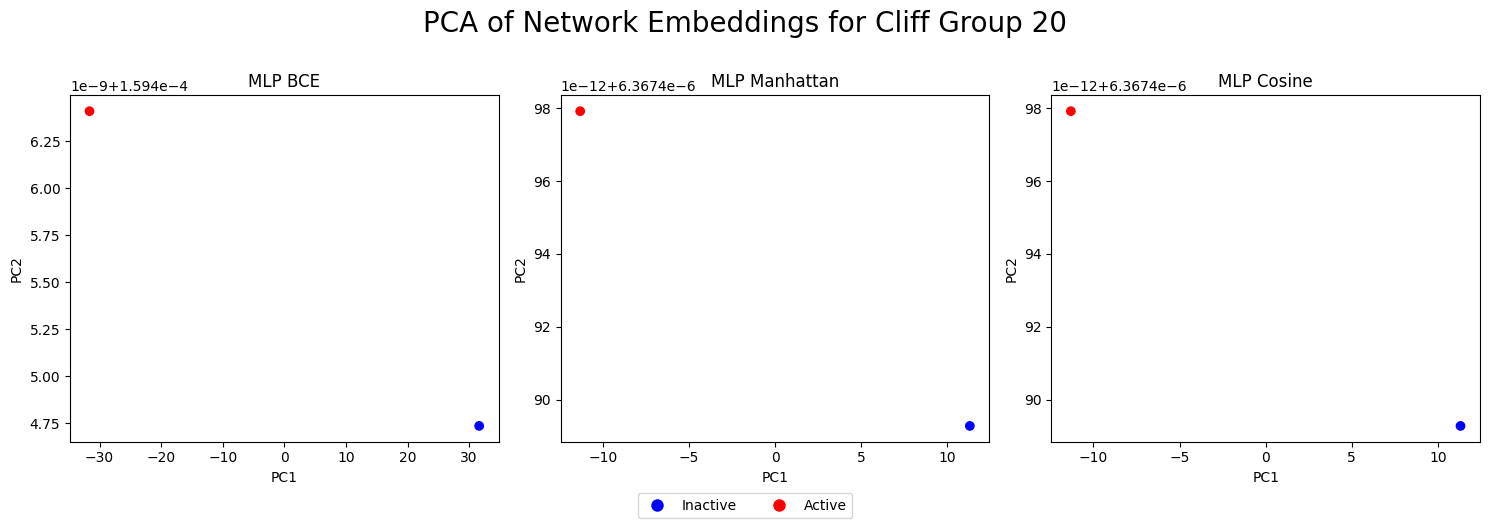

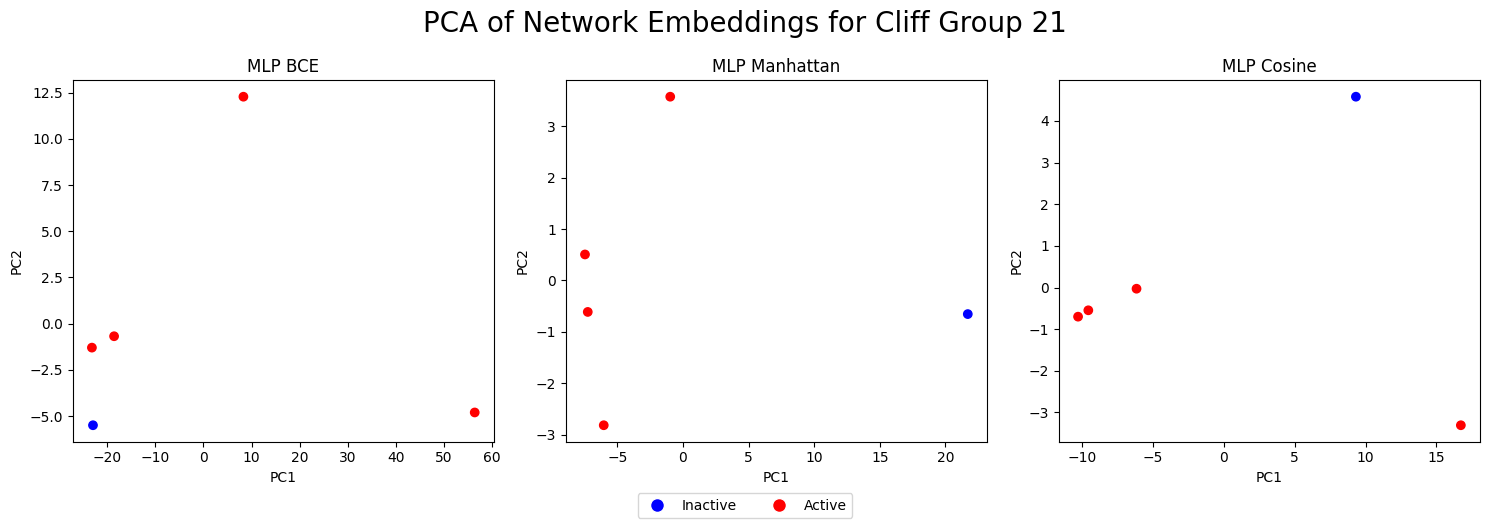

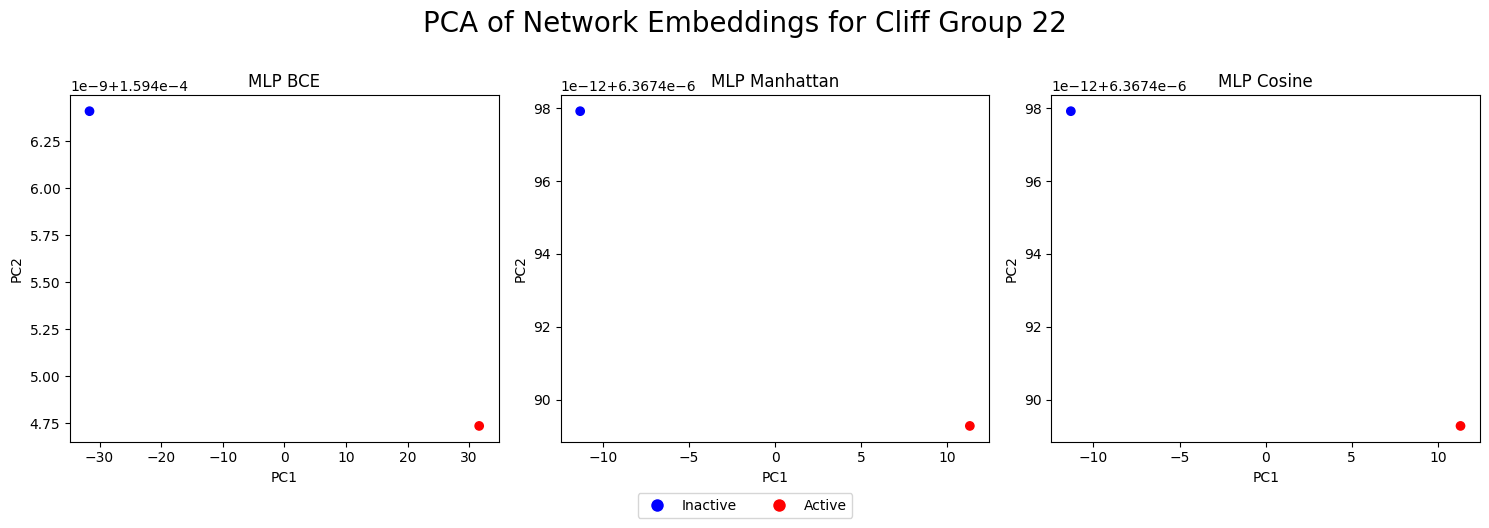

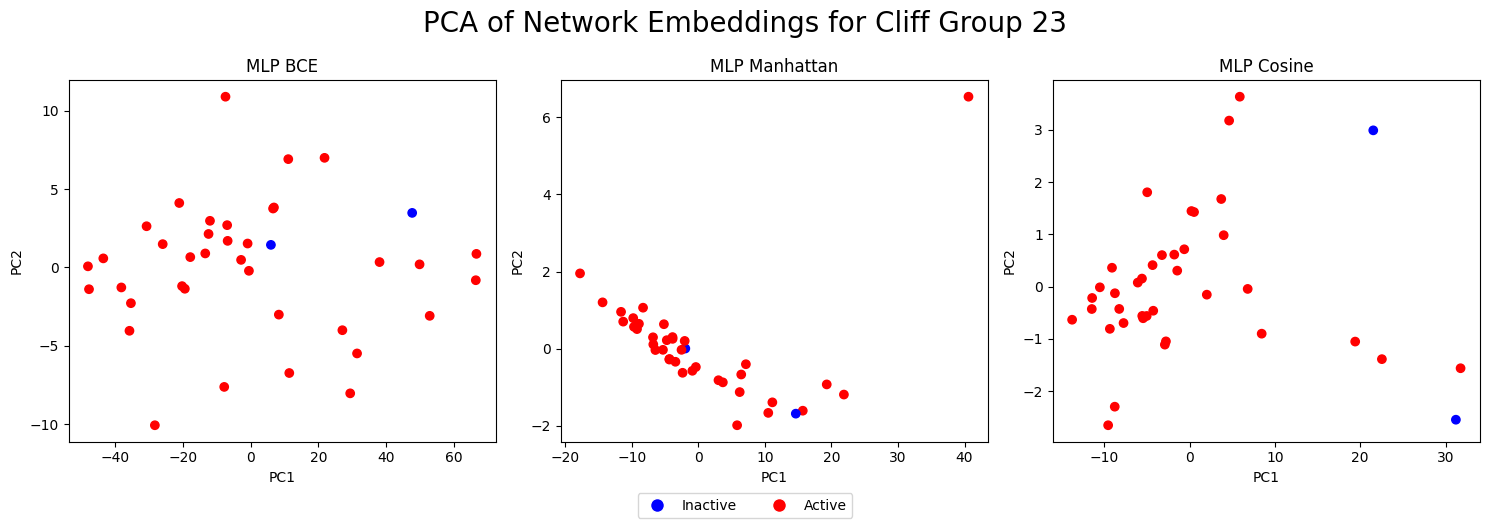

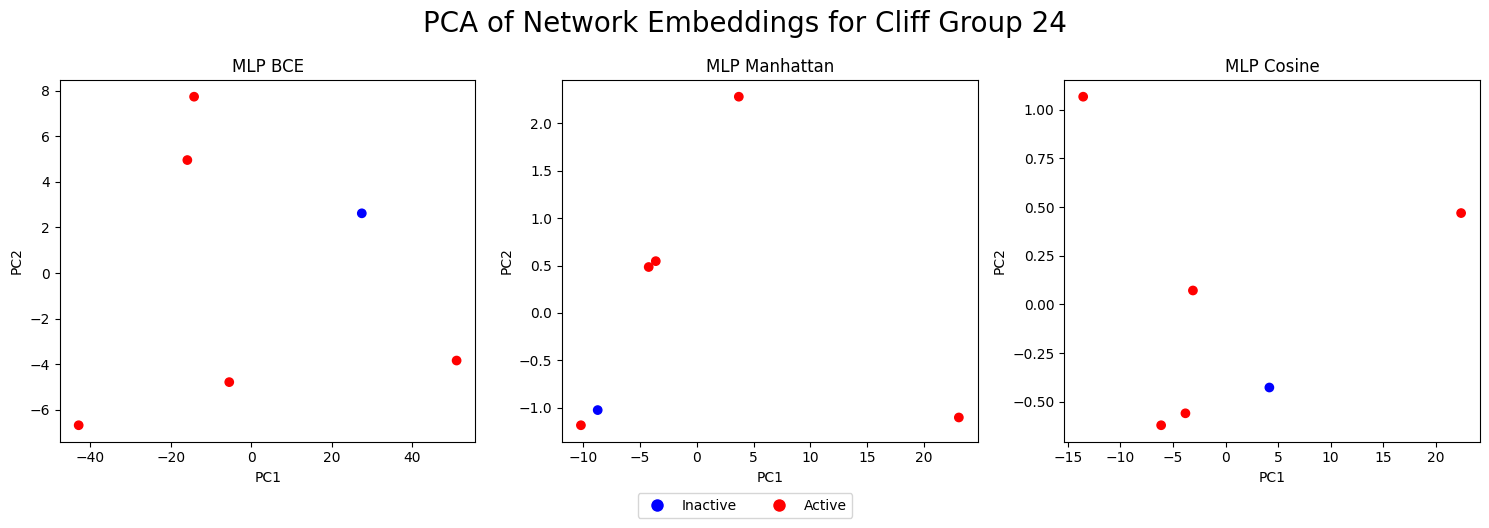

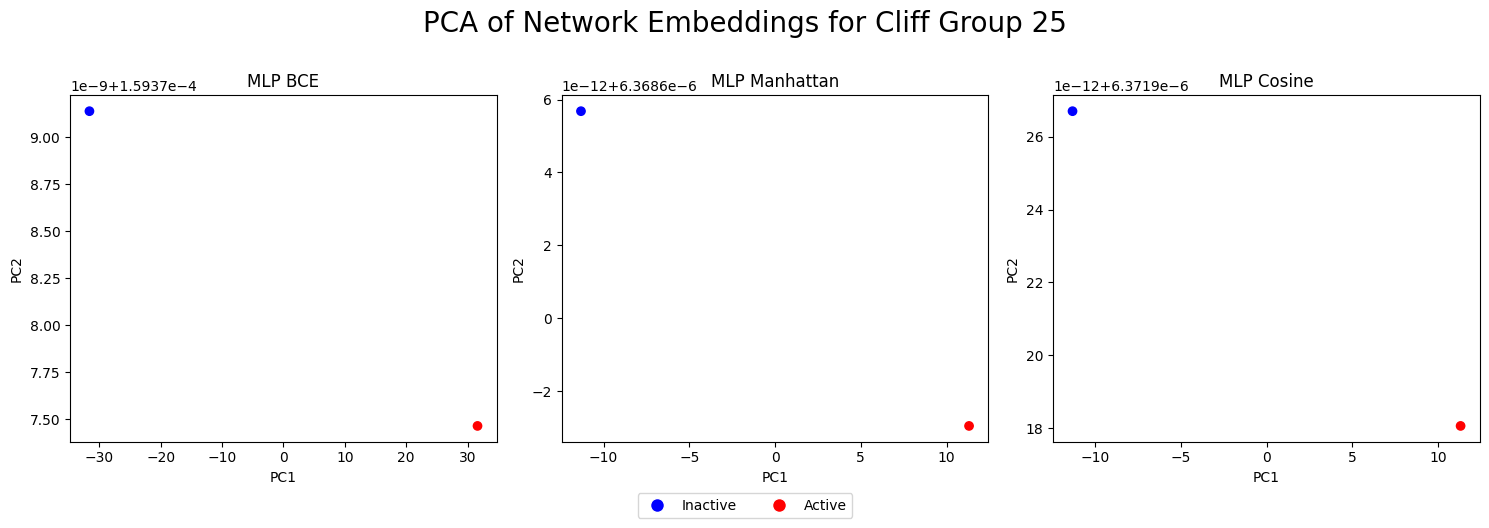

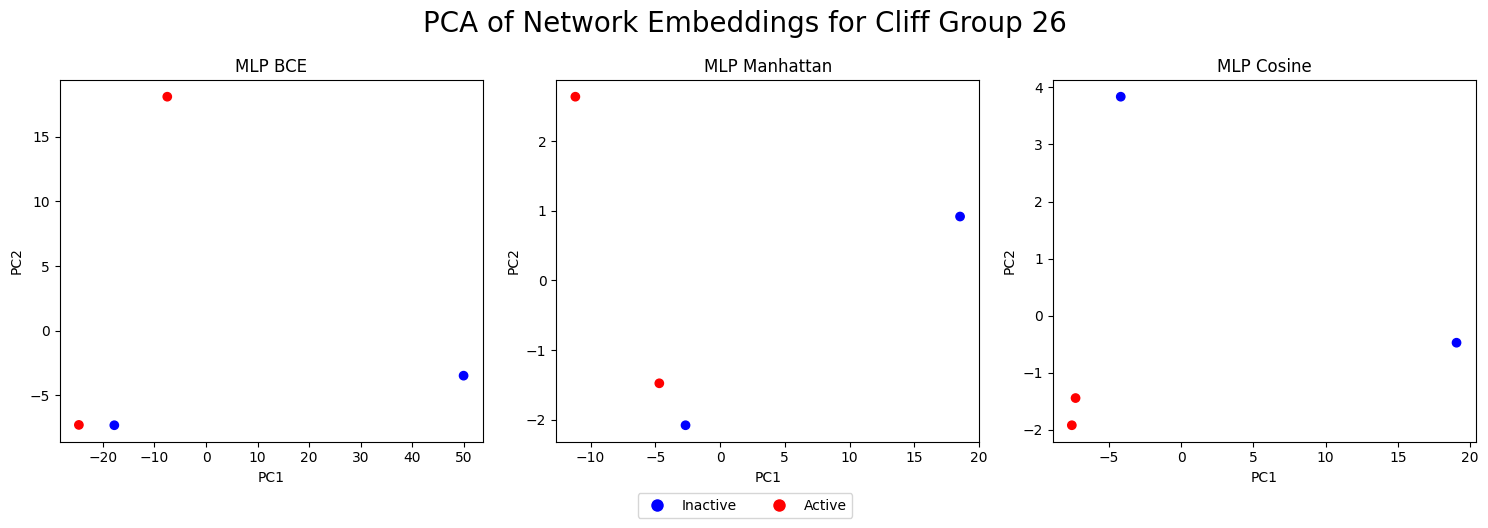

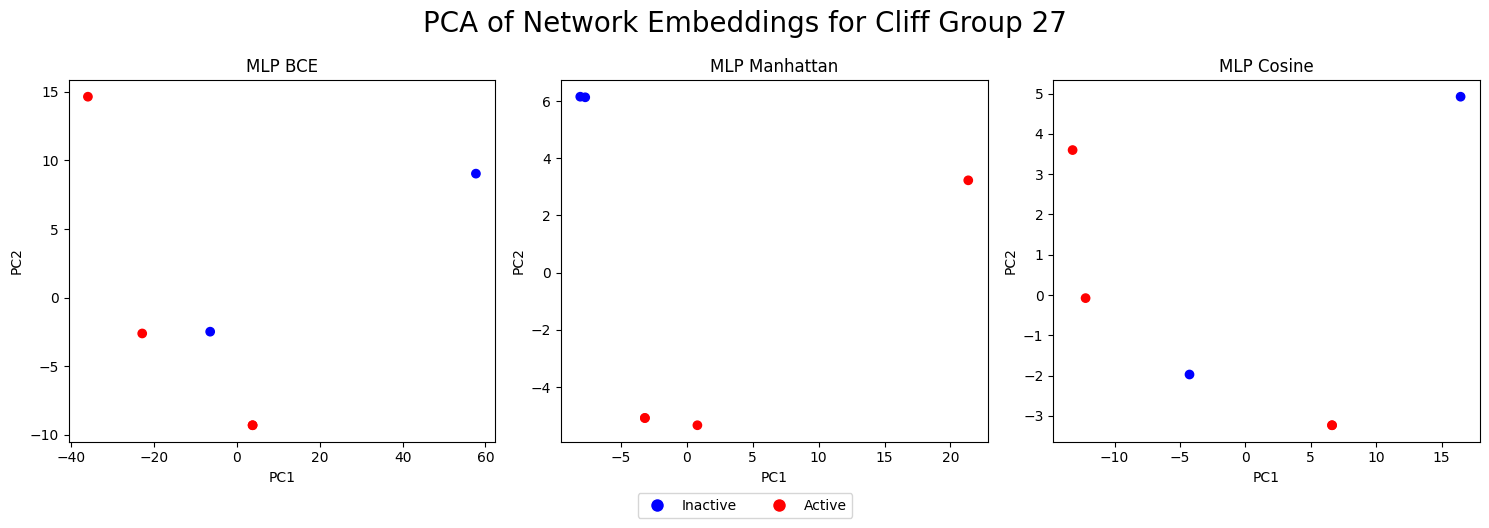

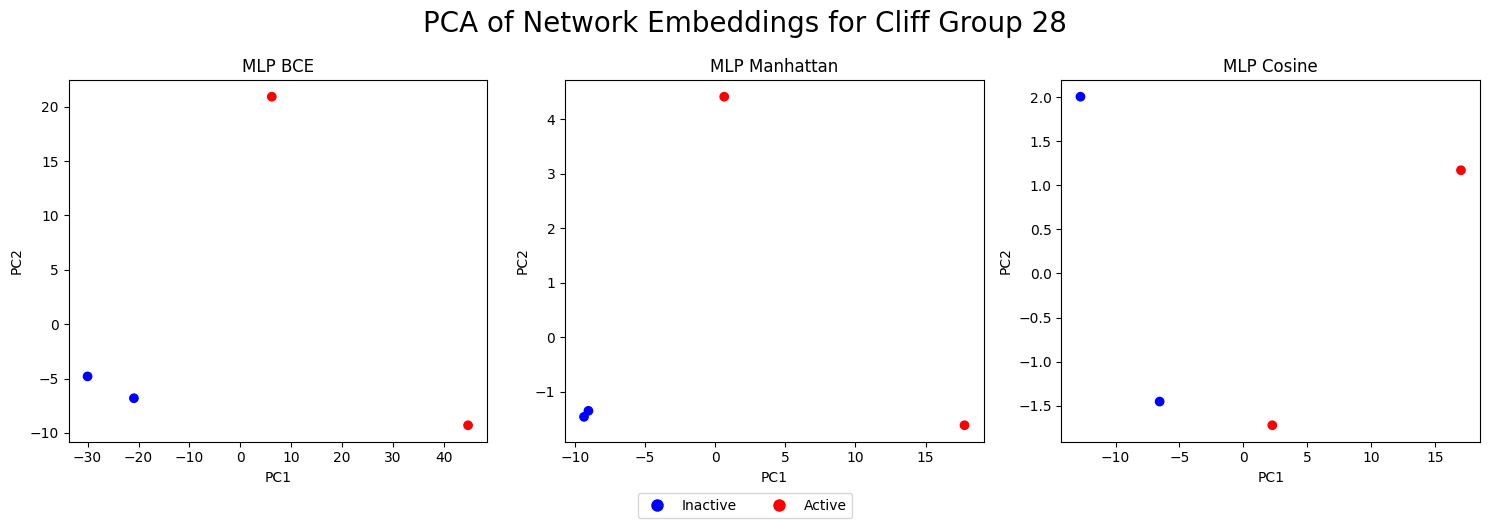

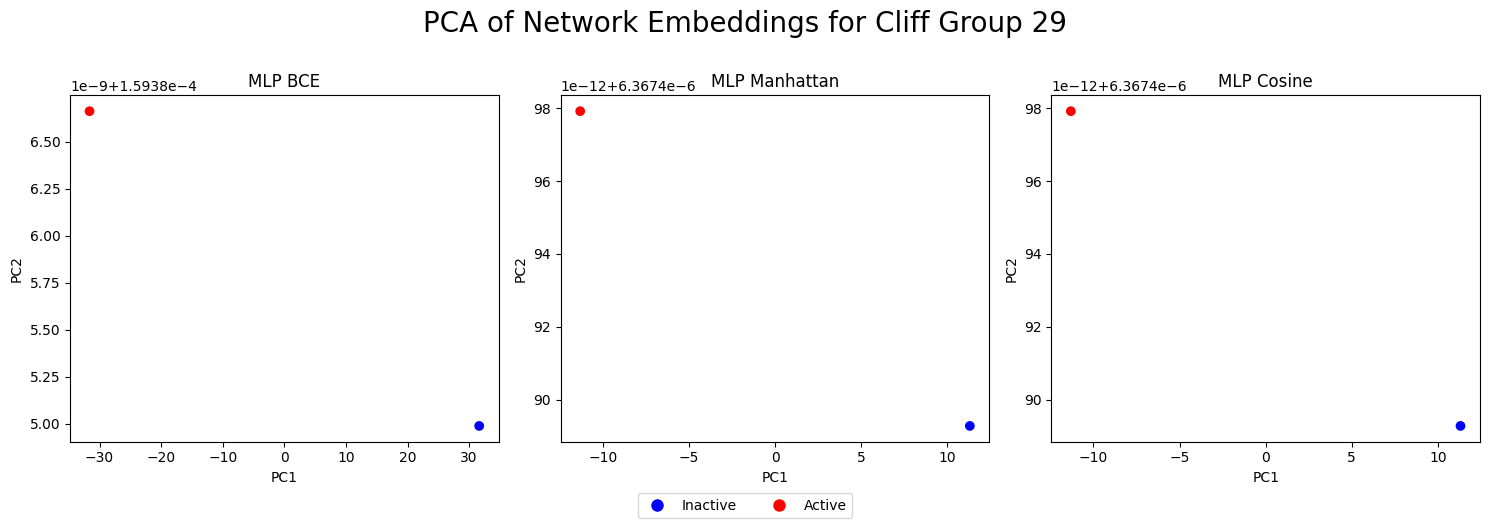

In [12]:
for i in range(len(group_dict)):
    plot_pca(group_id=i, seed=68)

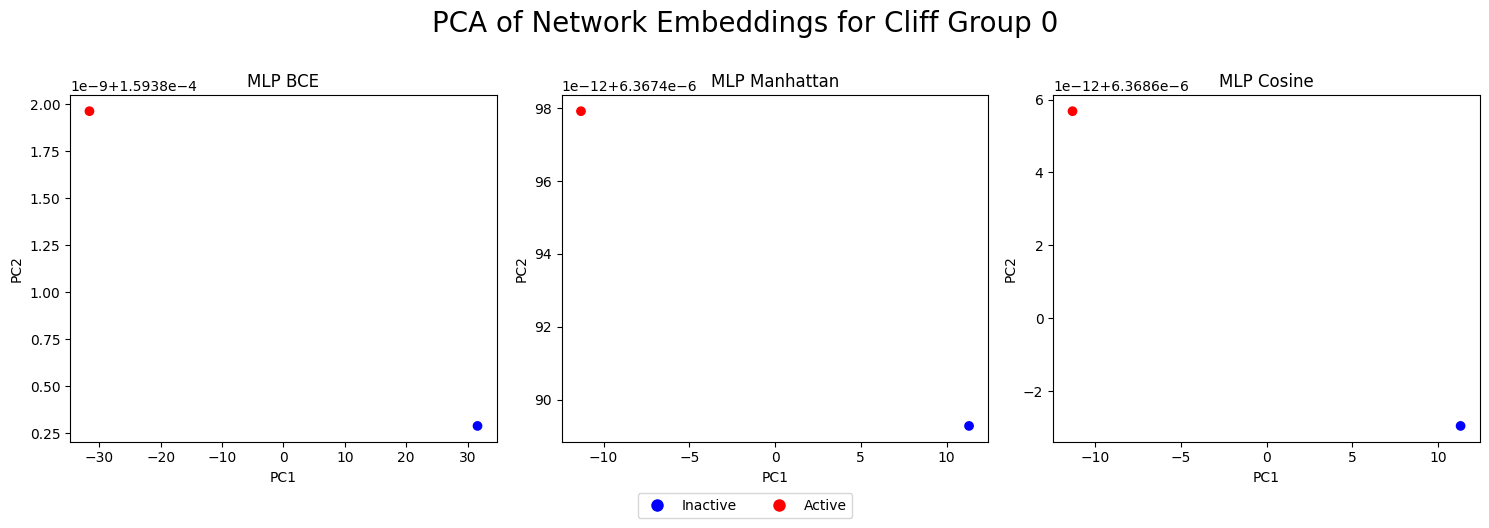

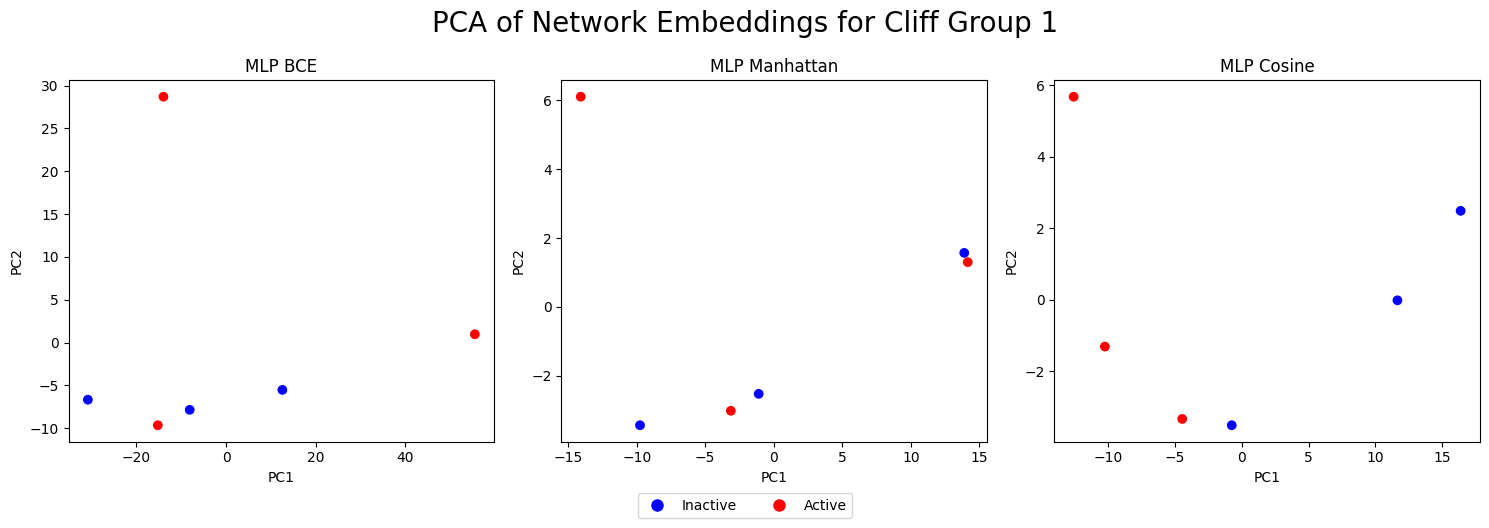

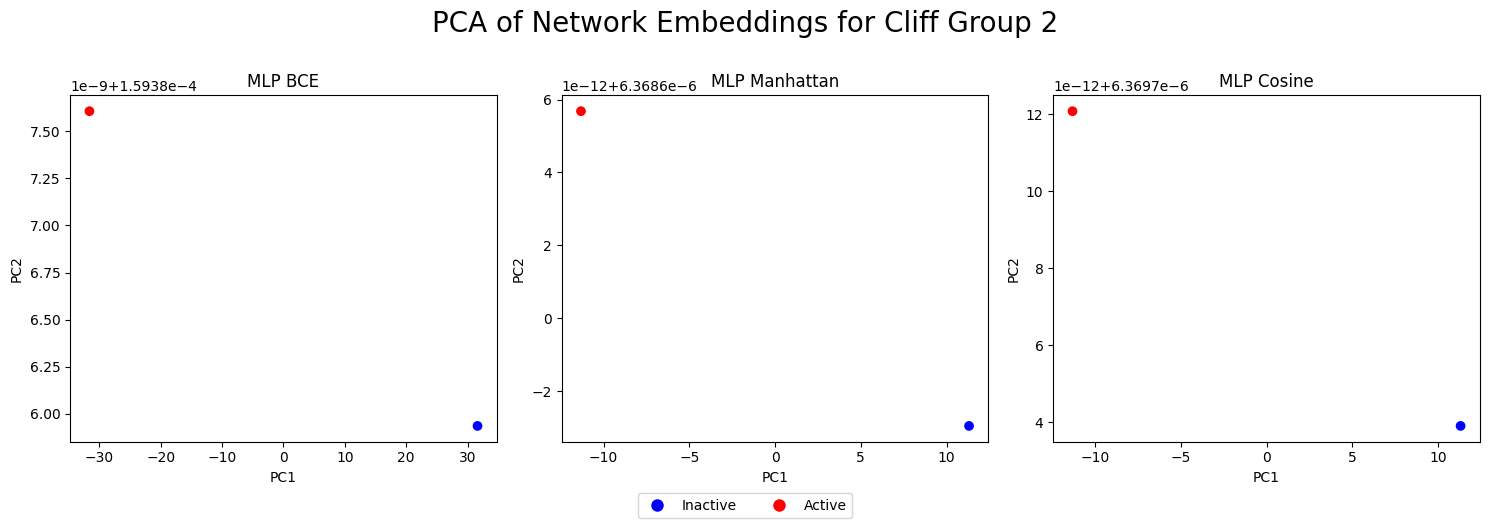

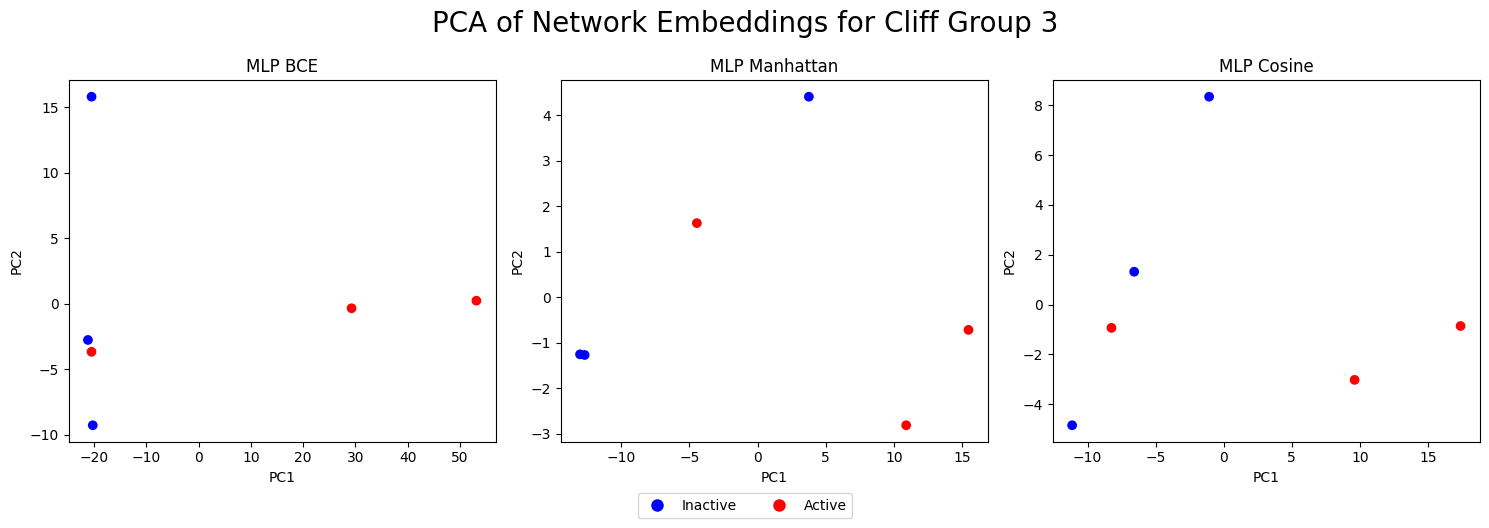

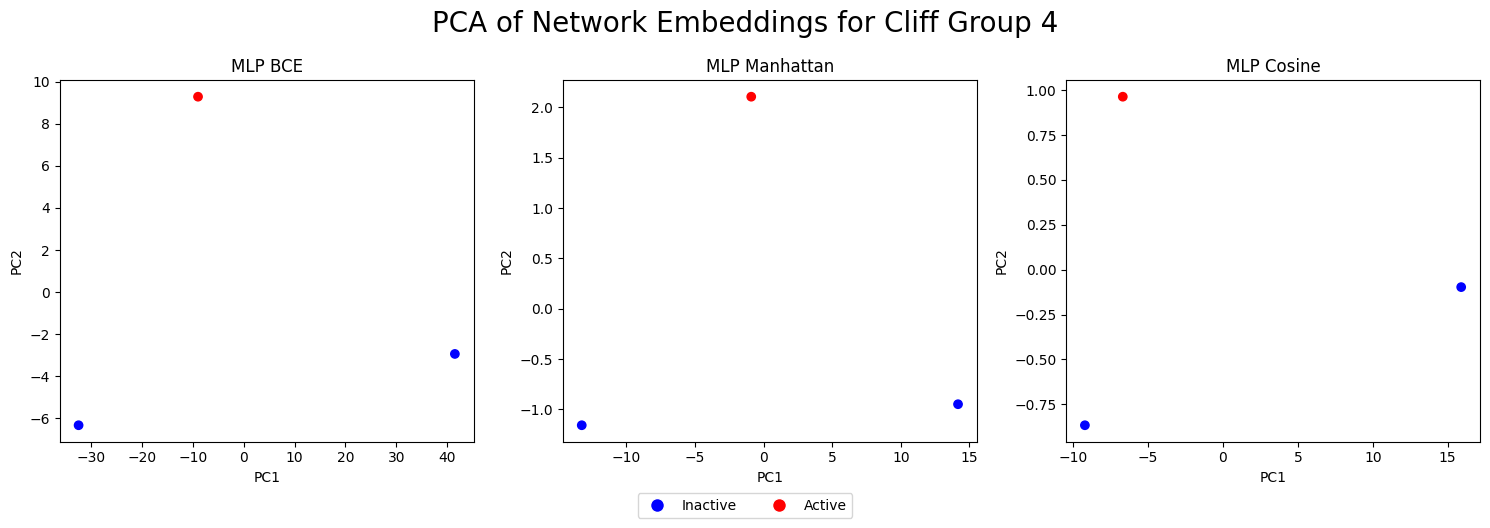

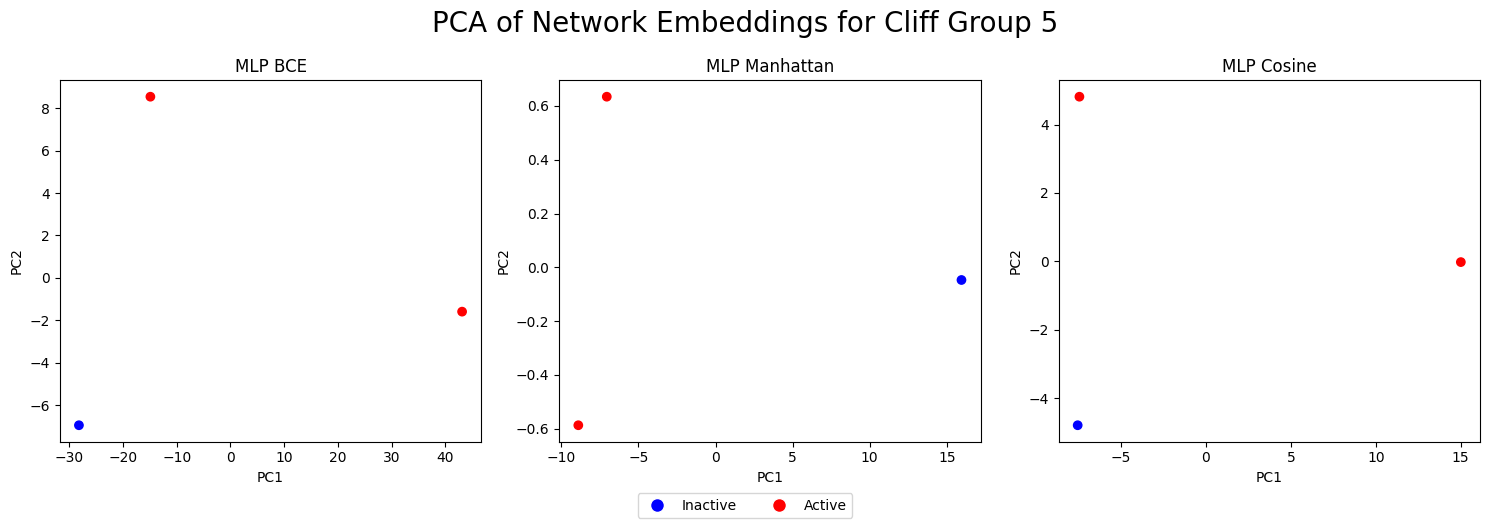

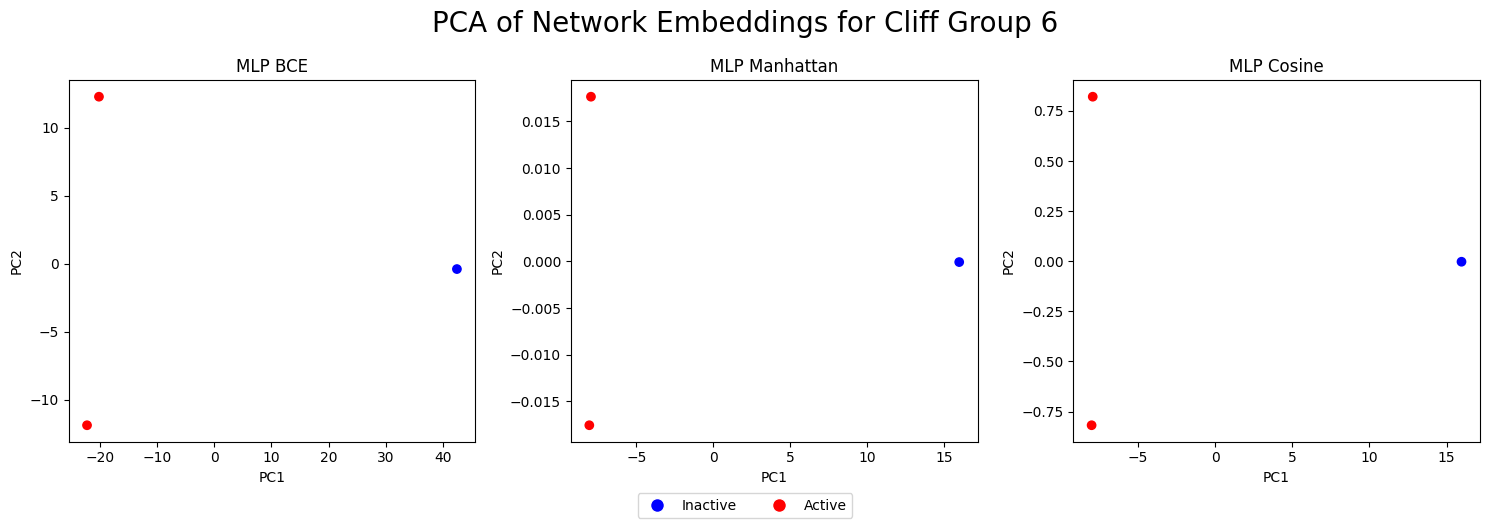

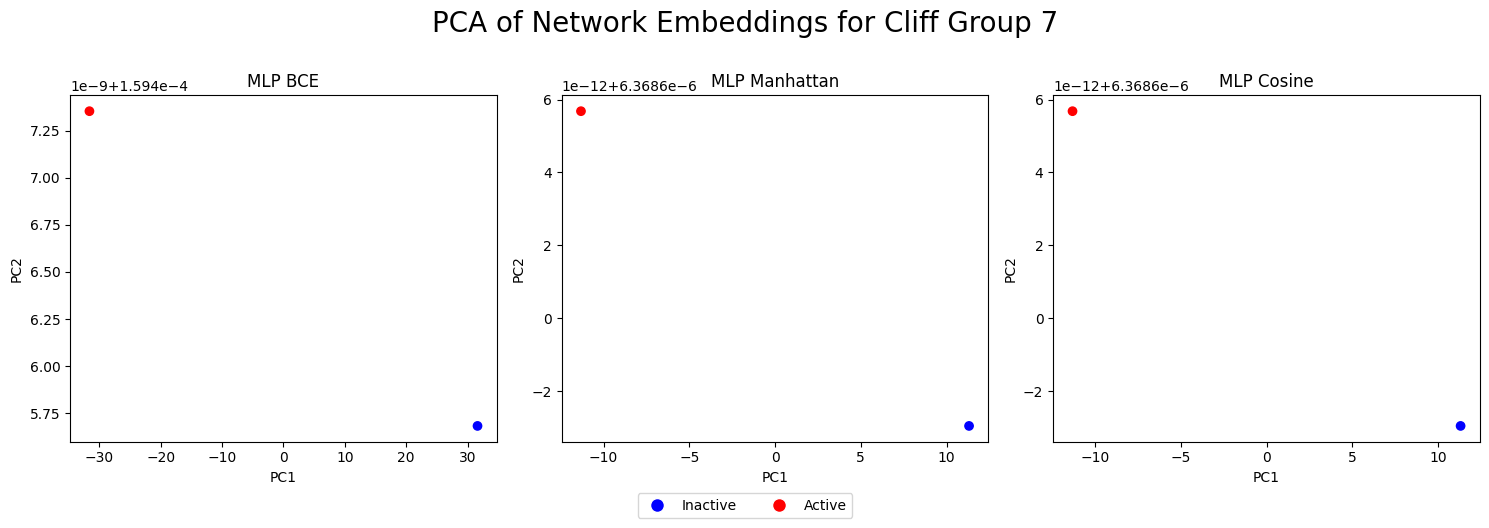

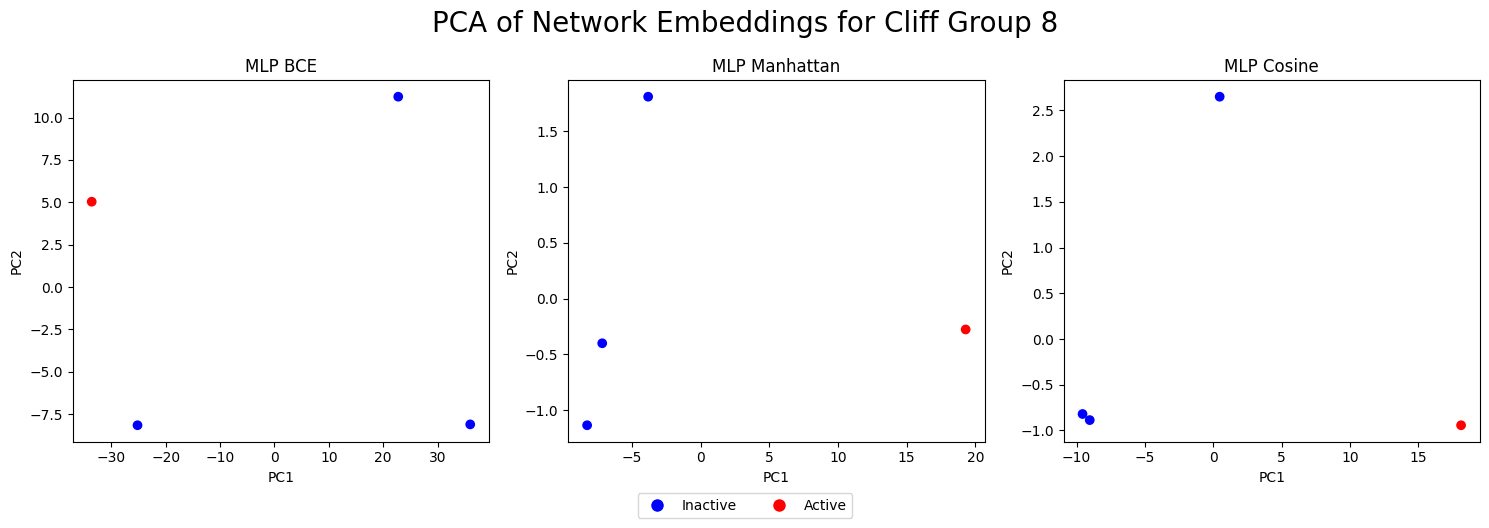

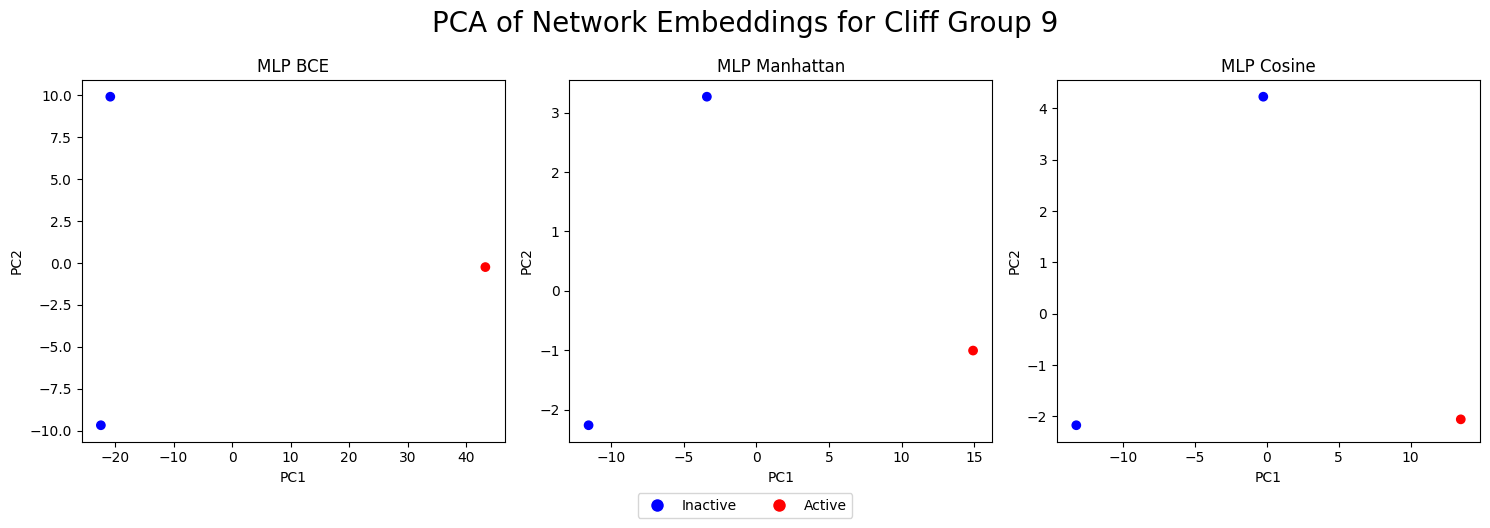

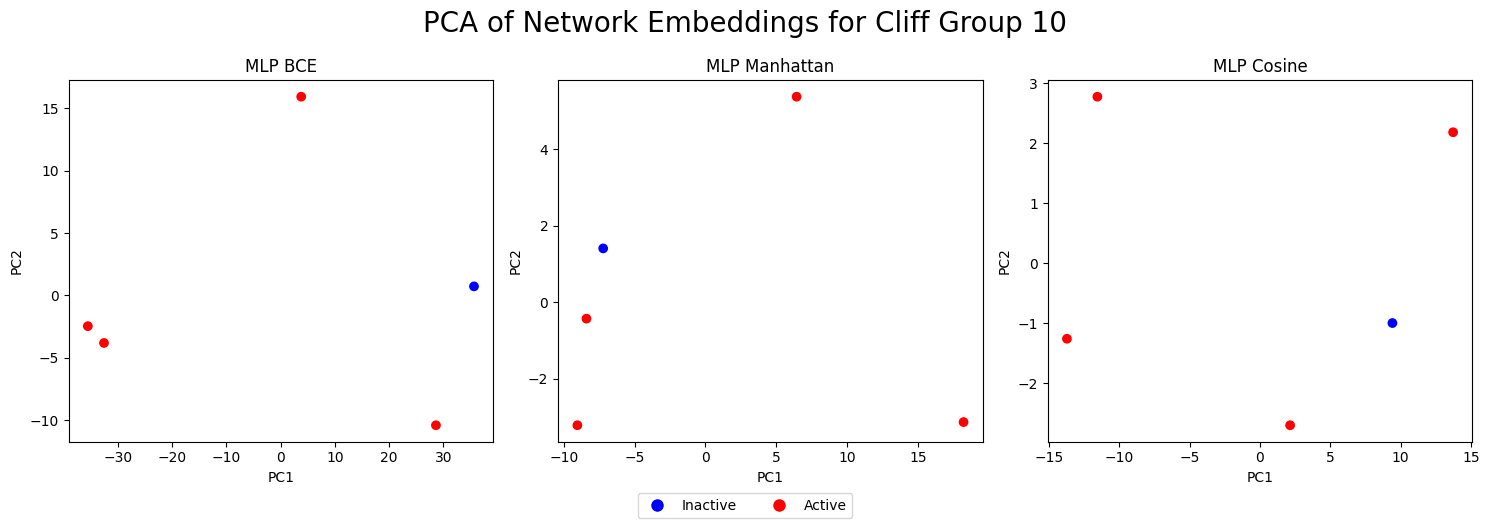

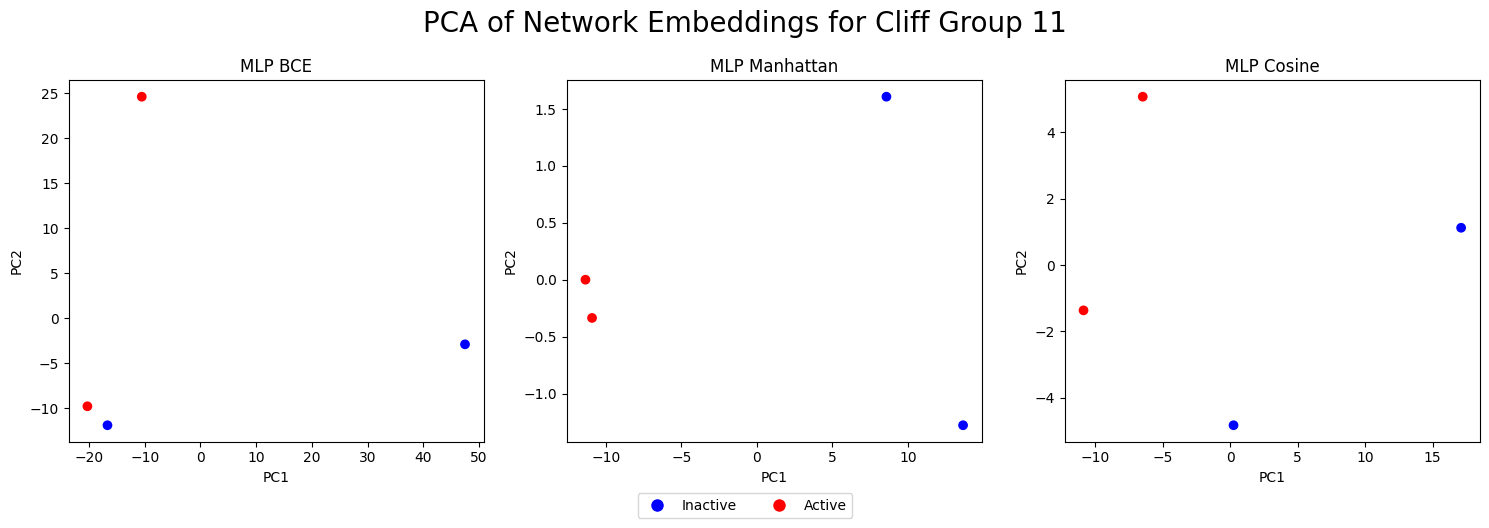

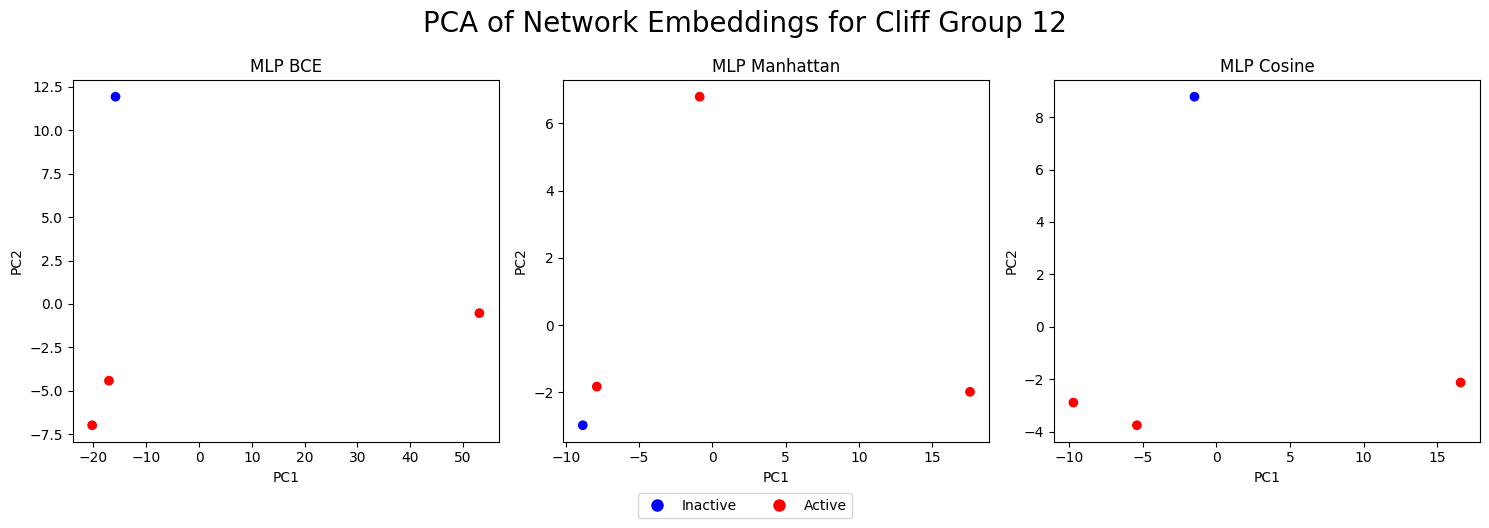

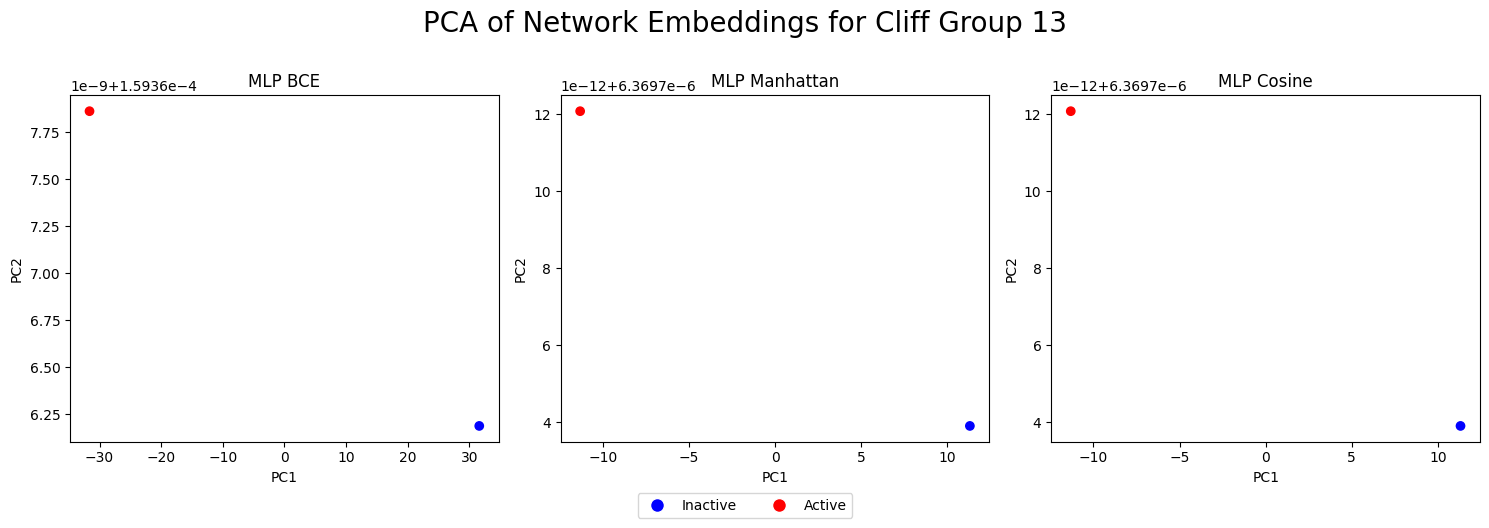

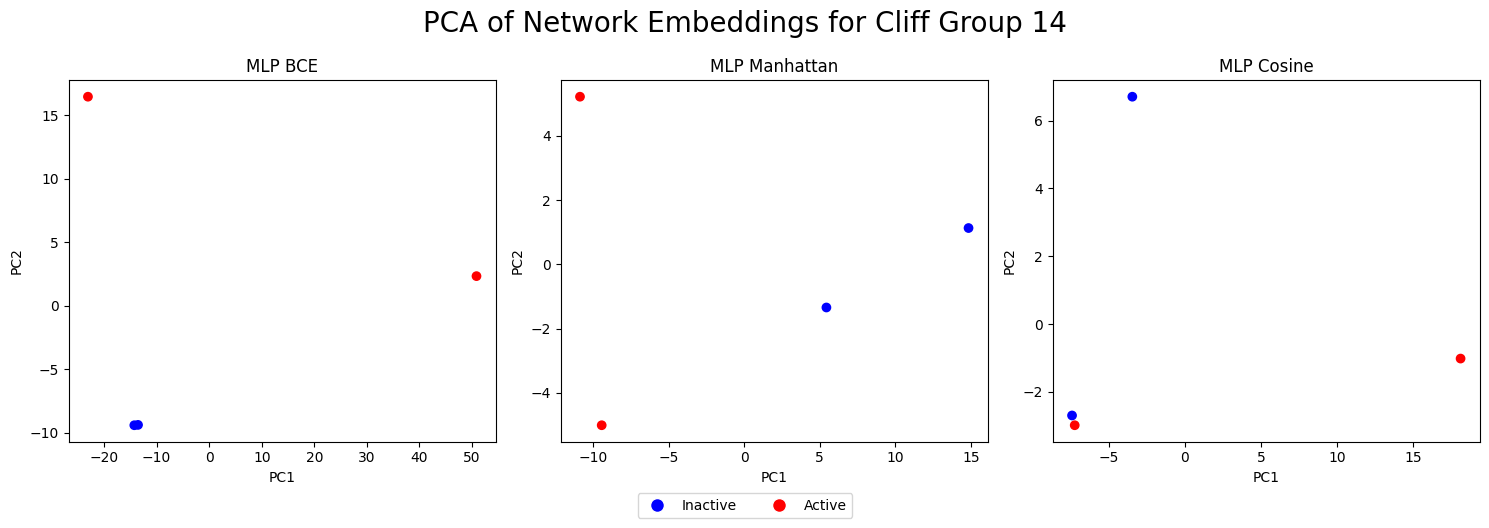

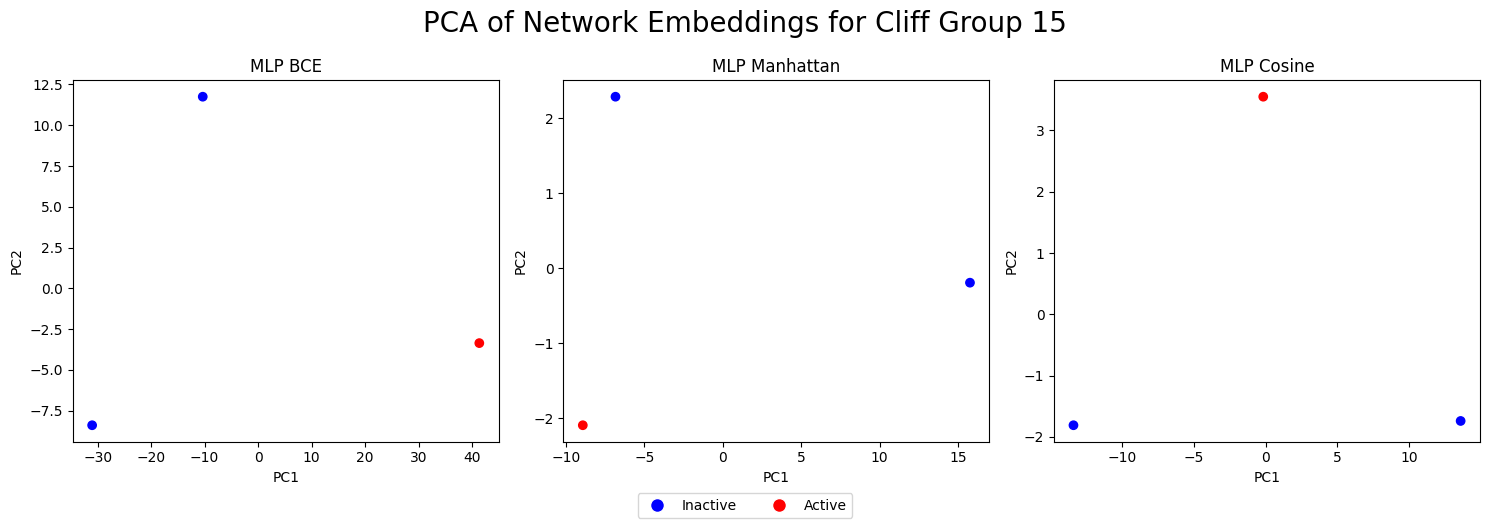

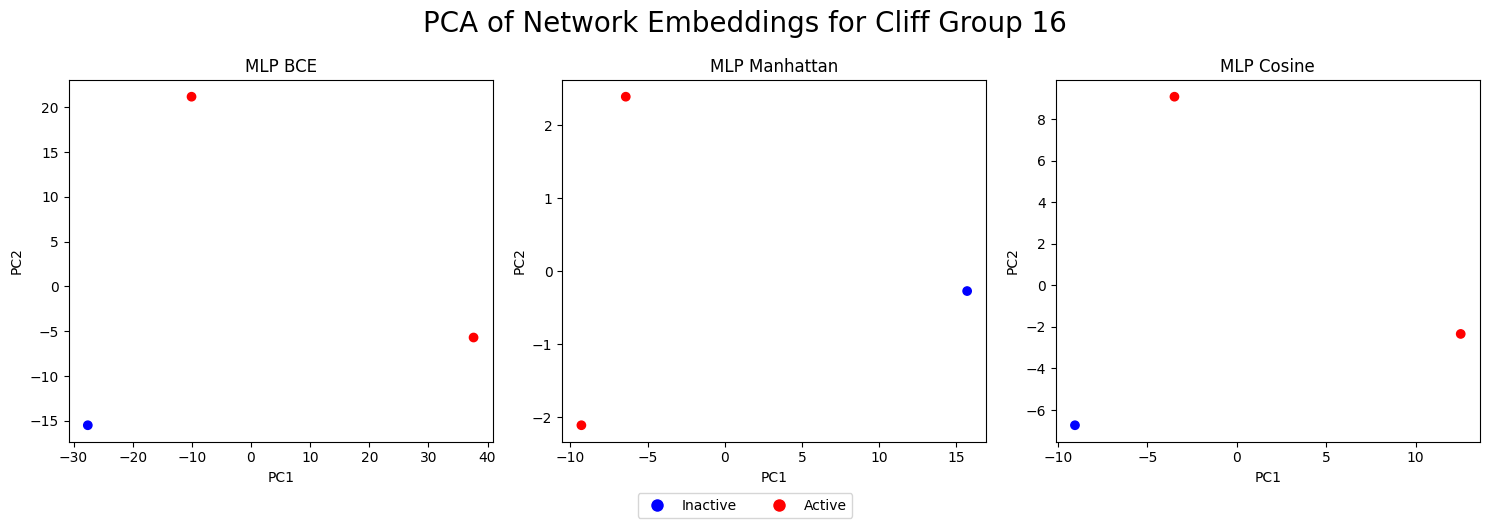

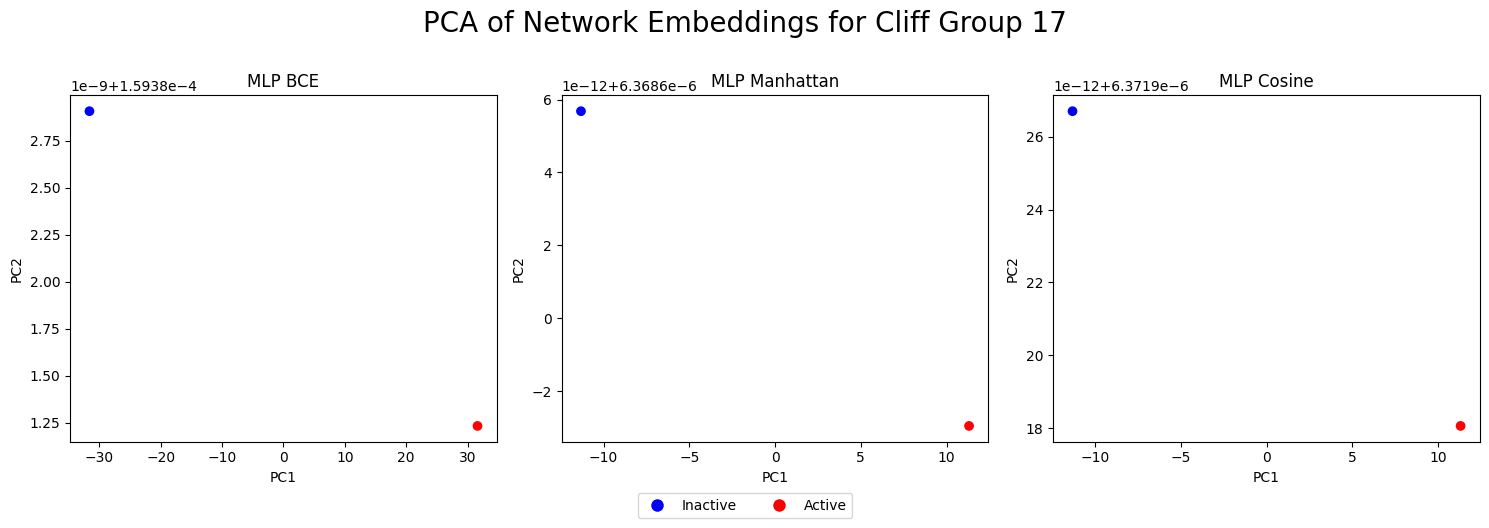

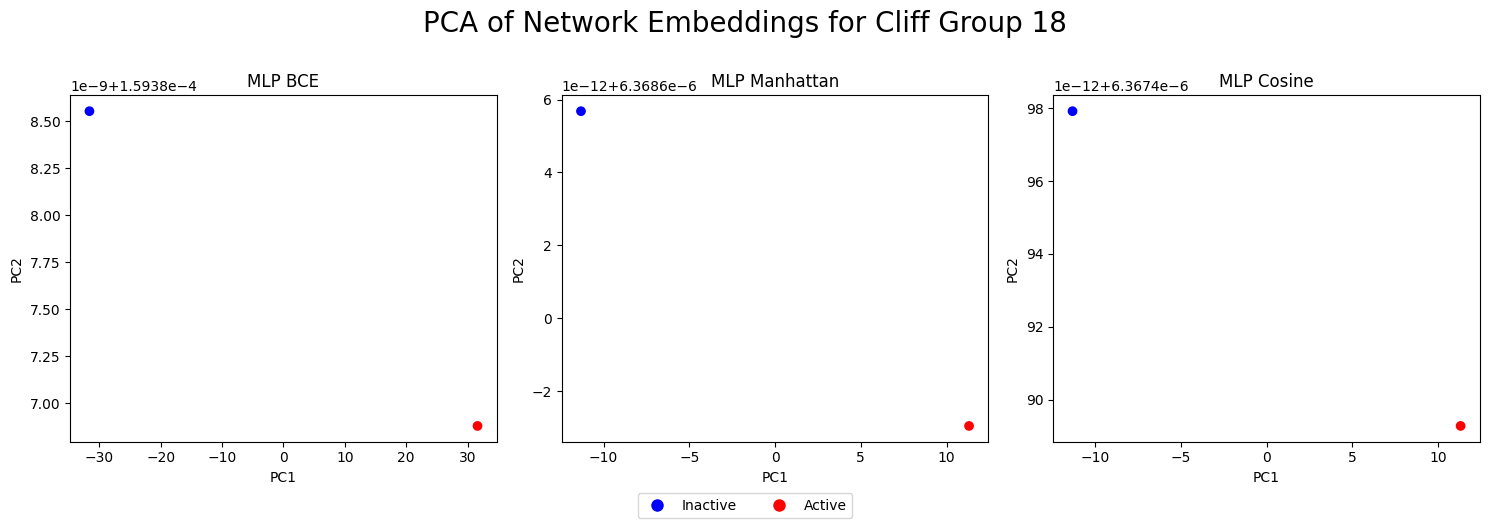

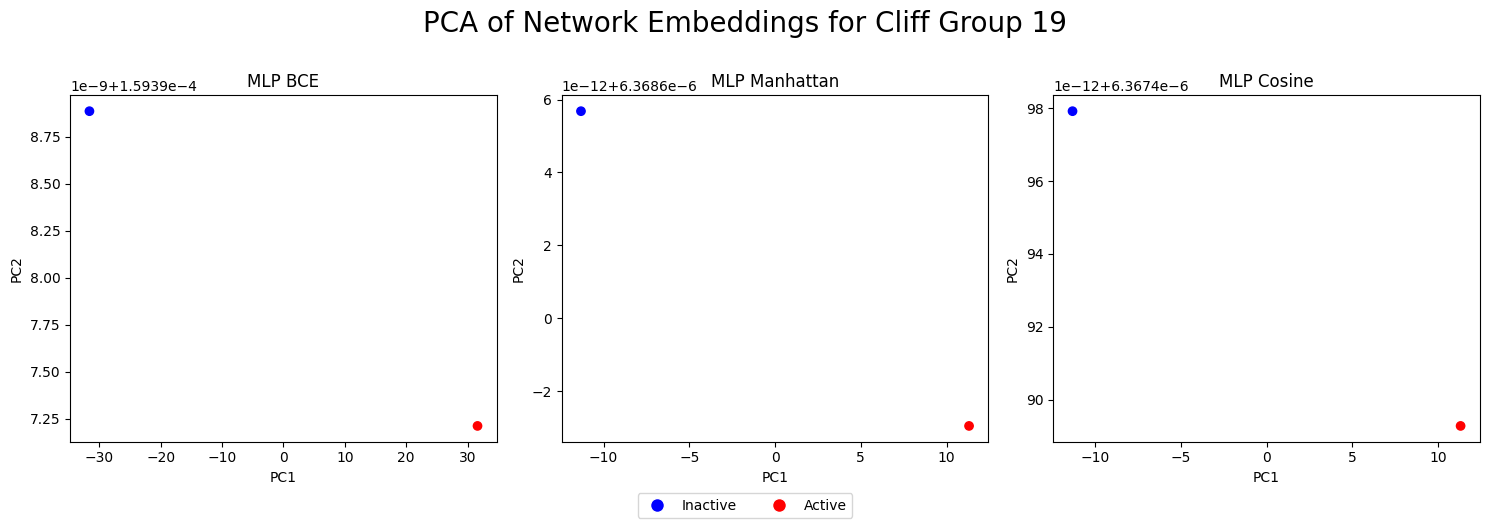

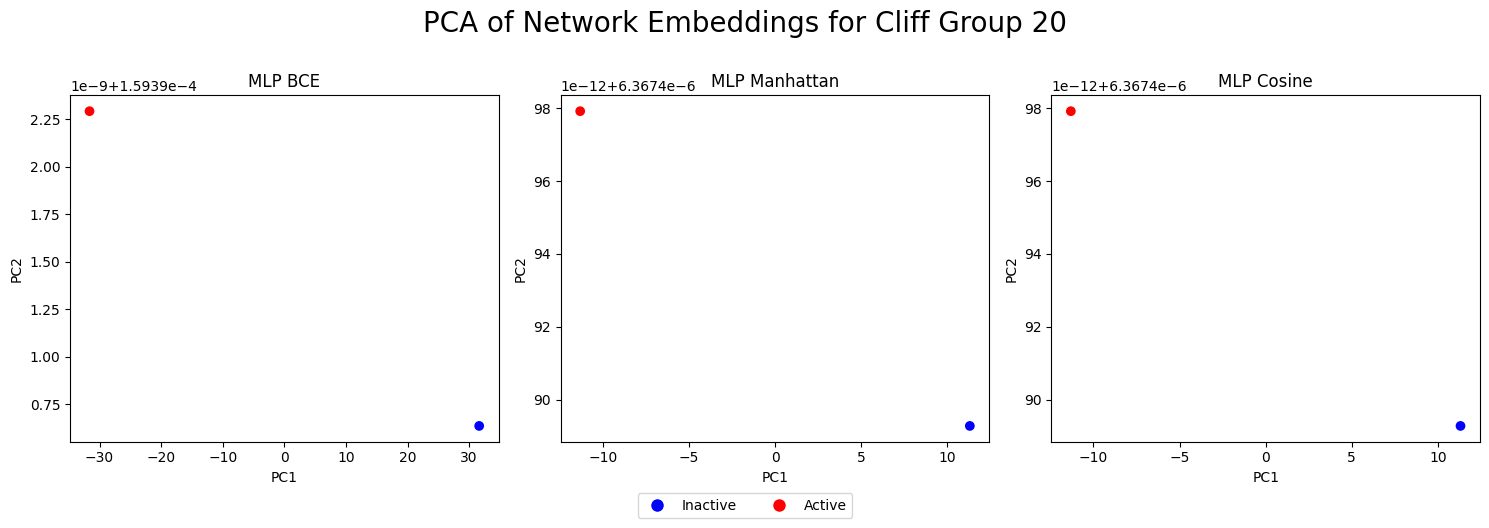

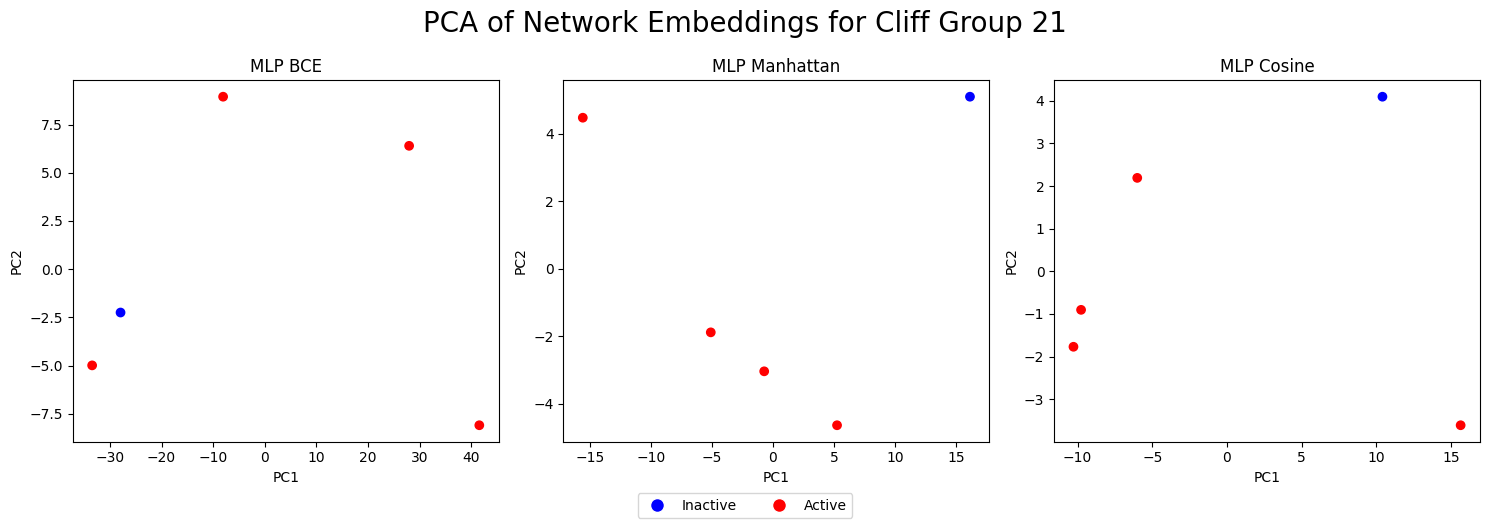

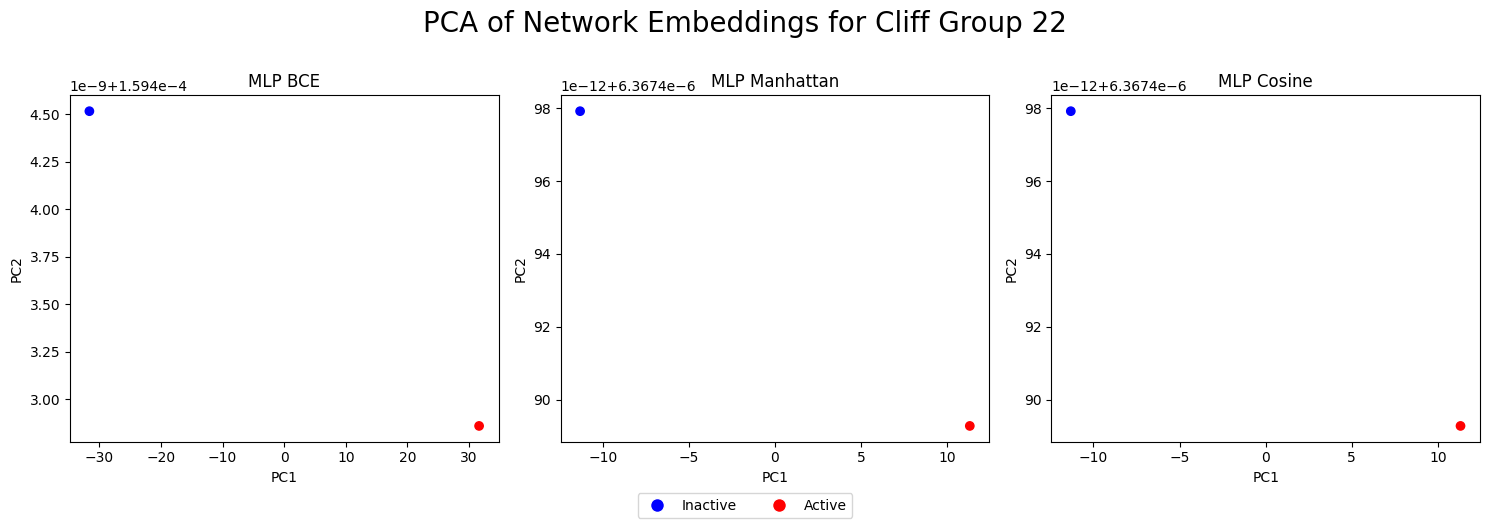

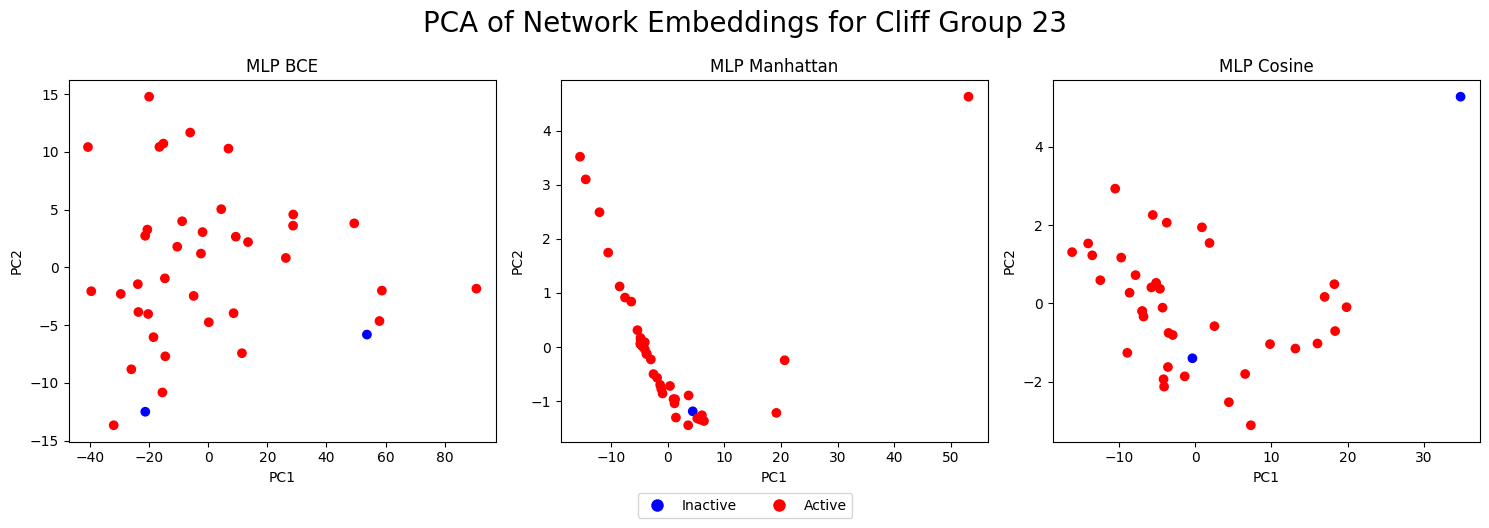

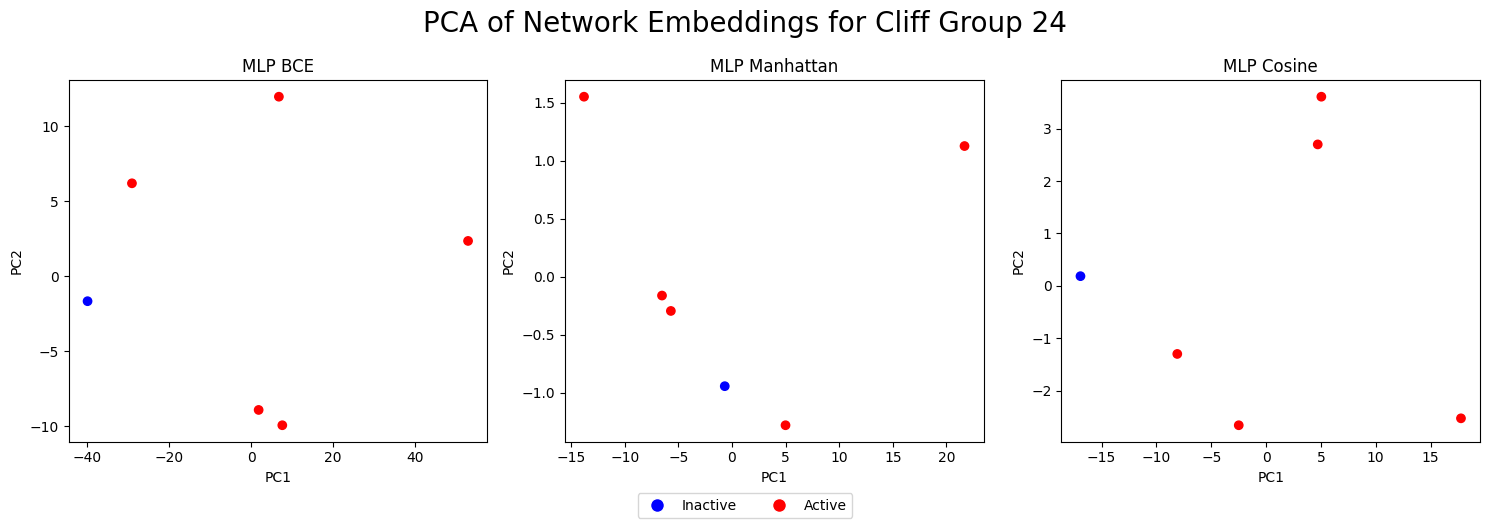

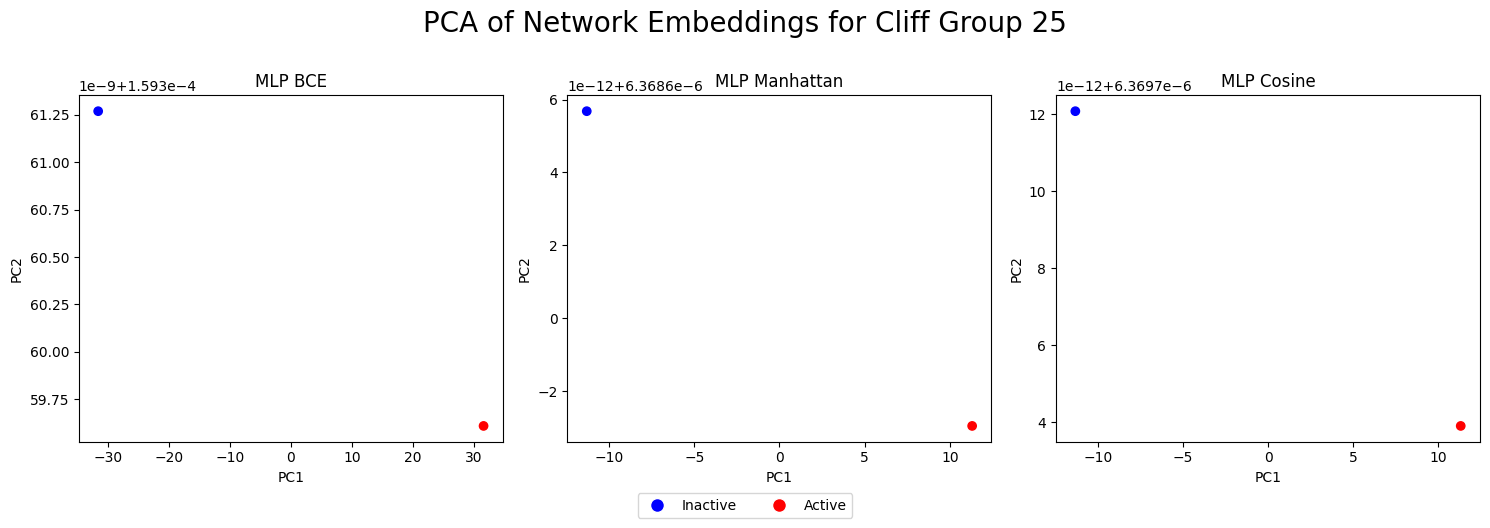

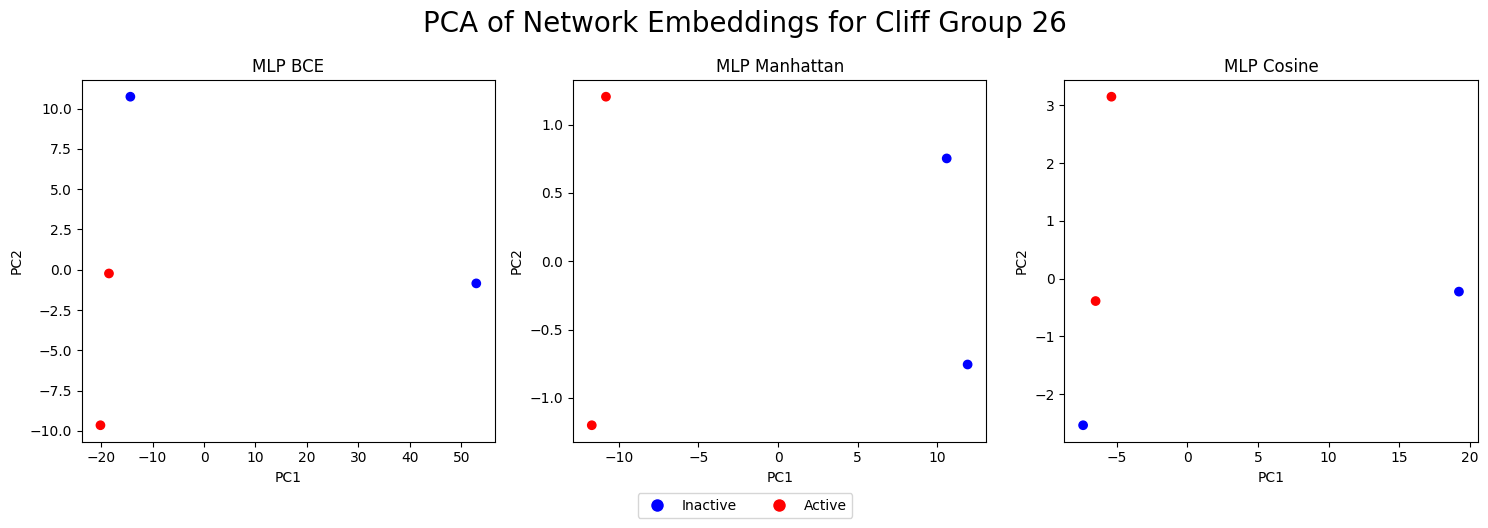

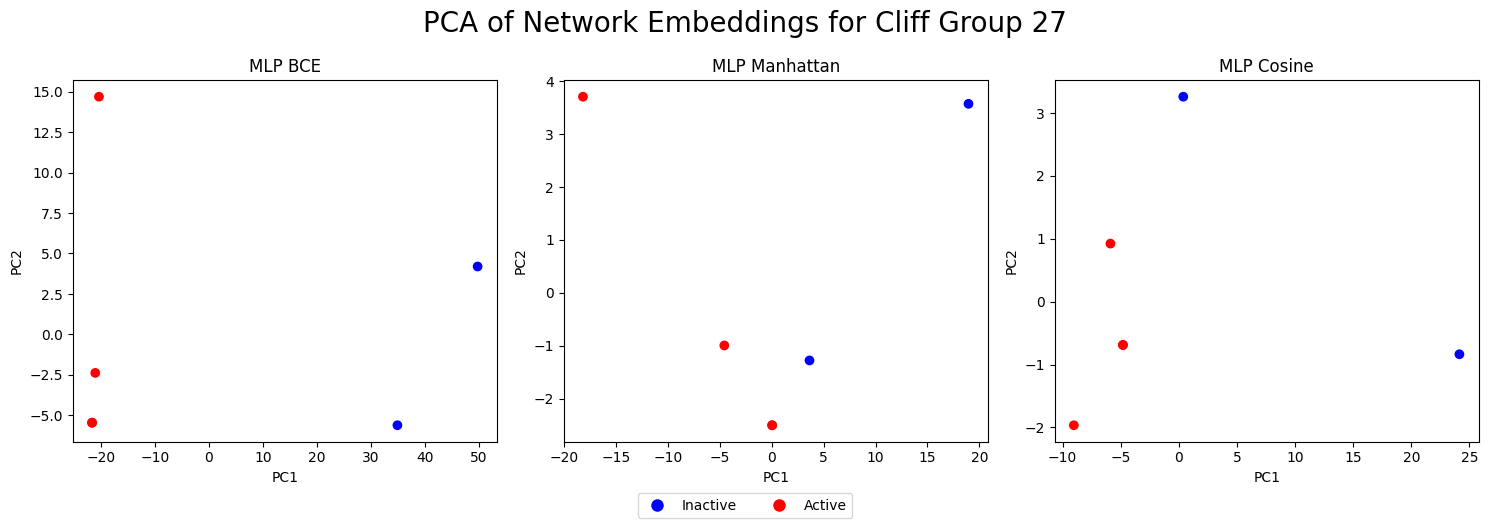

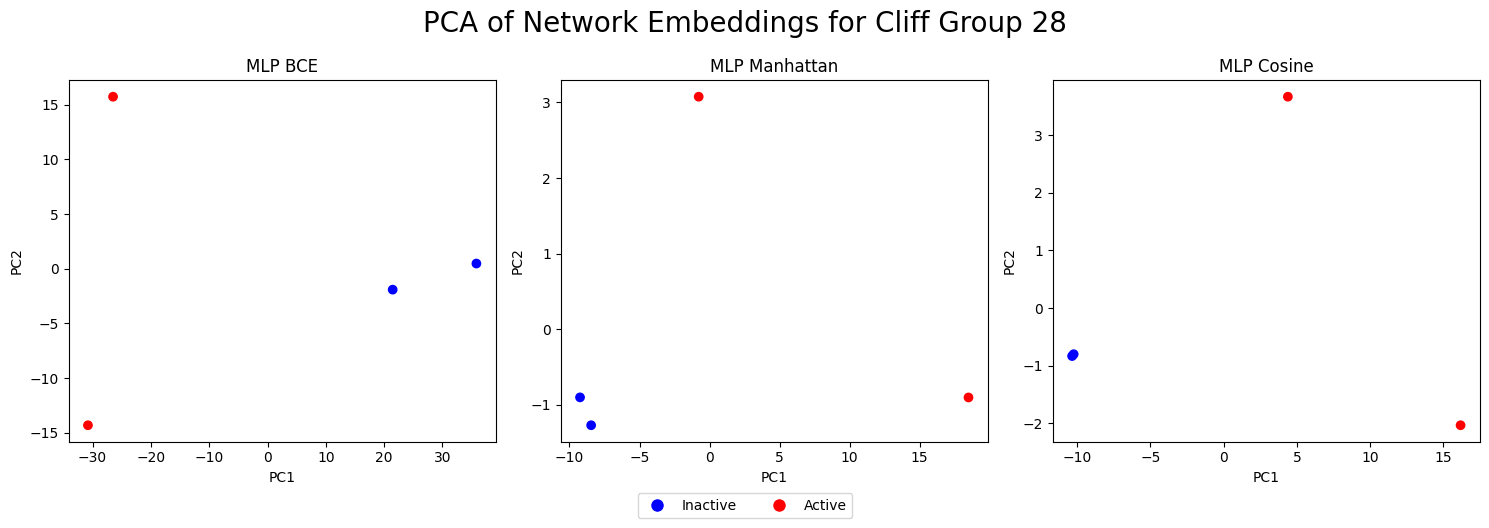

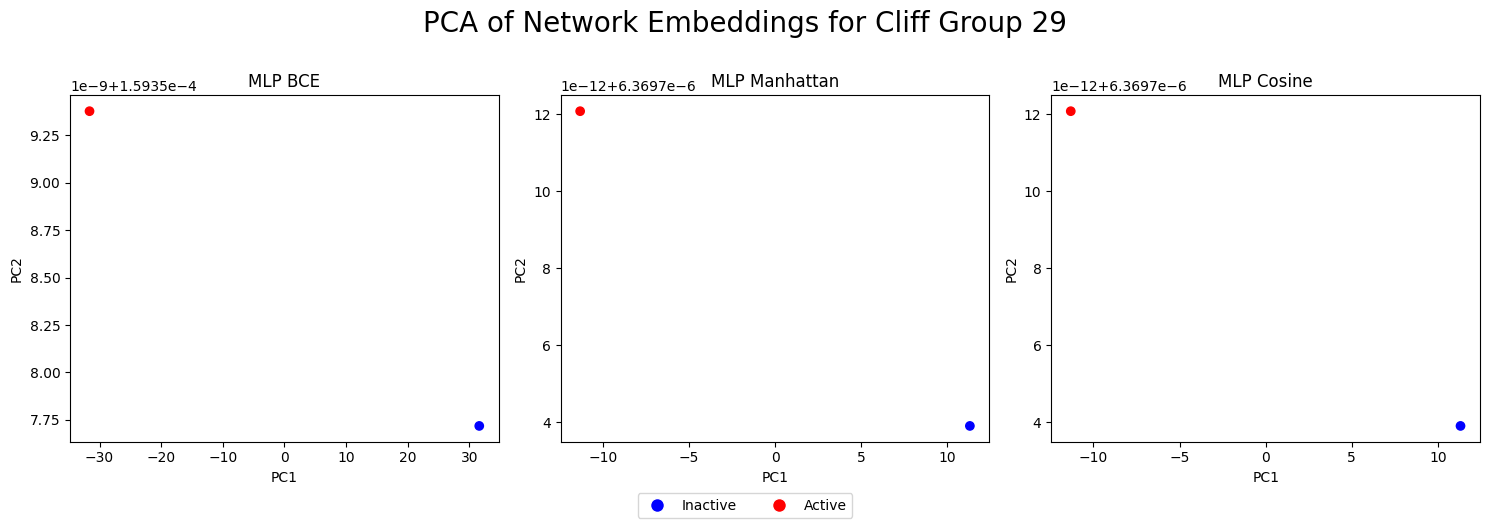

In [13]:
for i in range(len(group_dict)):
    plot_pca(group_id=i, seed=94)

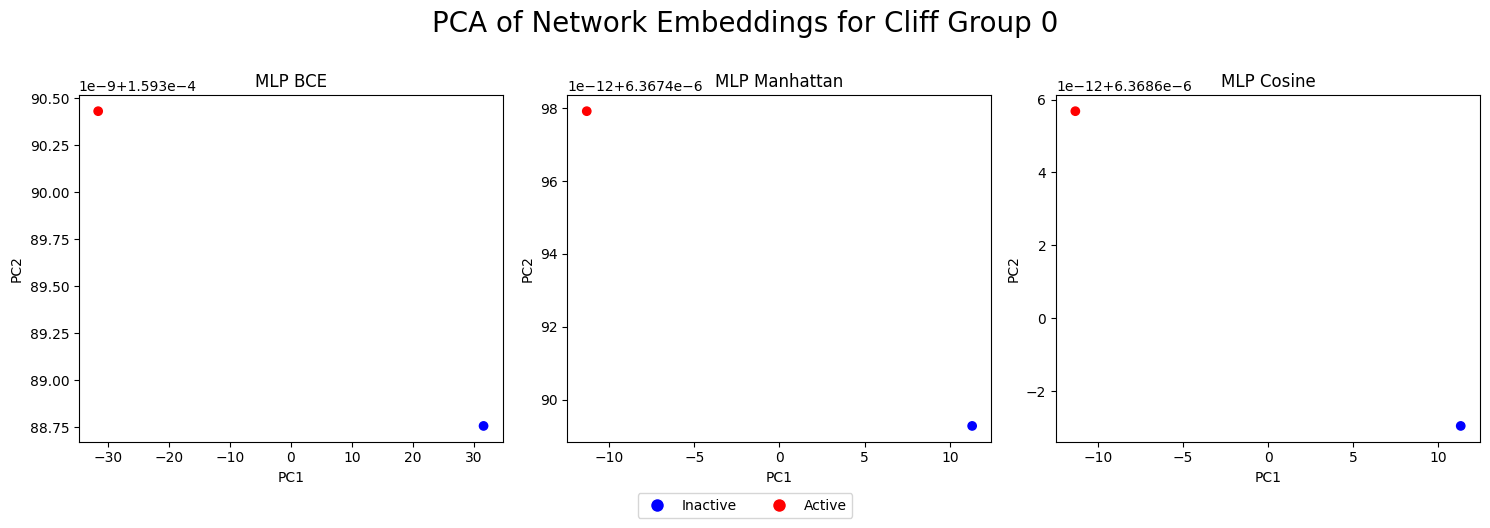

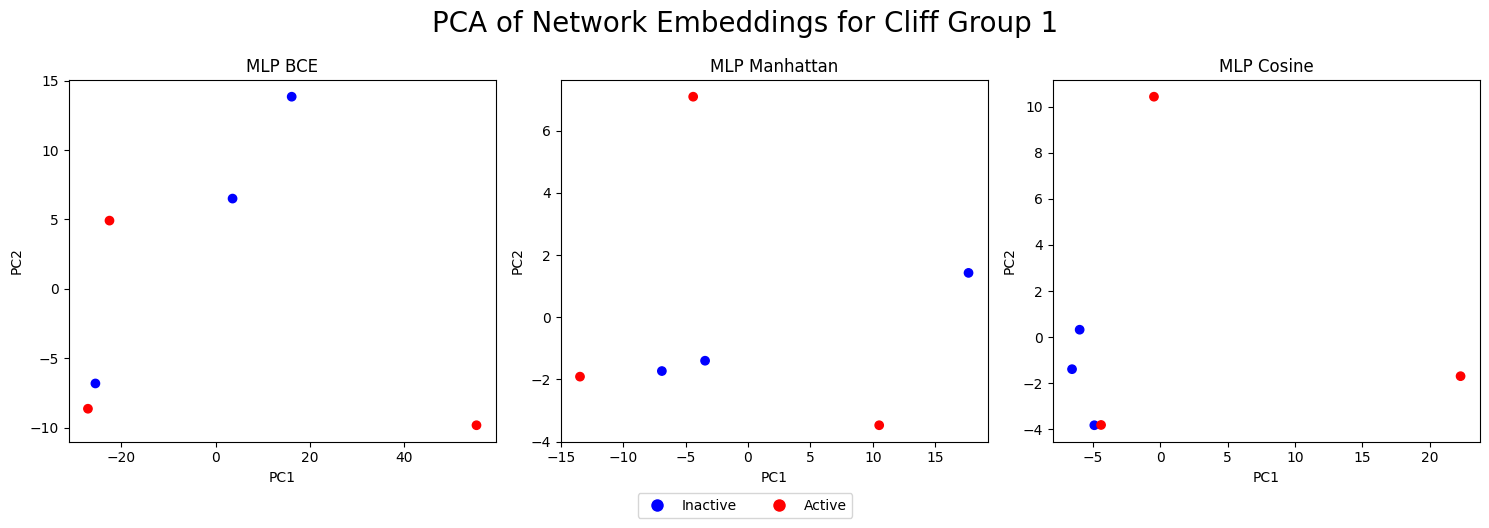

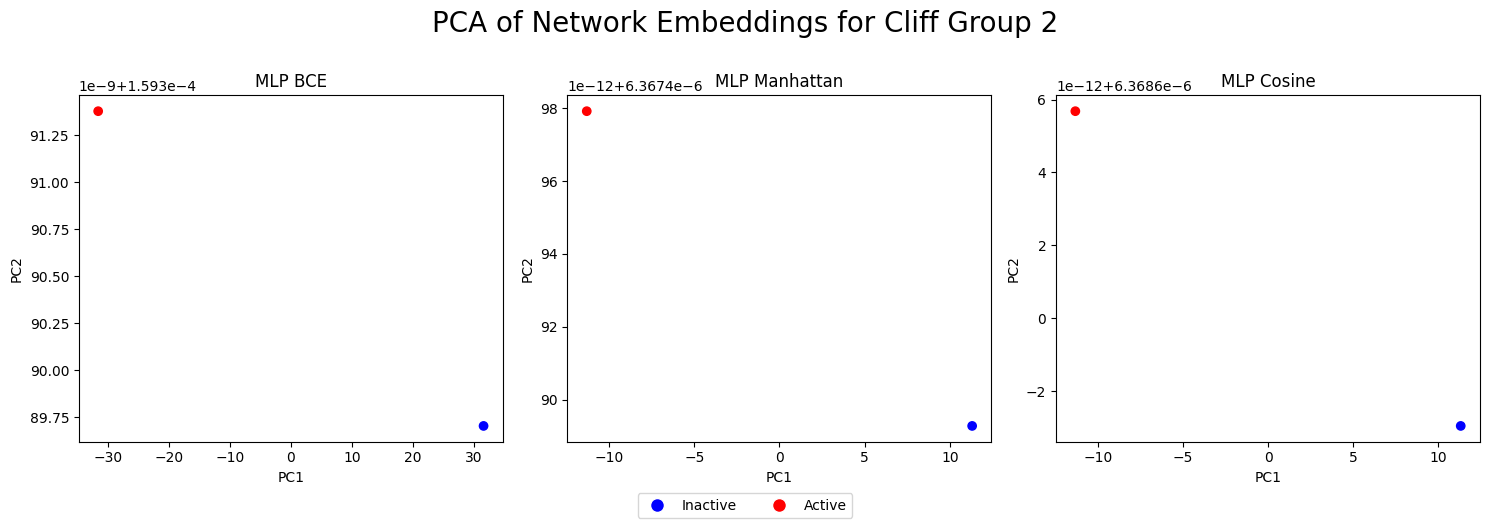

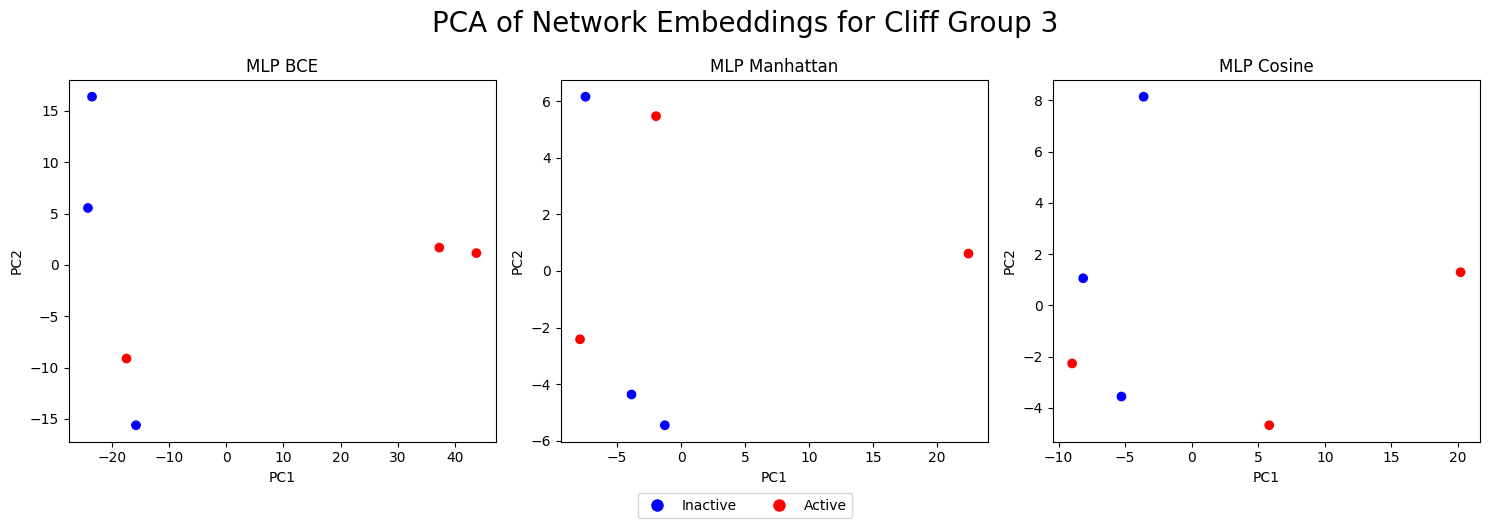

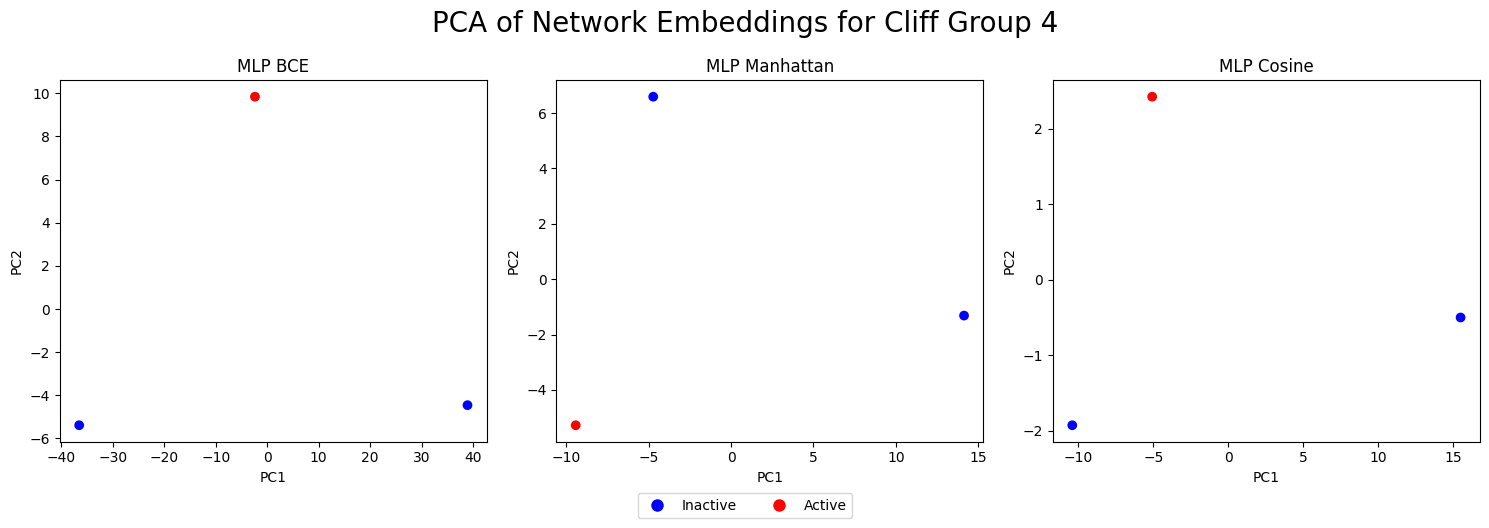

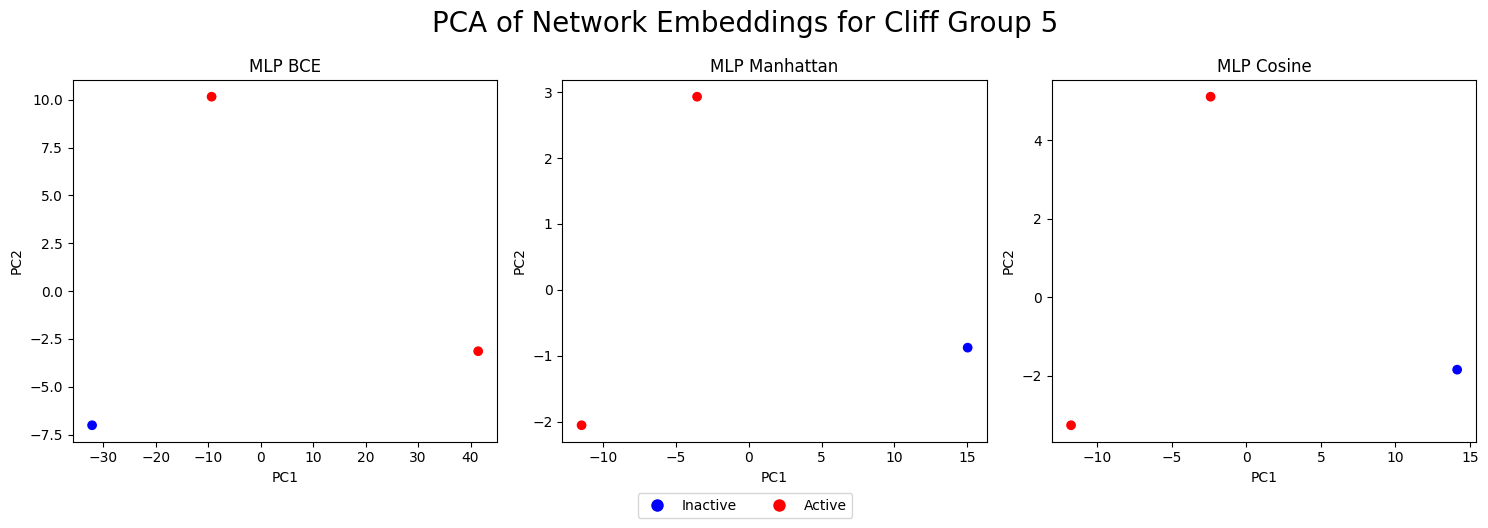

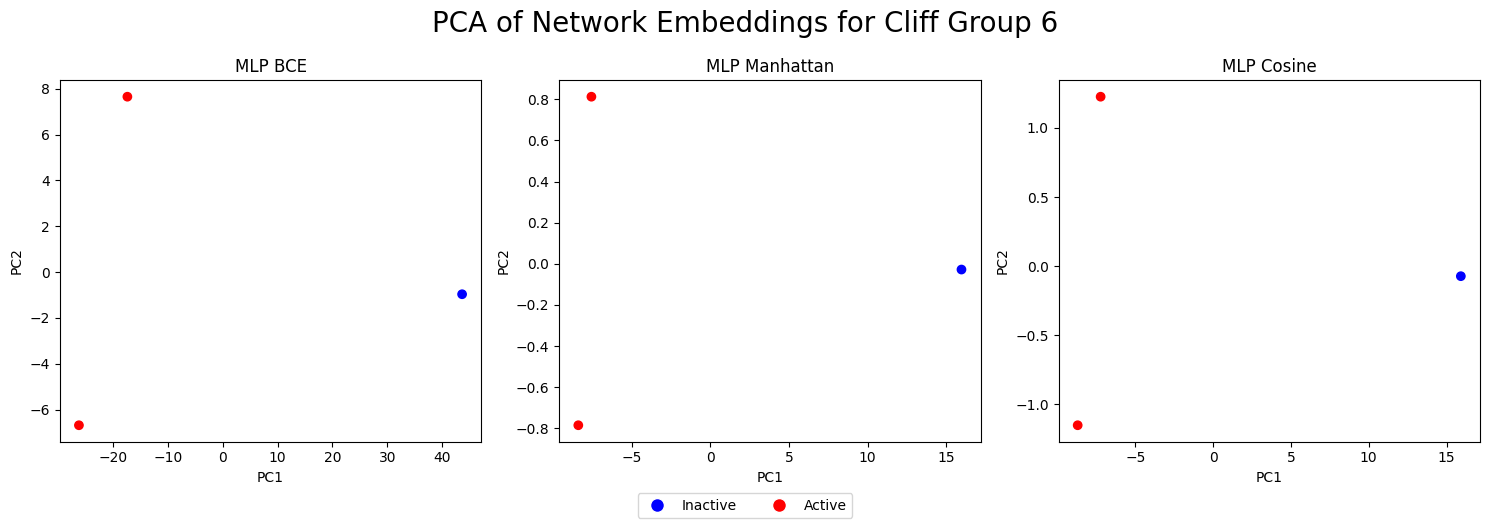

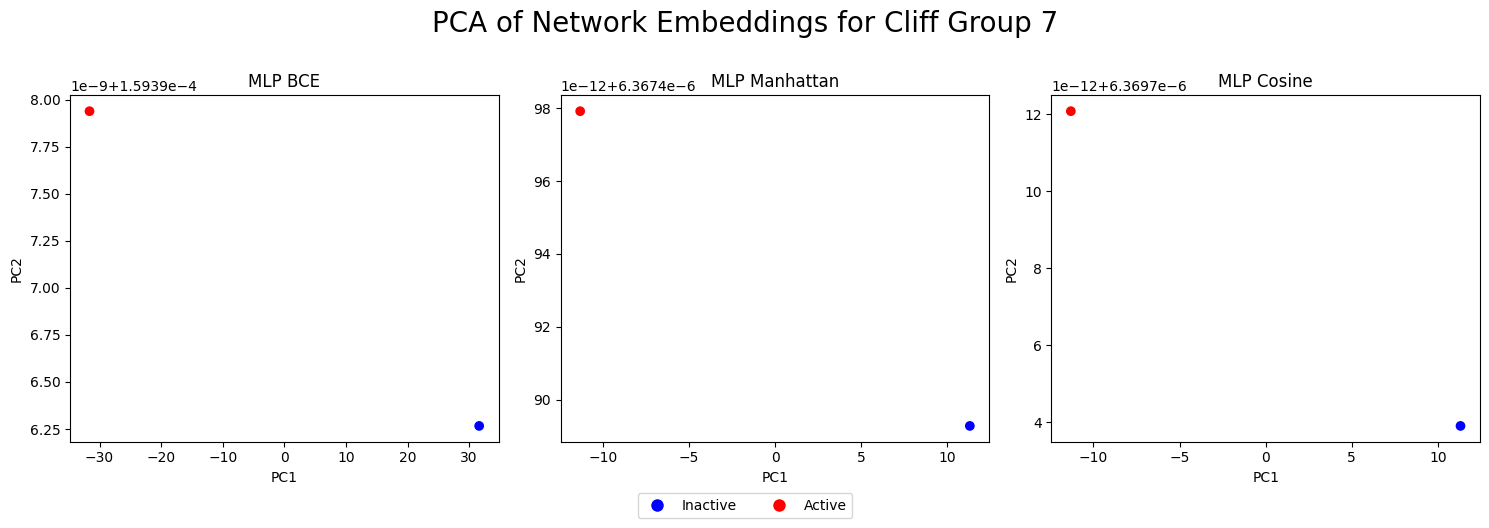

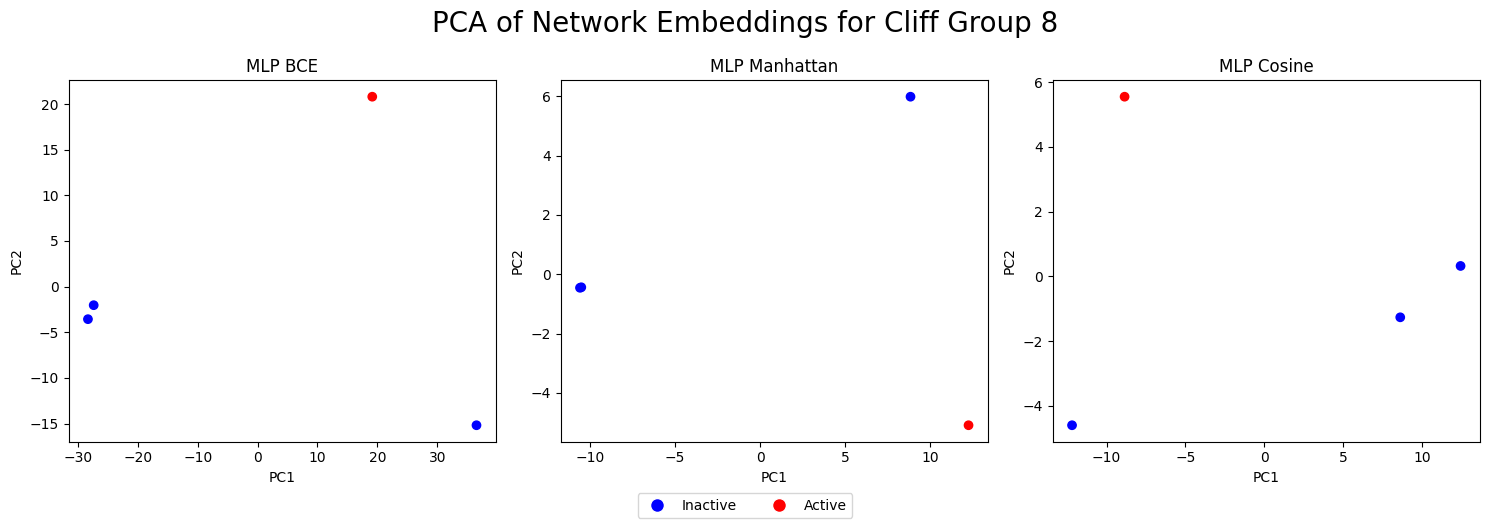

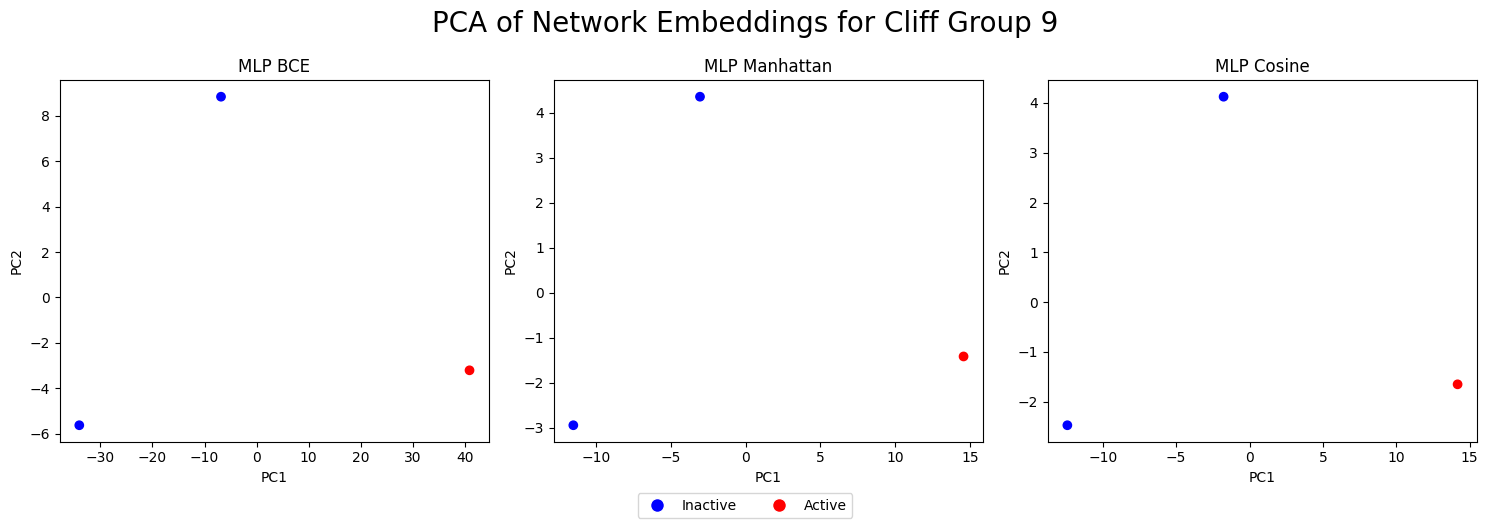

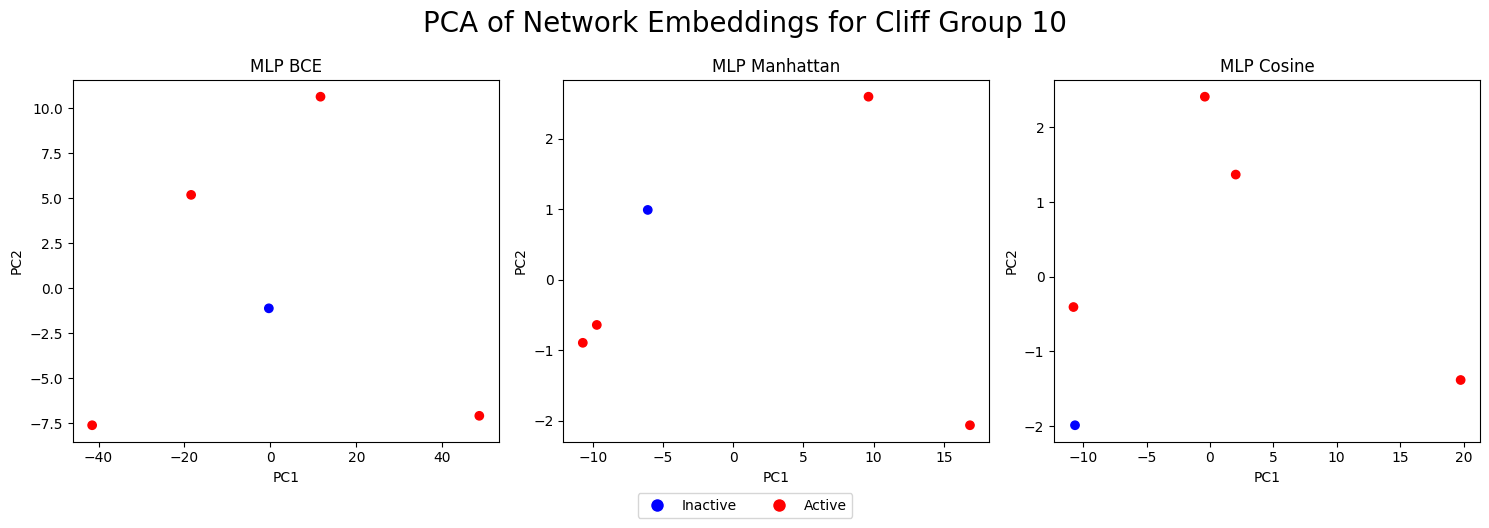

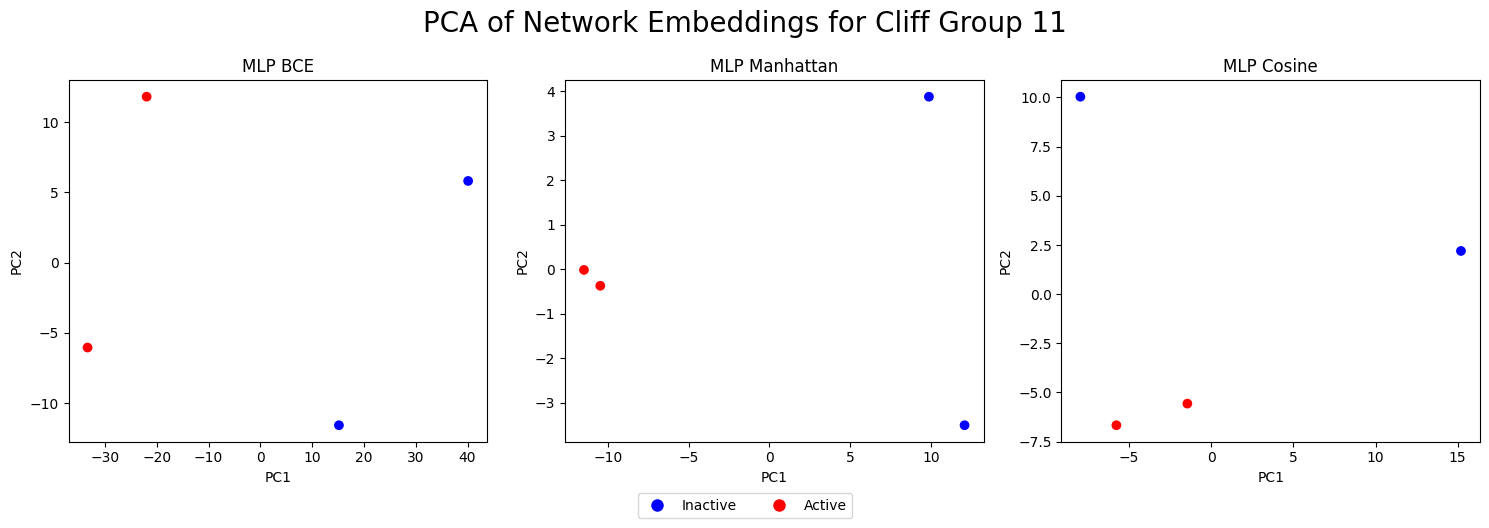

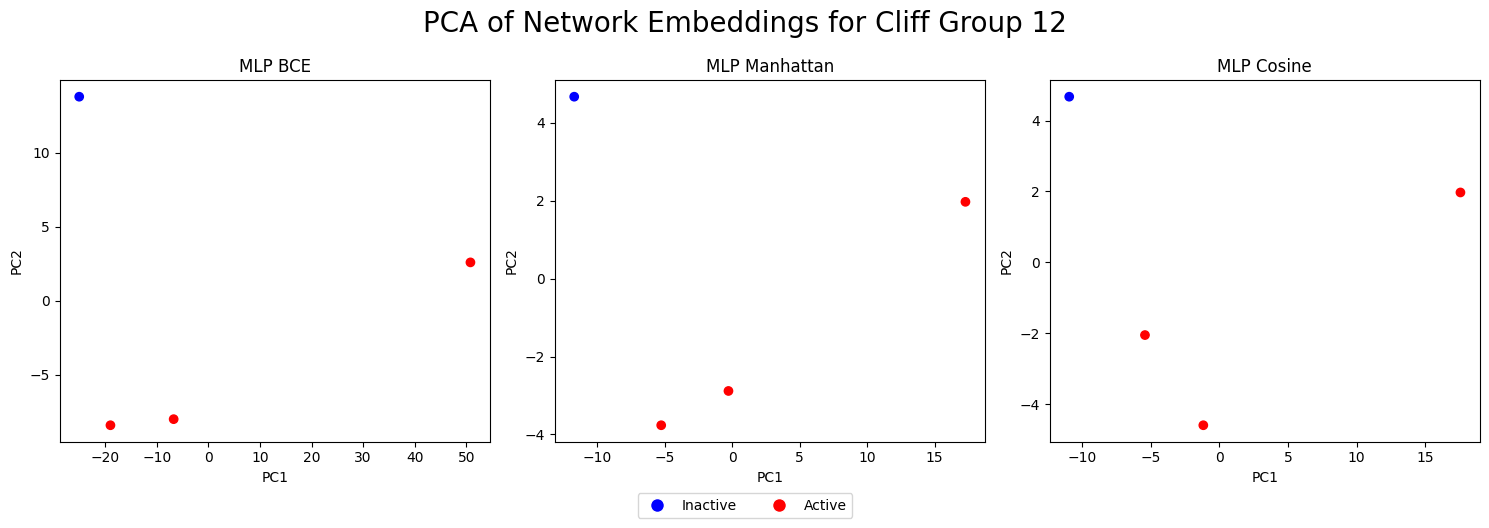

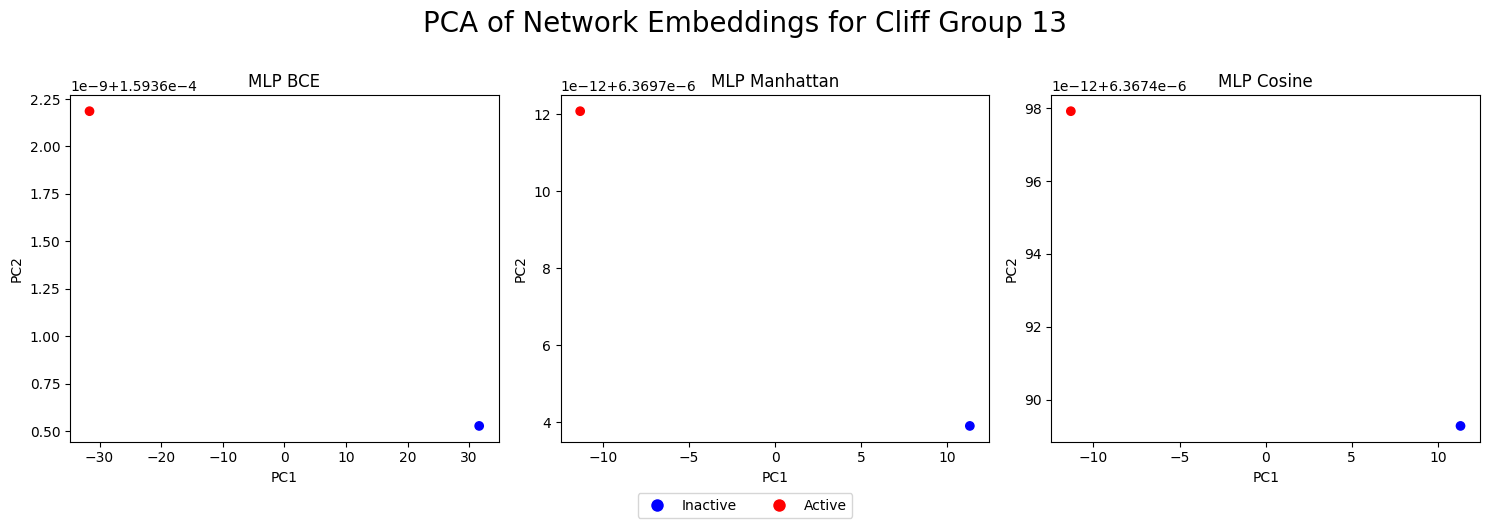

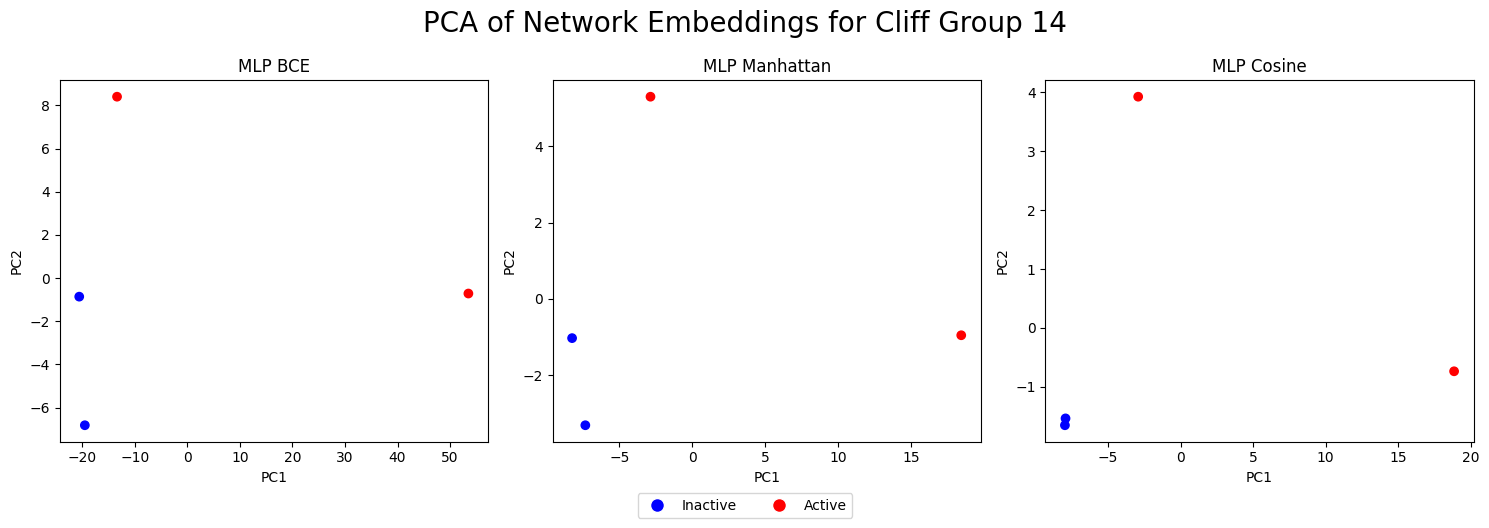

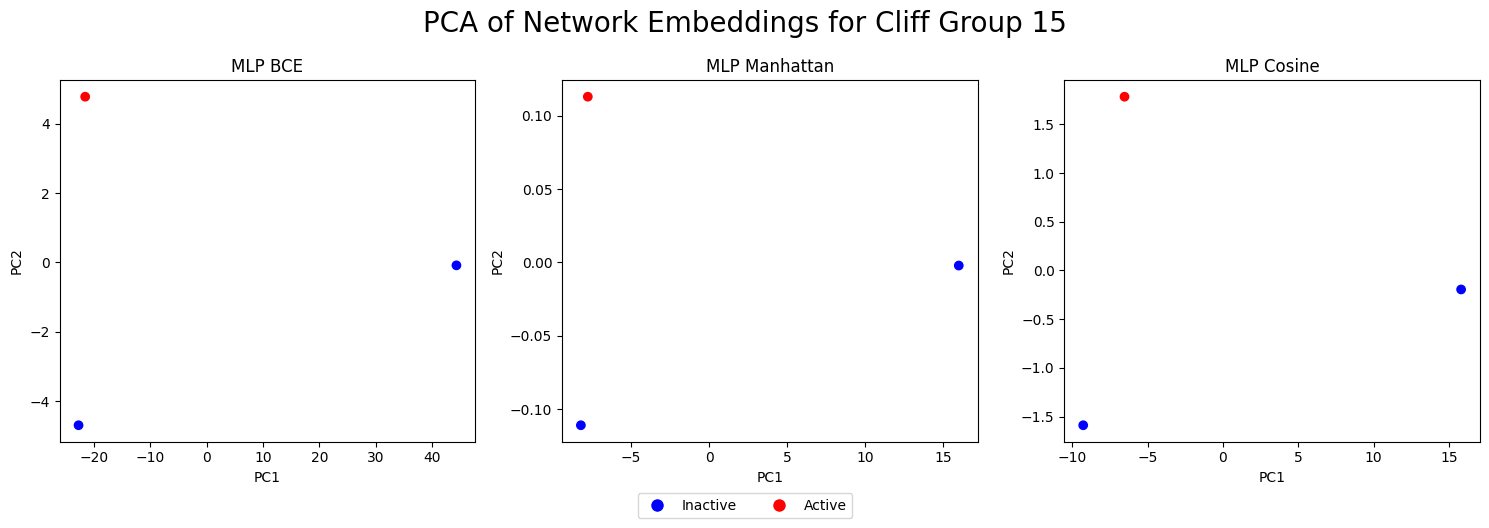

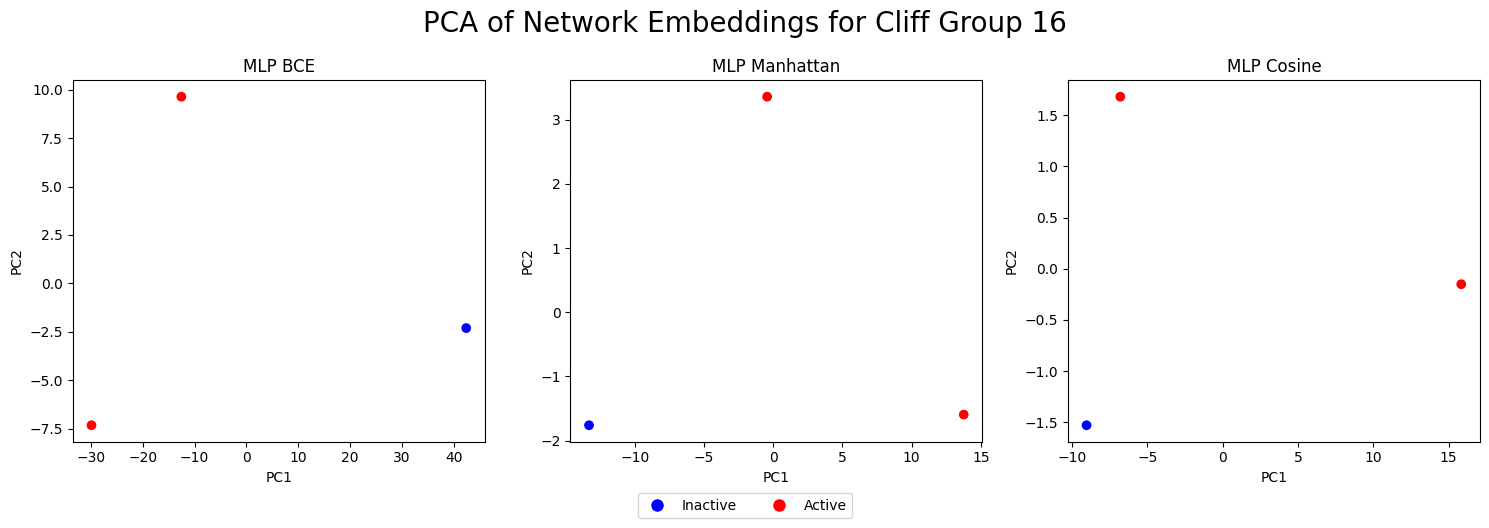

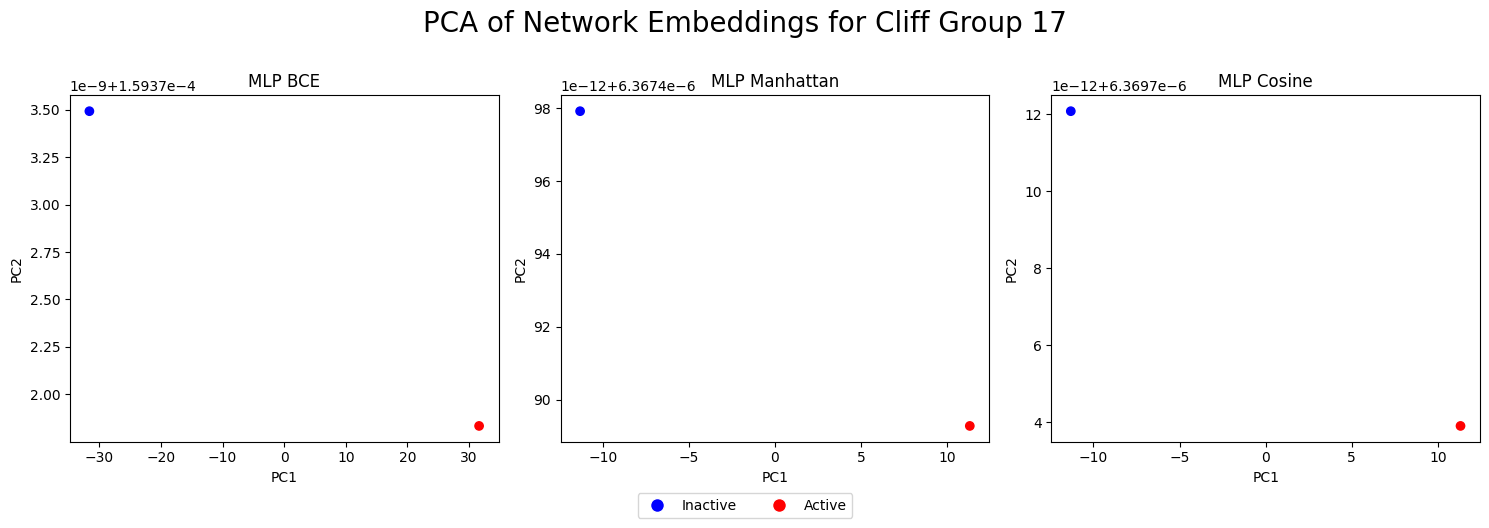

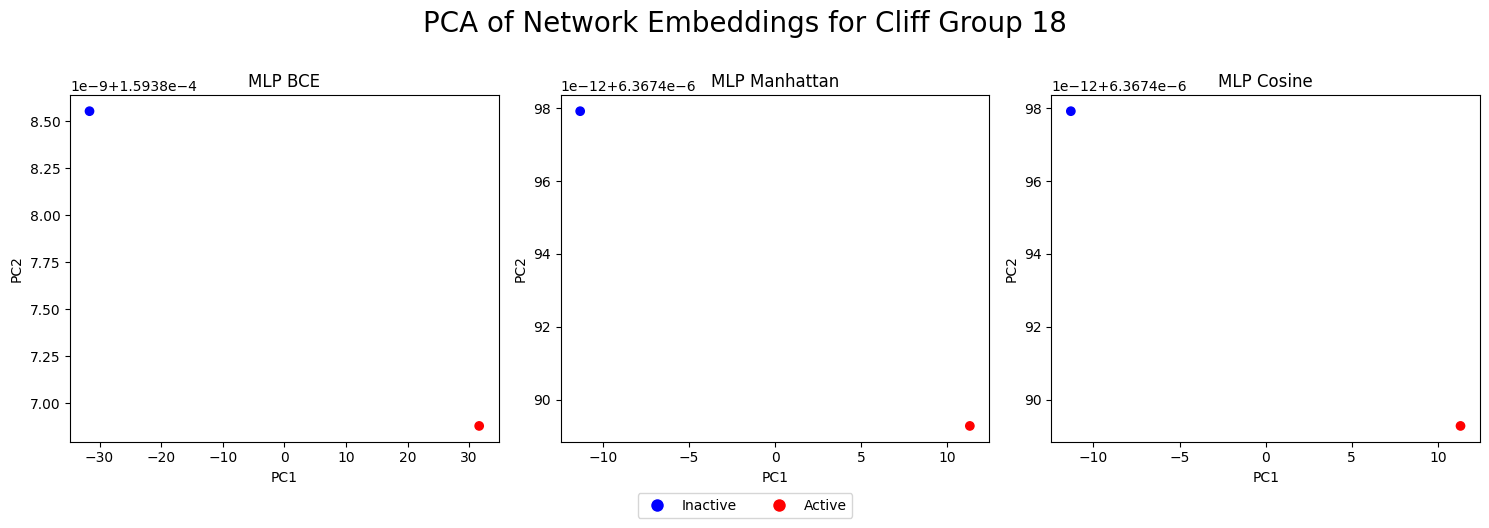

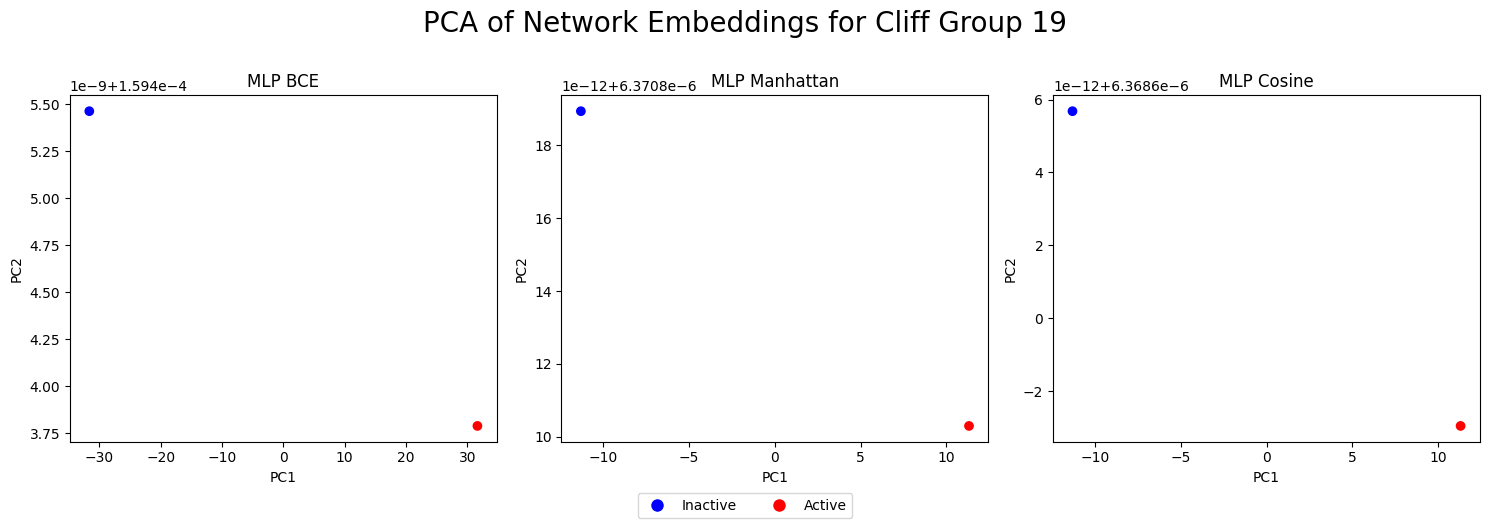

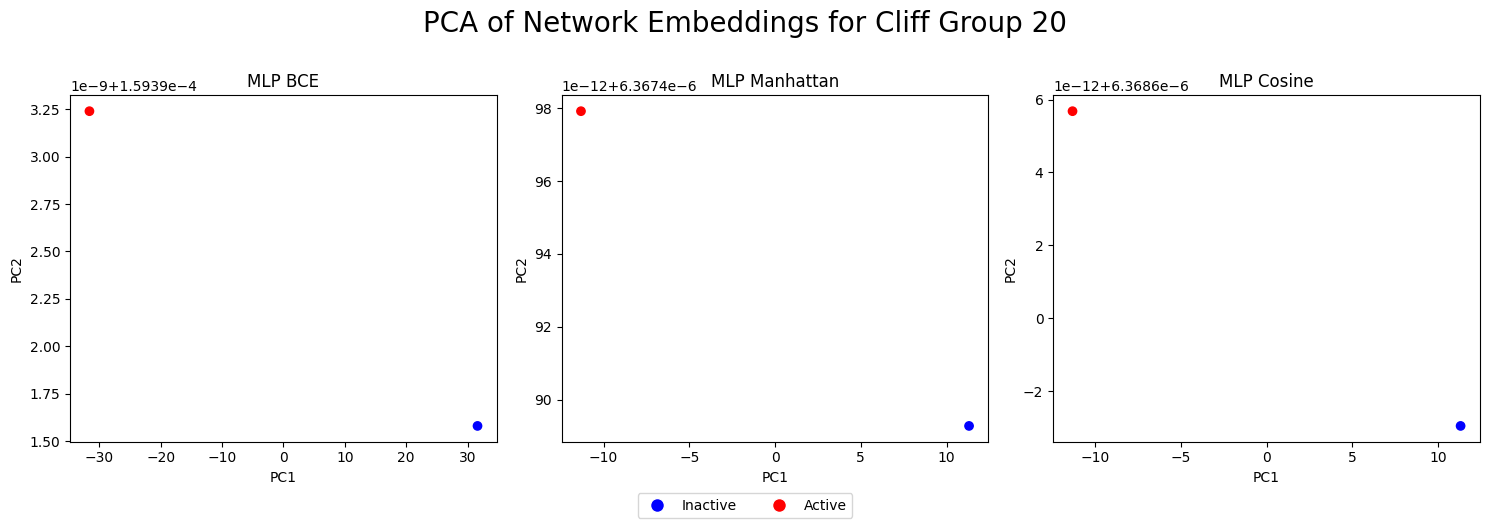

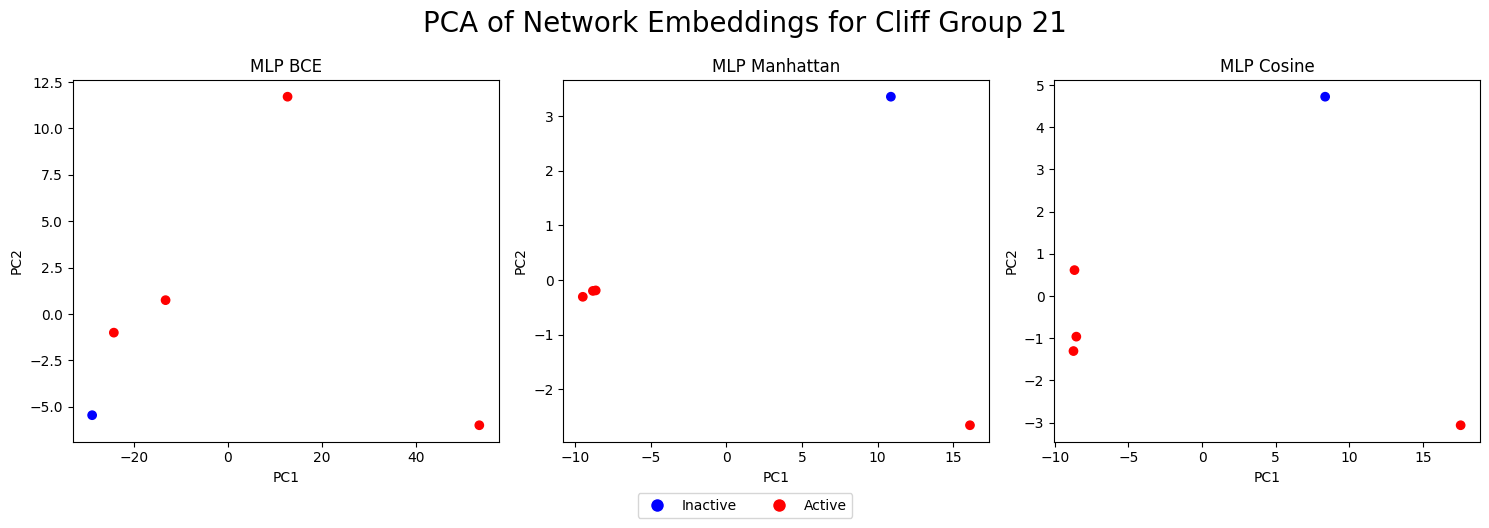

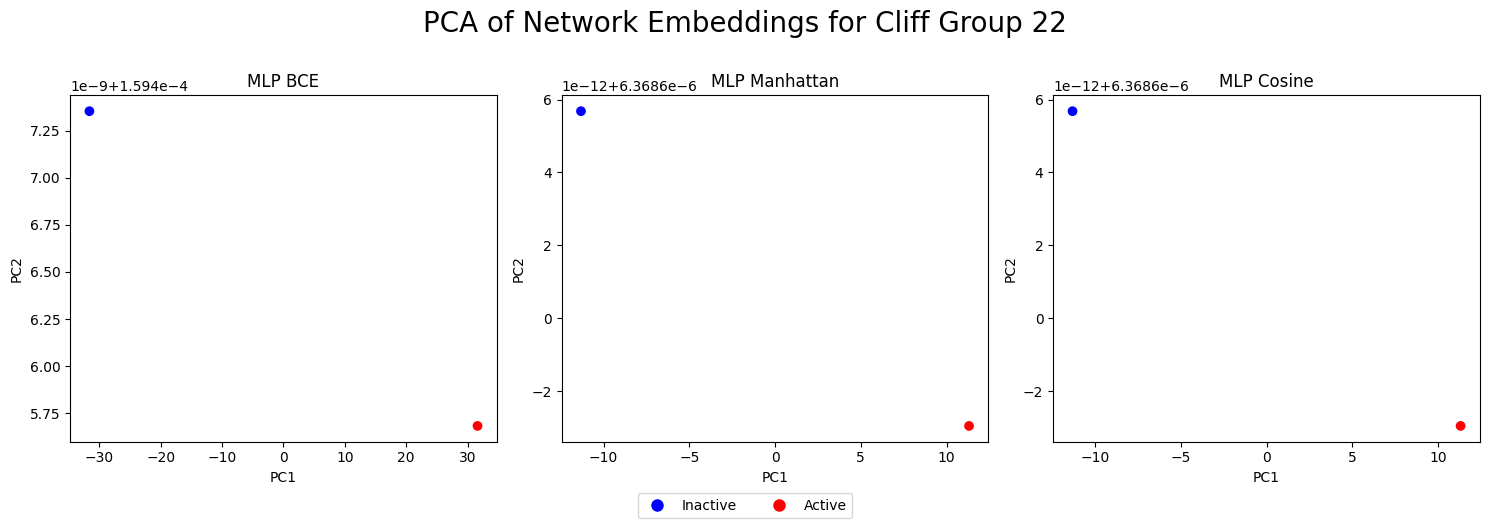

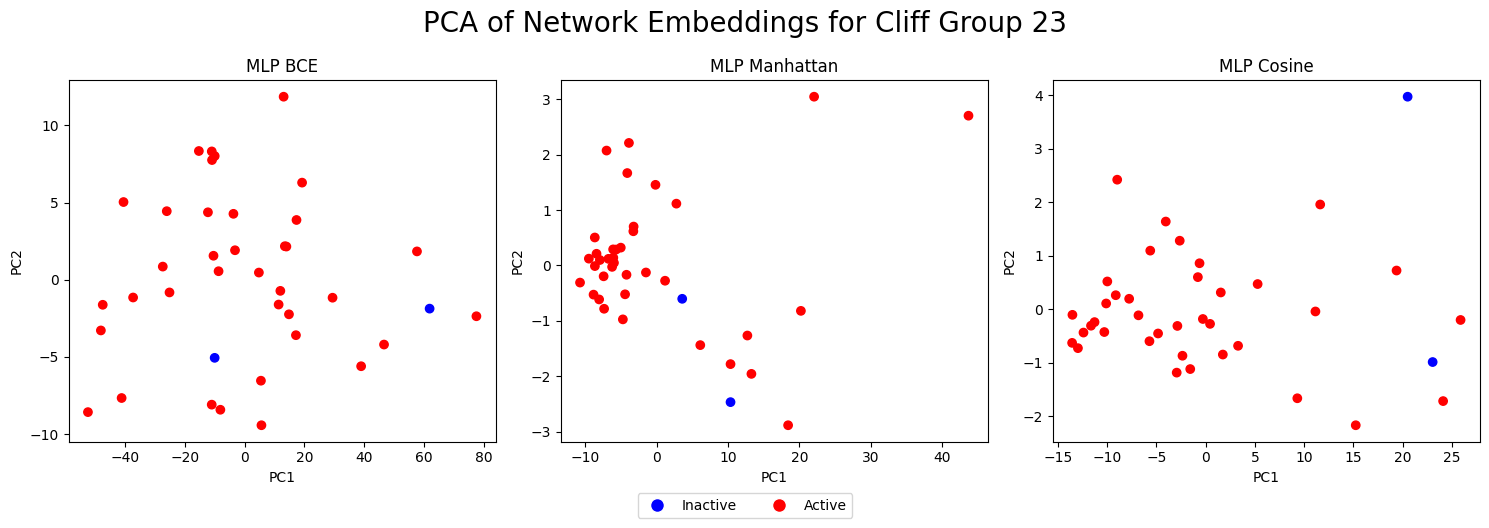

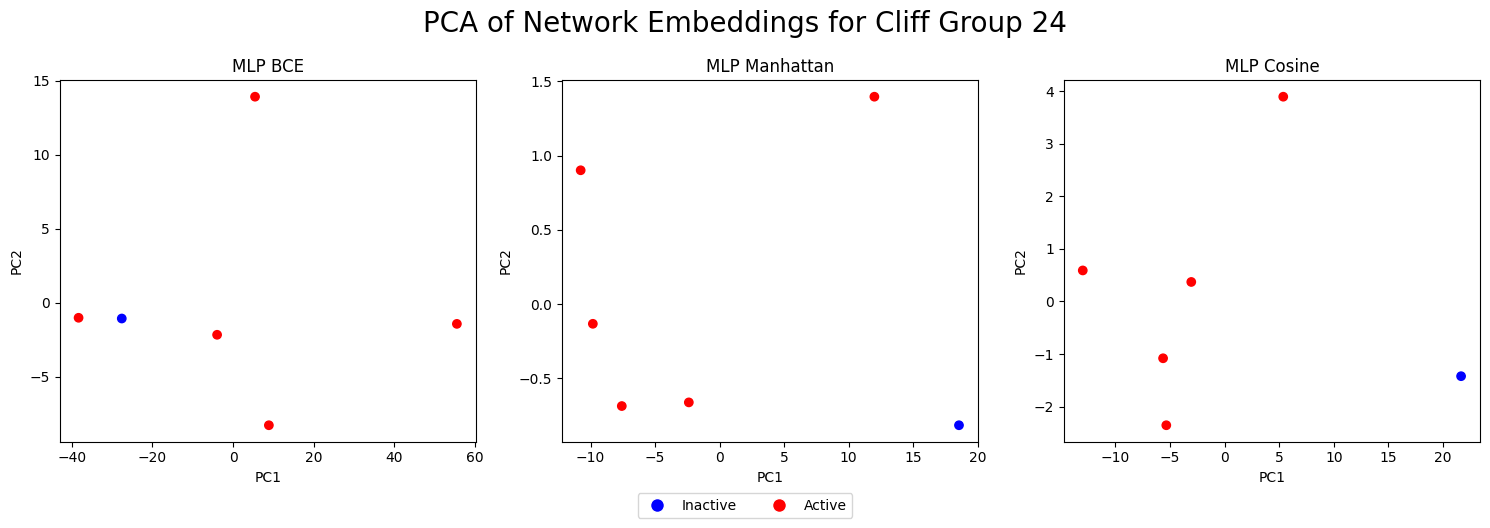

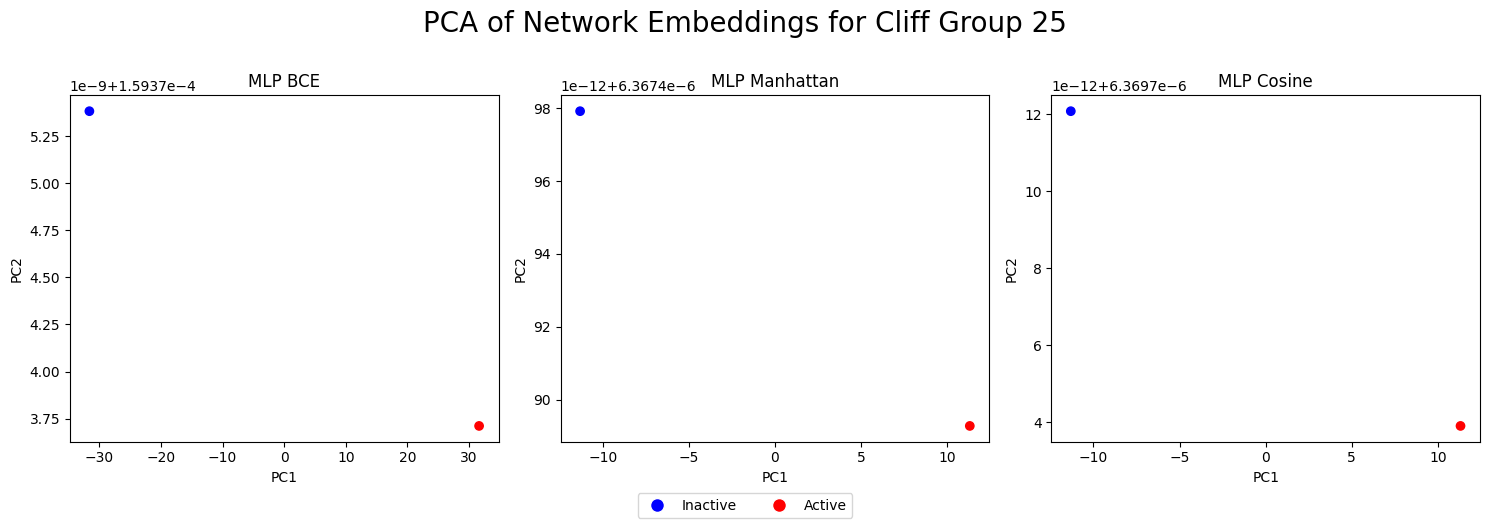

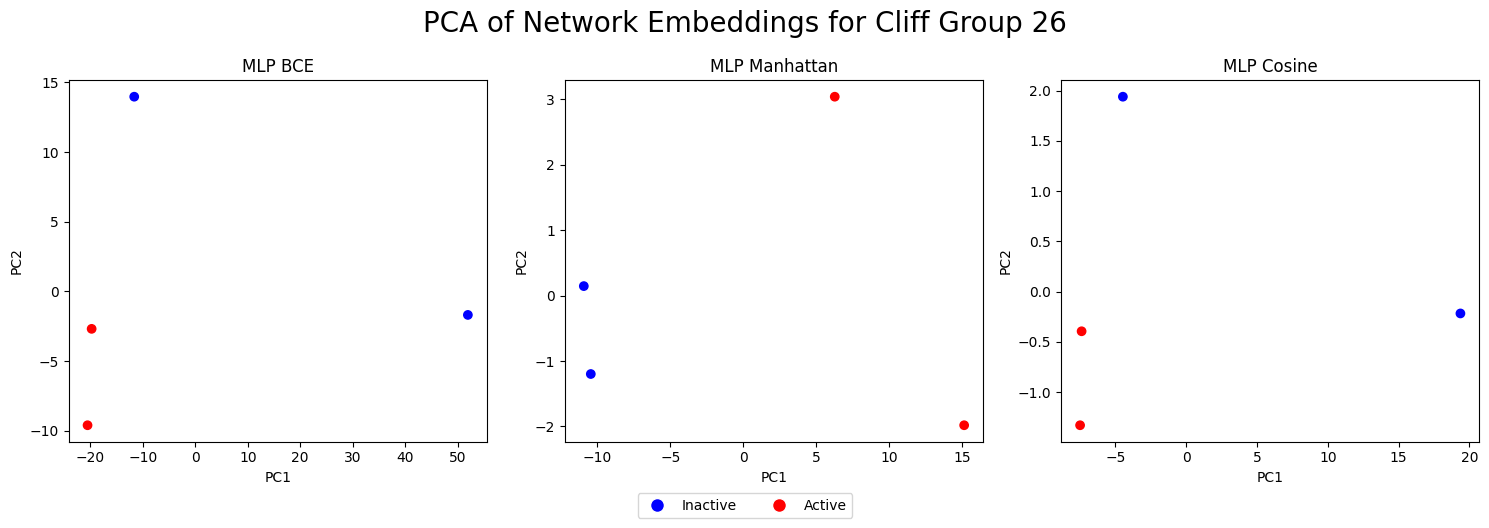

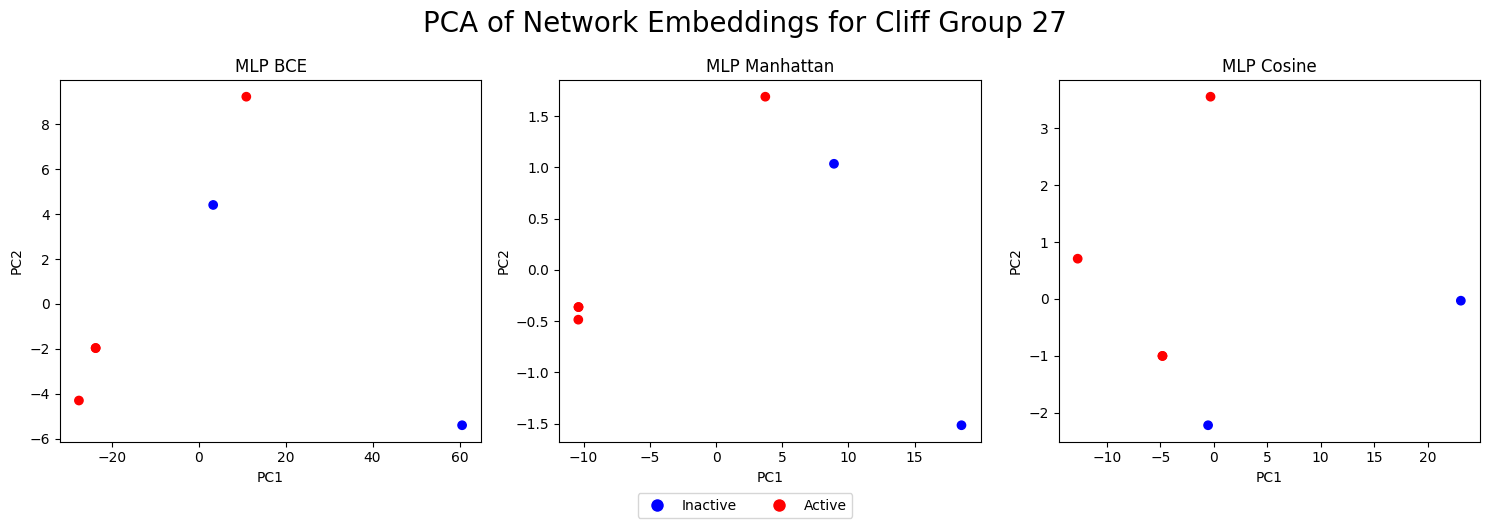

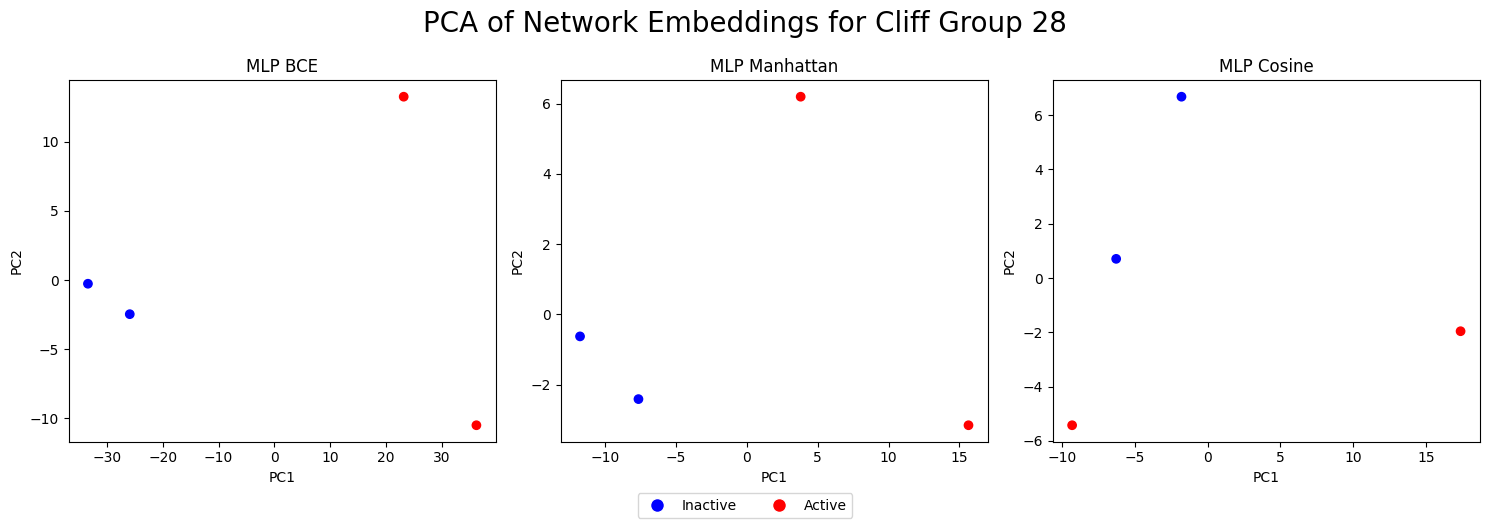

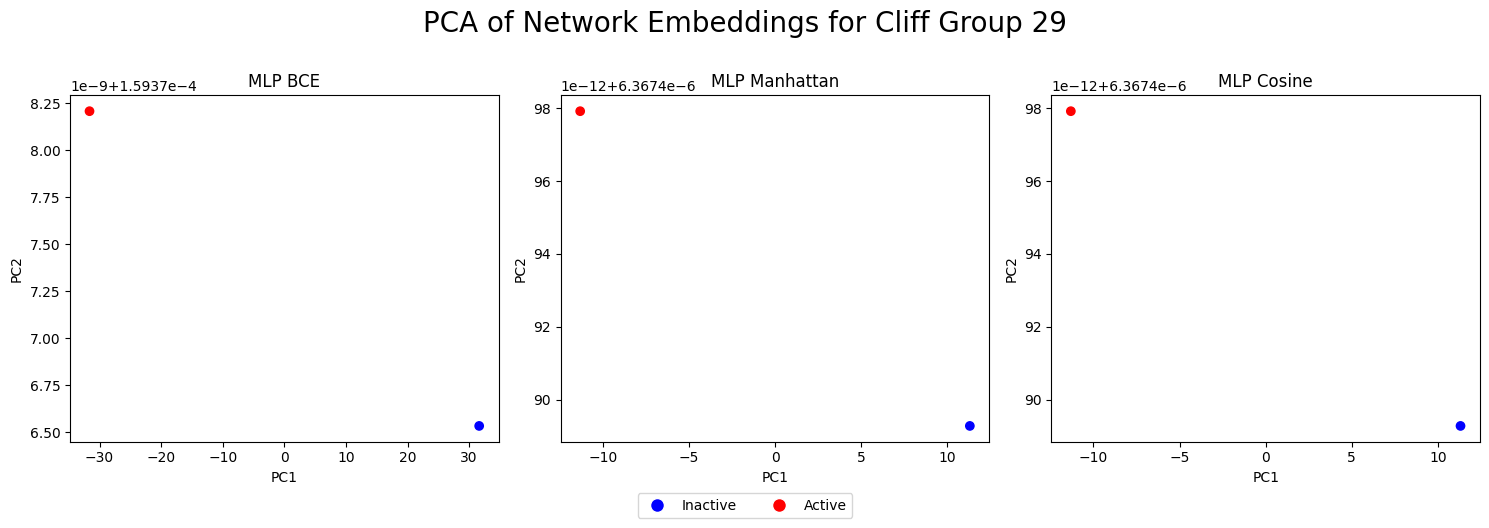

In [14]:
for i in range(len(group_dict)):
    plot_pca(group_id=i, seed=39)

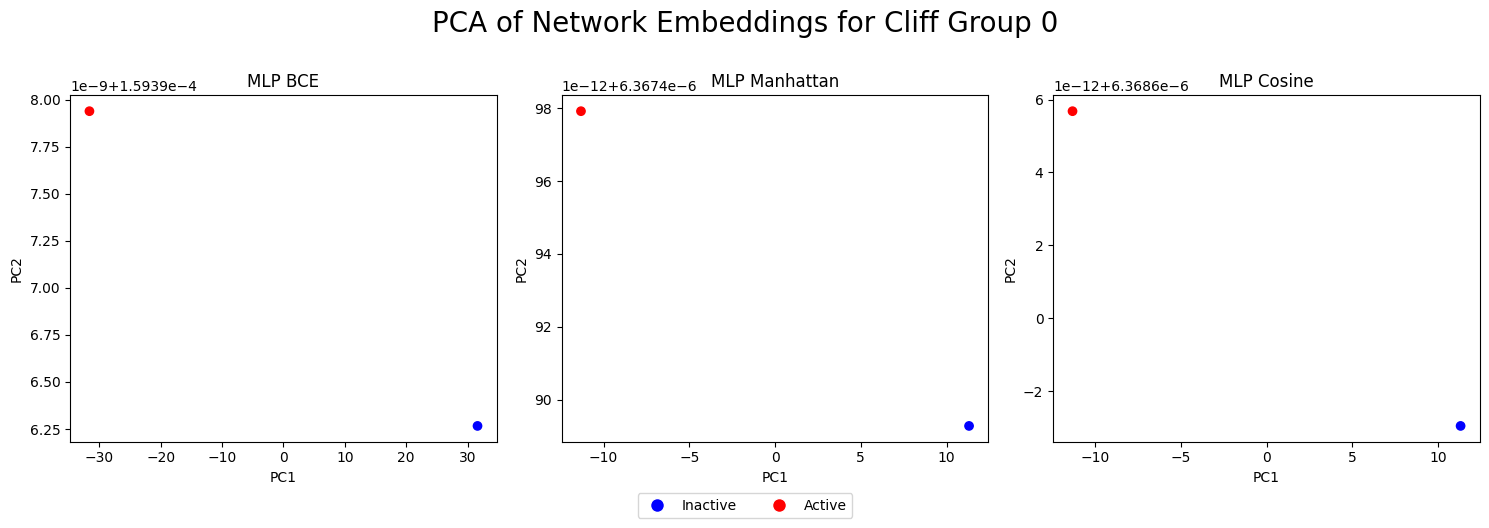

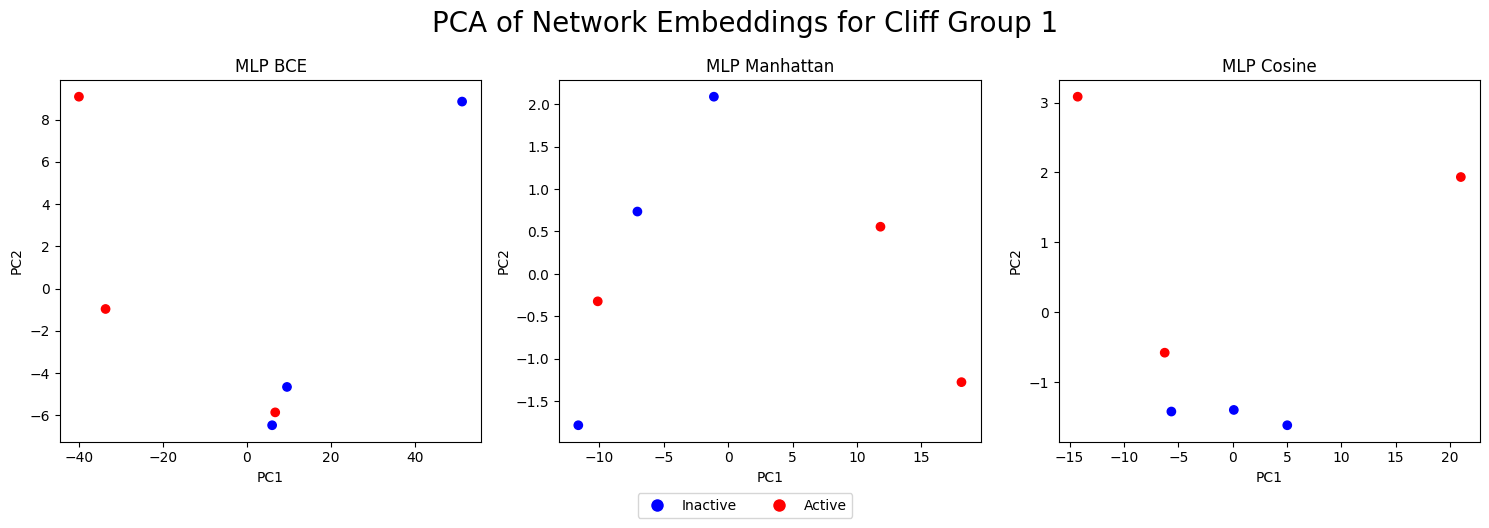

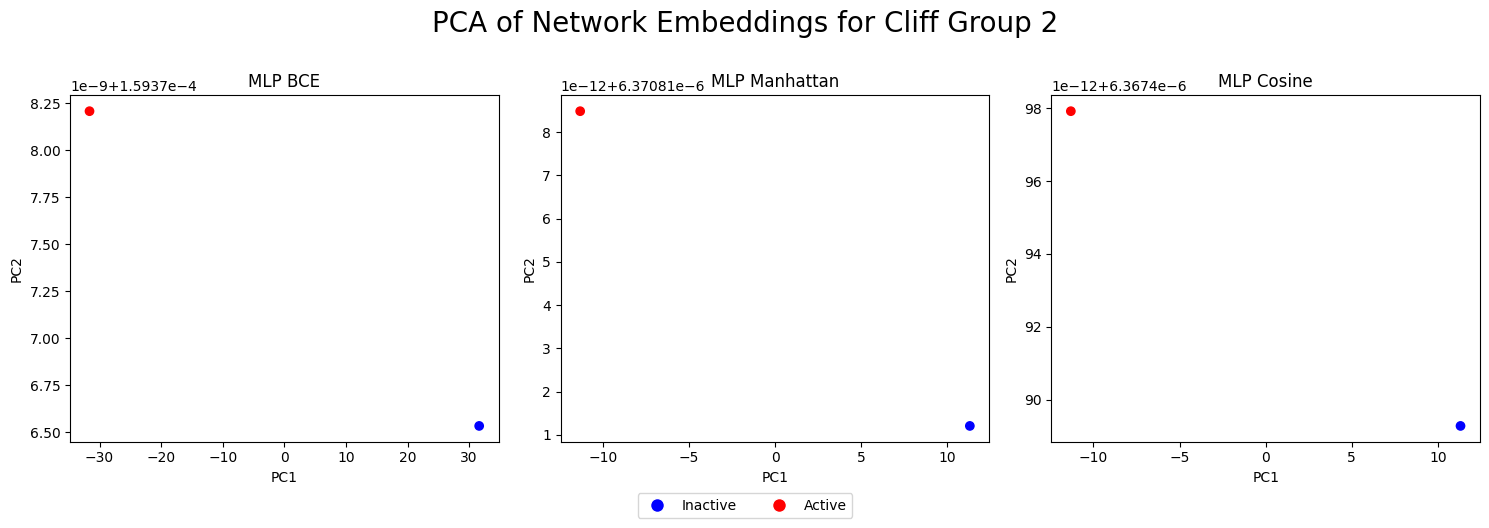

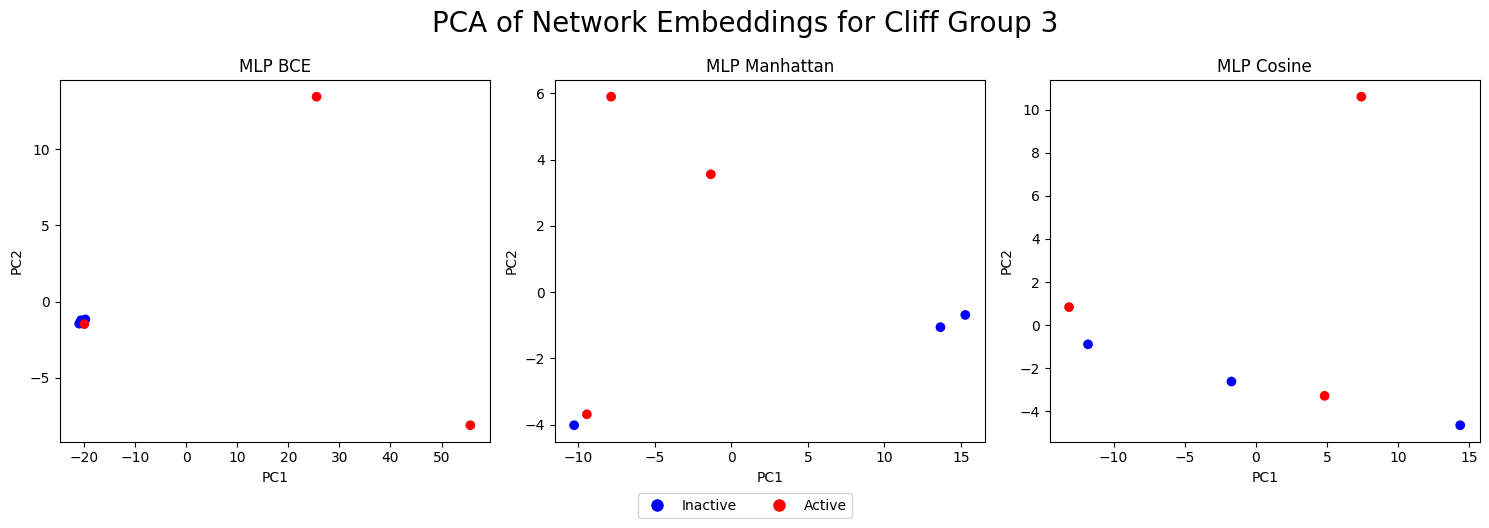

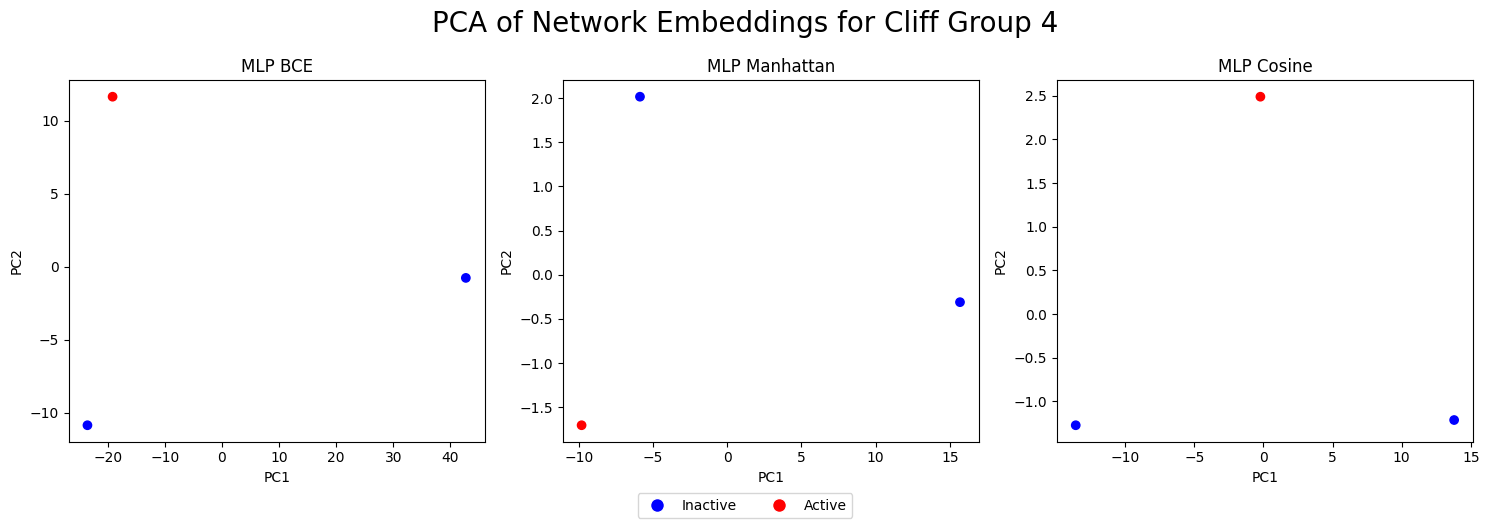

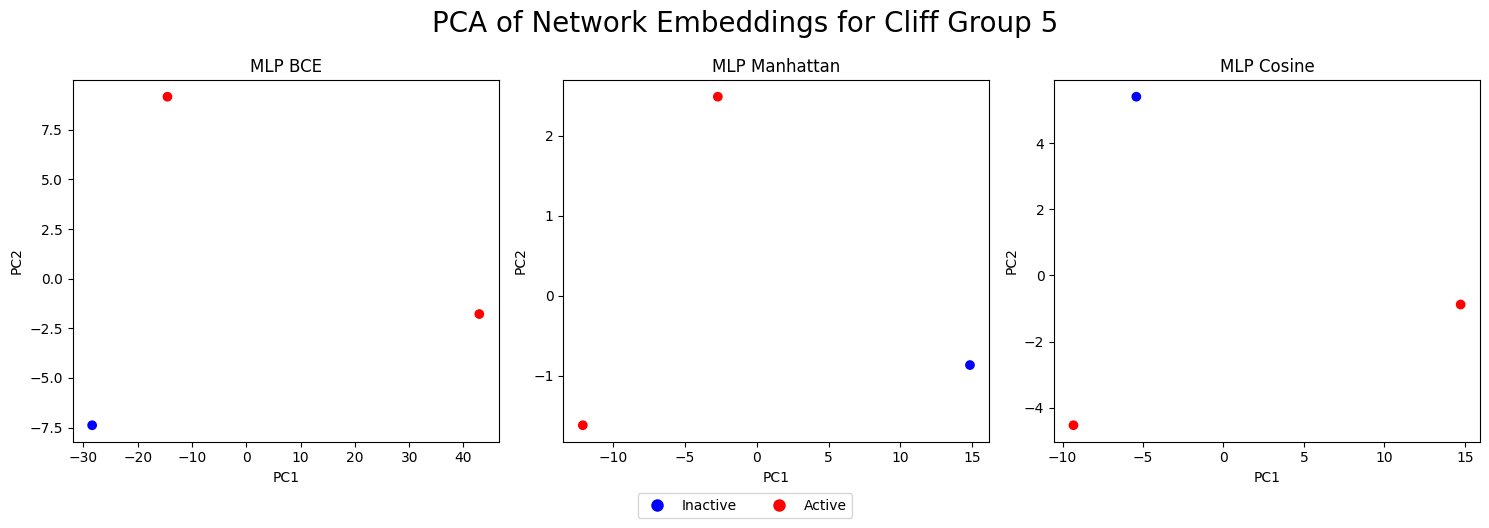

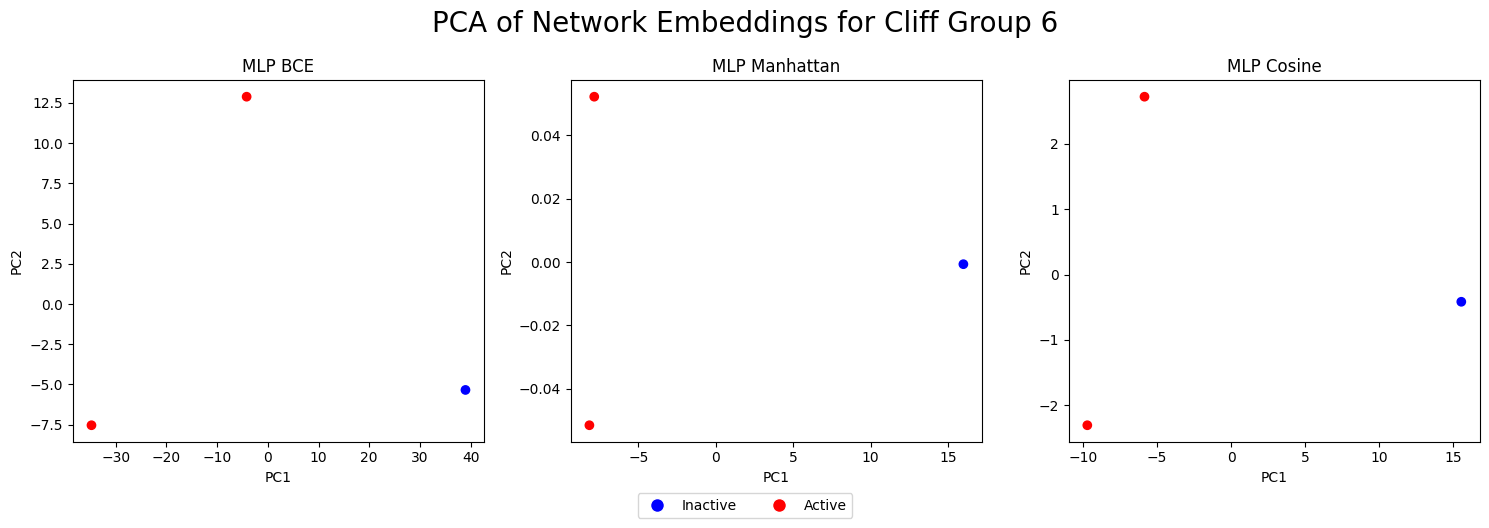

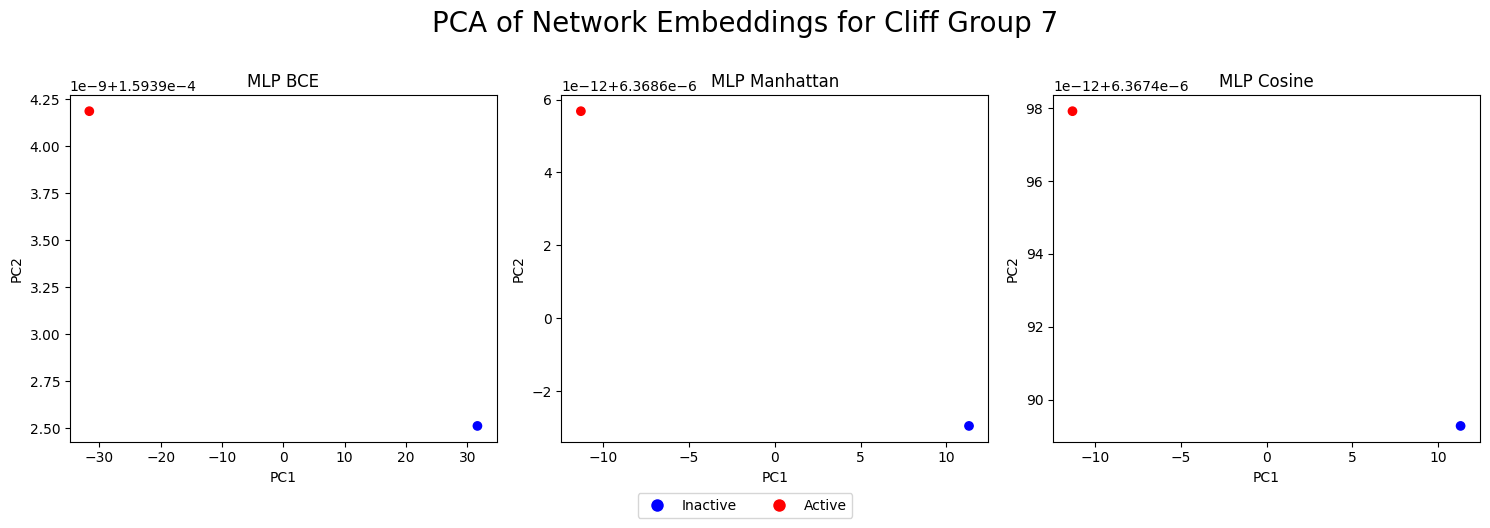

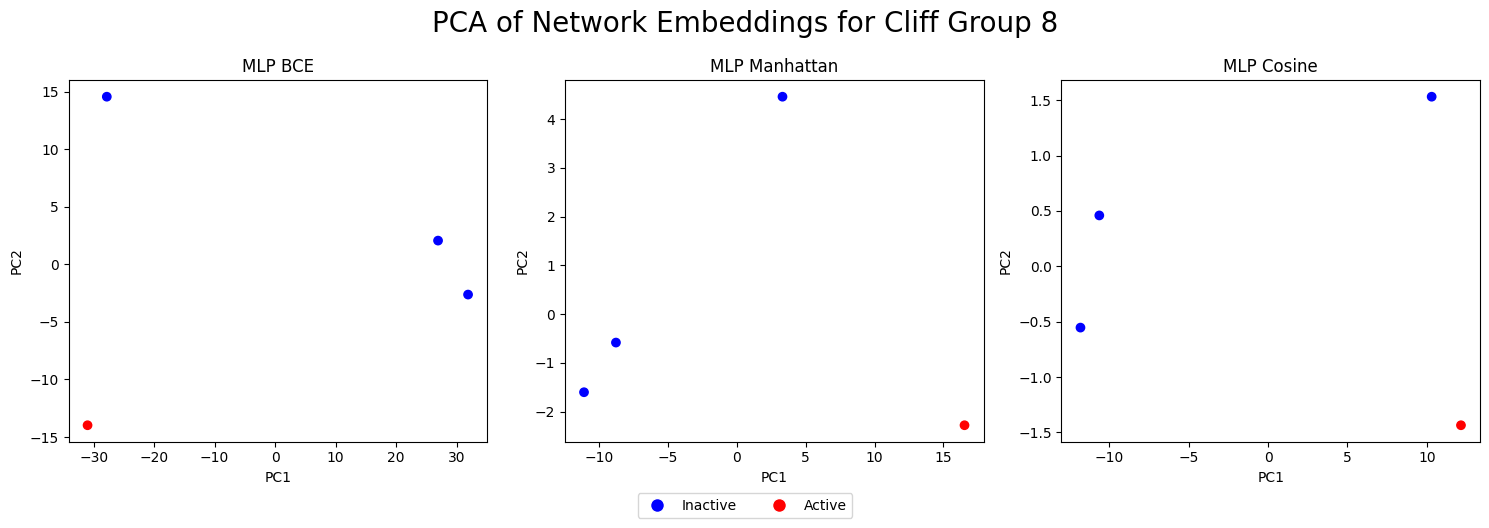

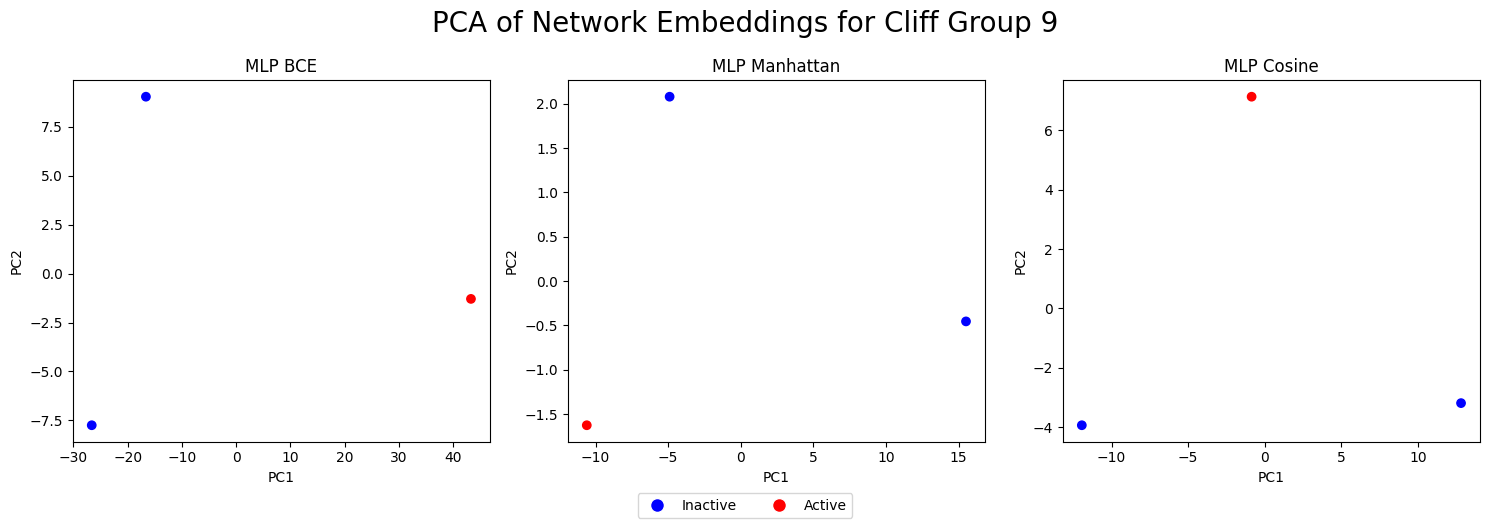

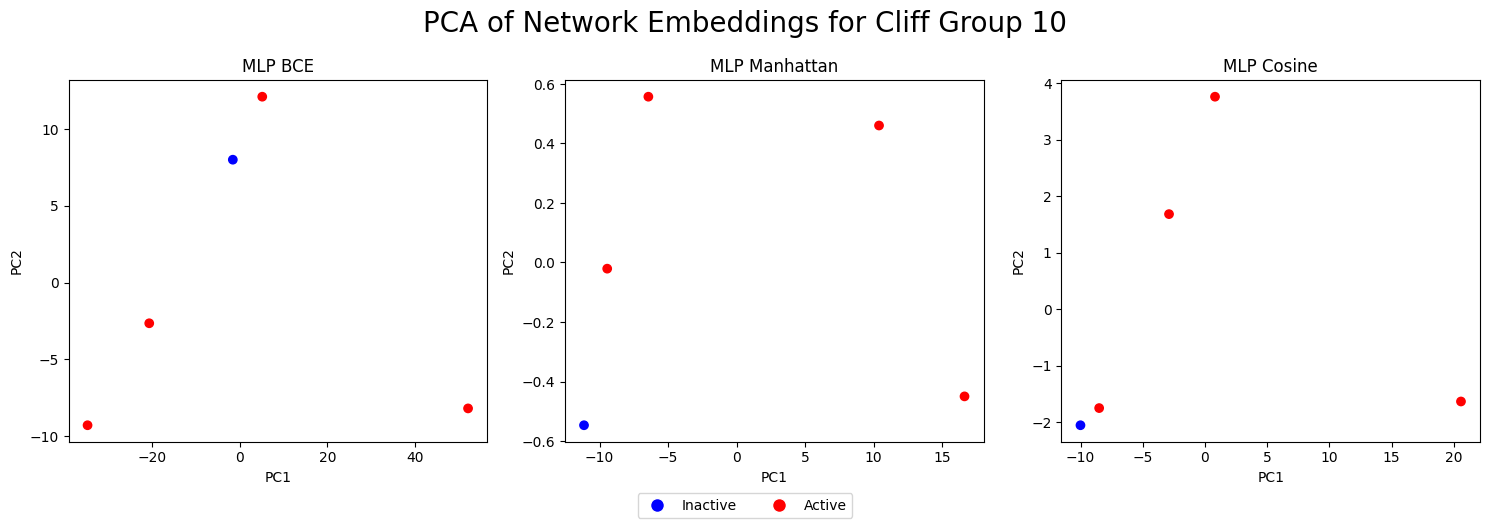

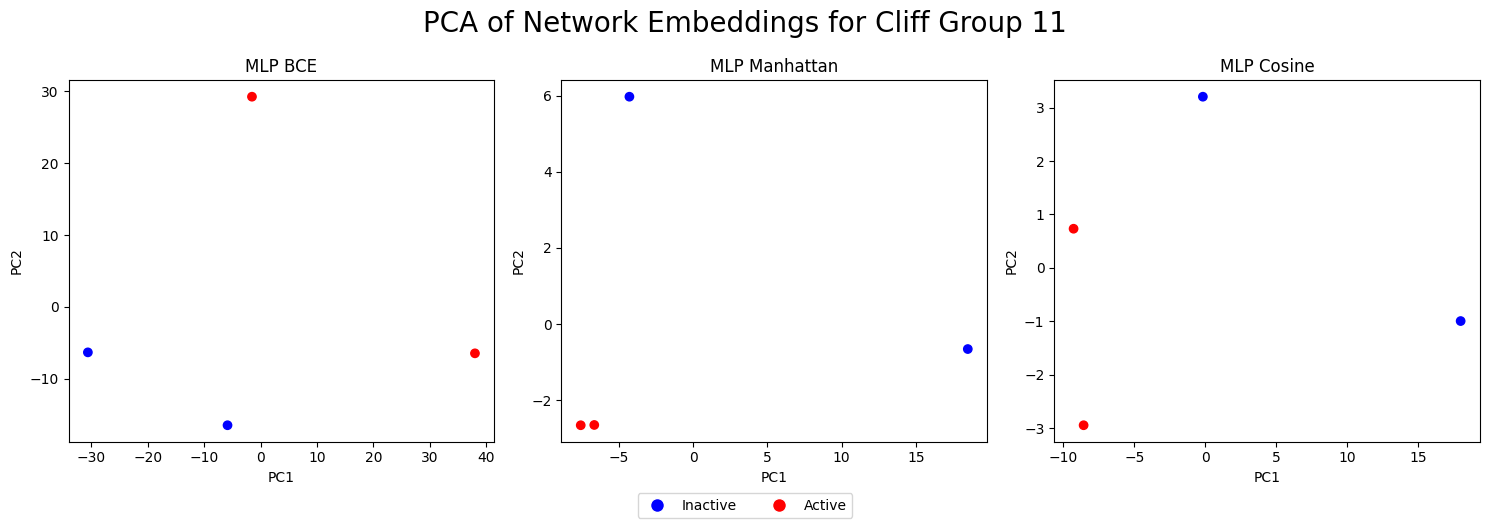

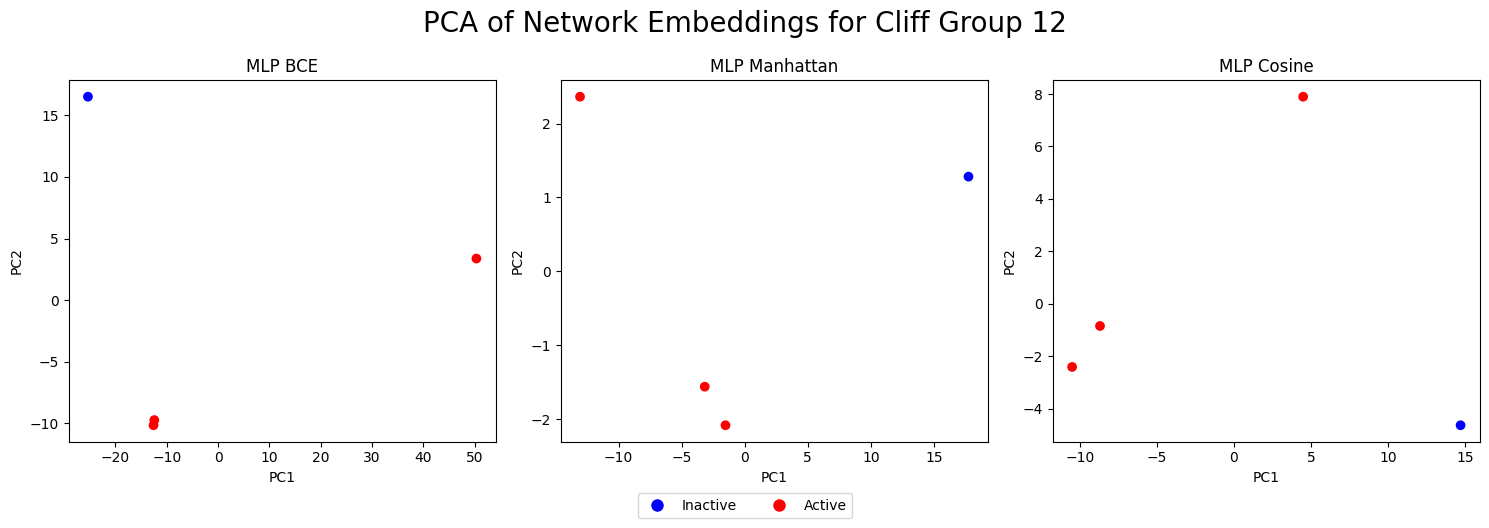

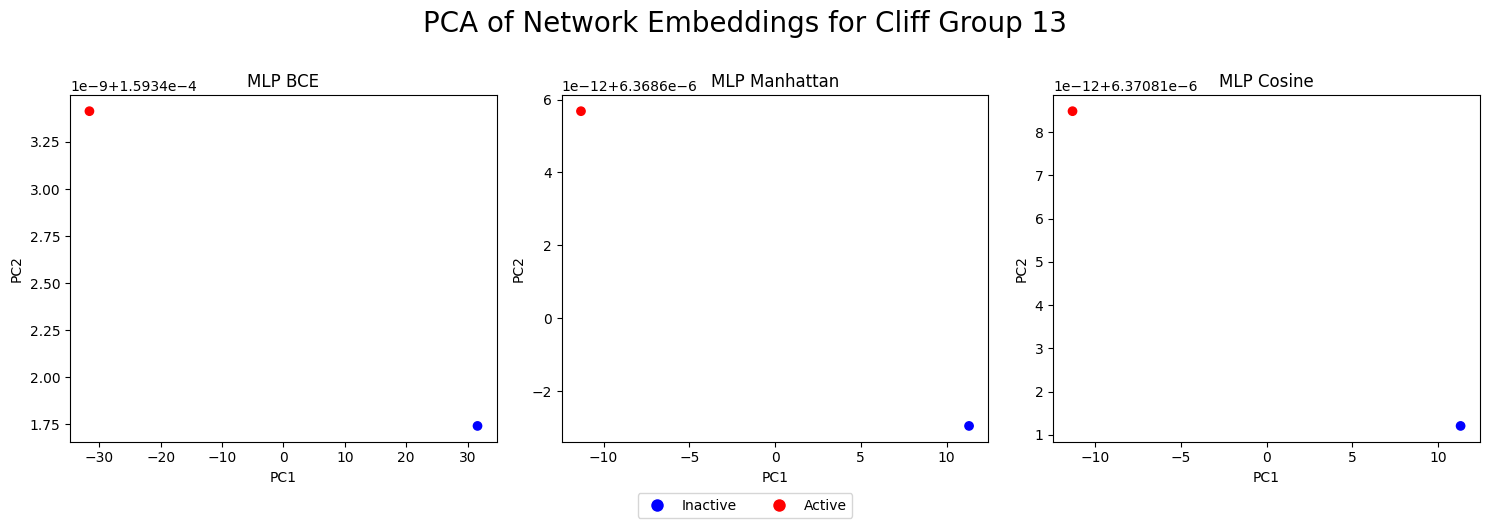

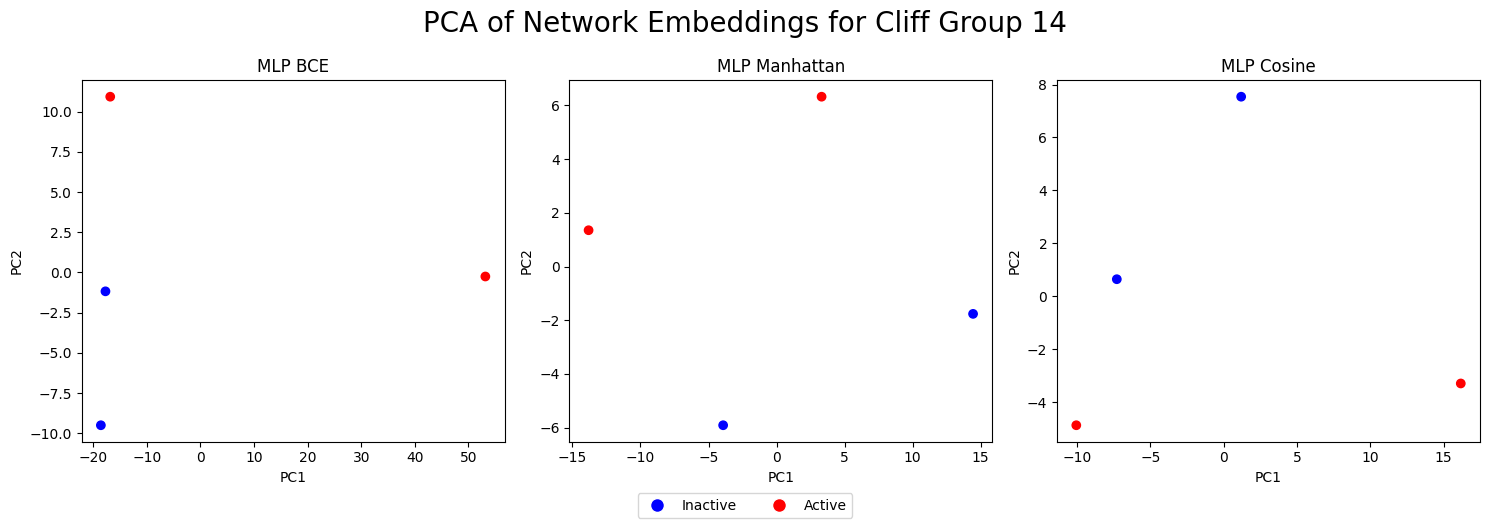

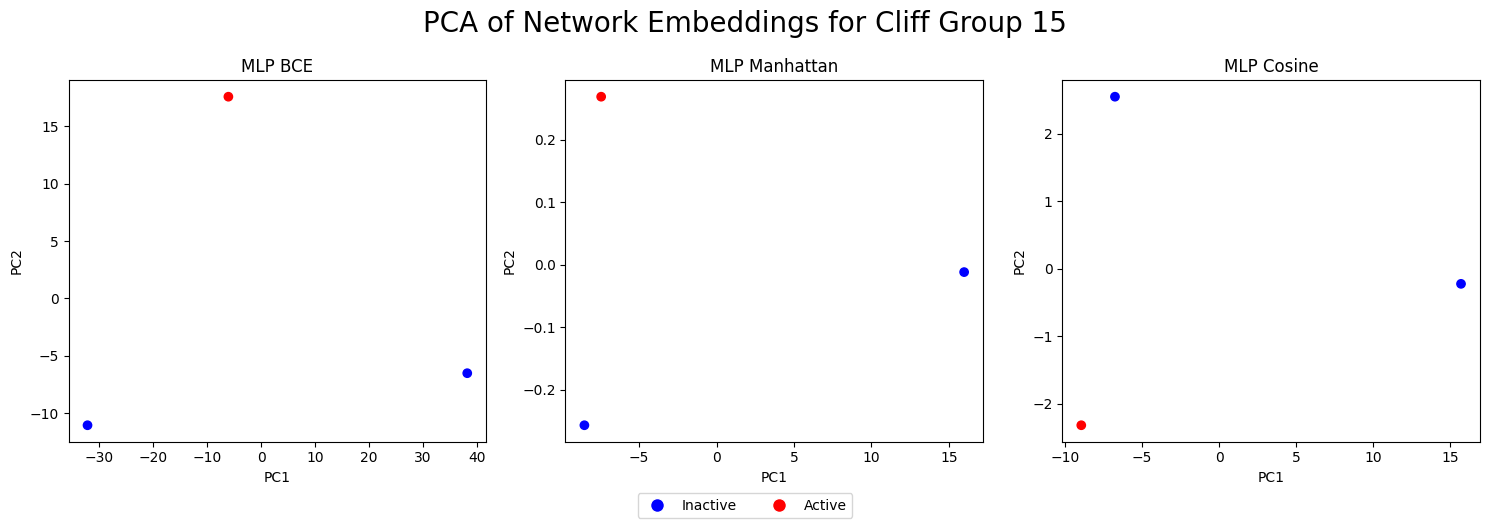

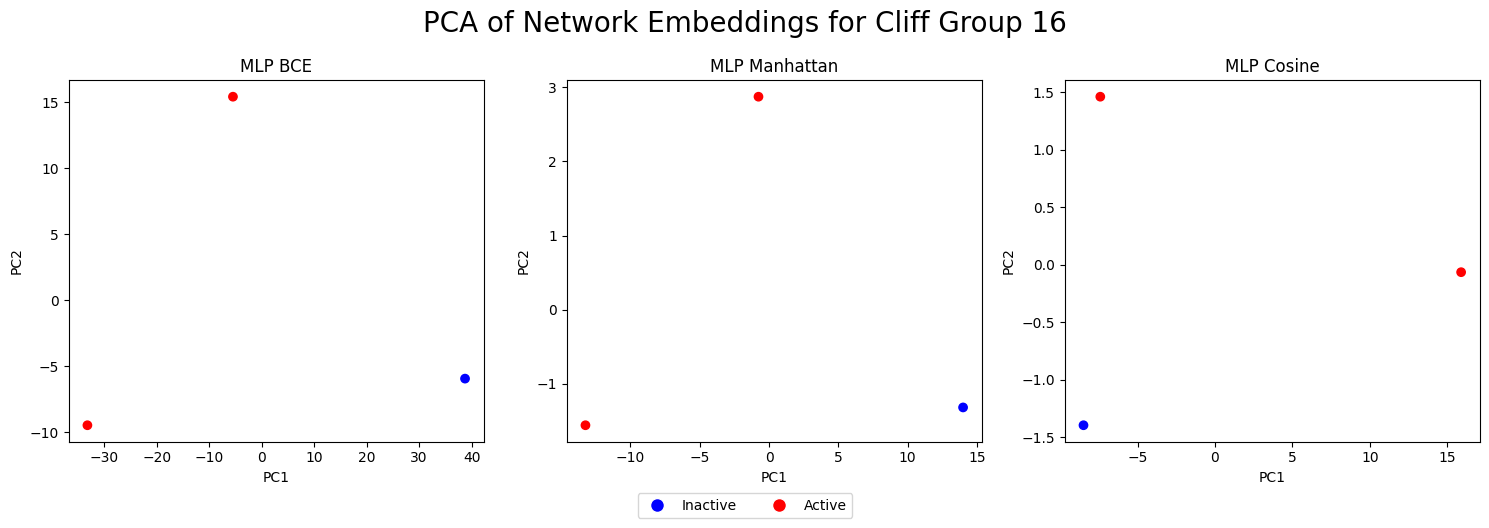

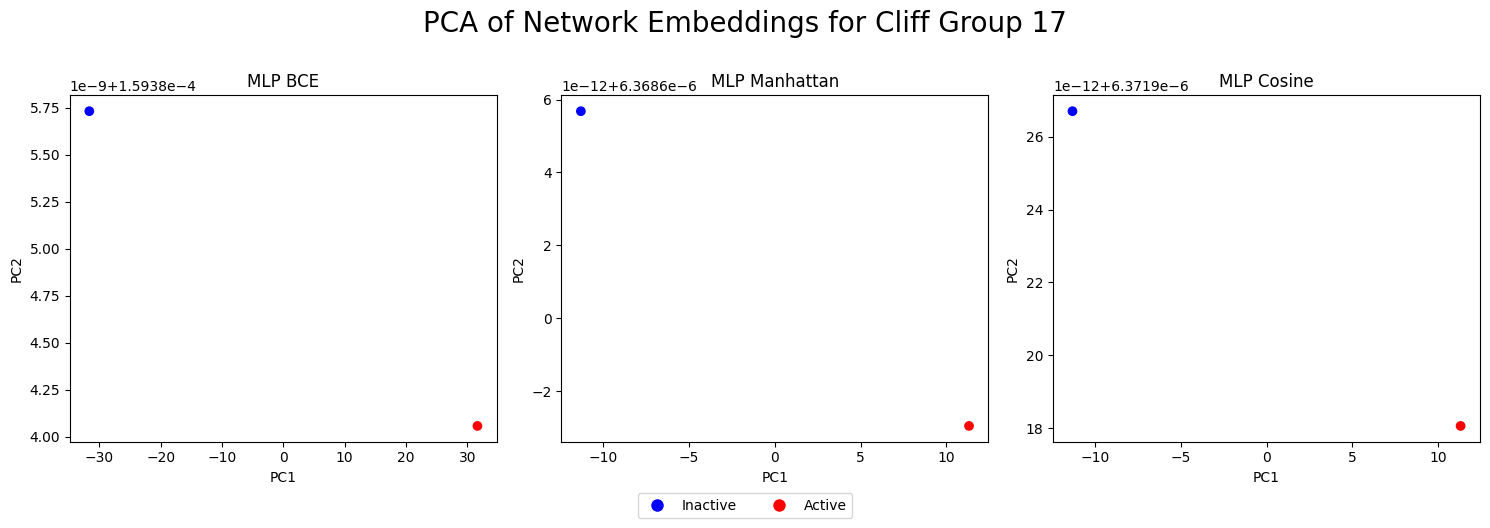

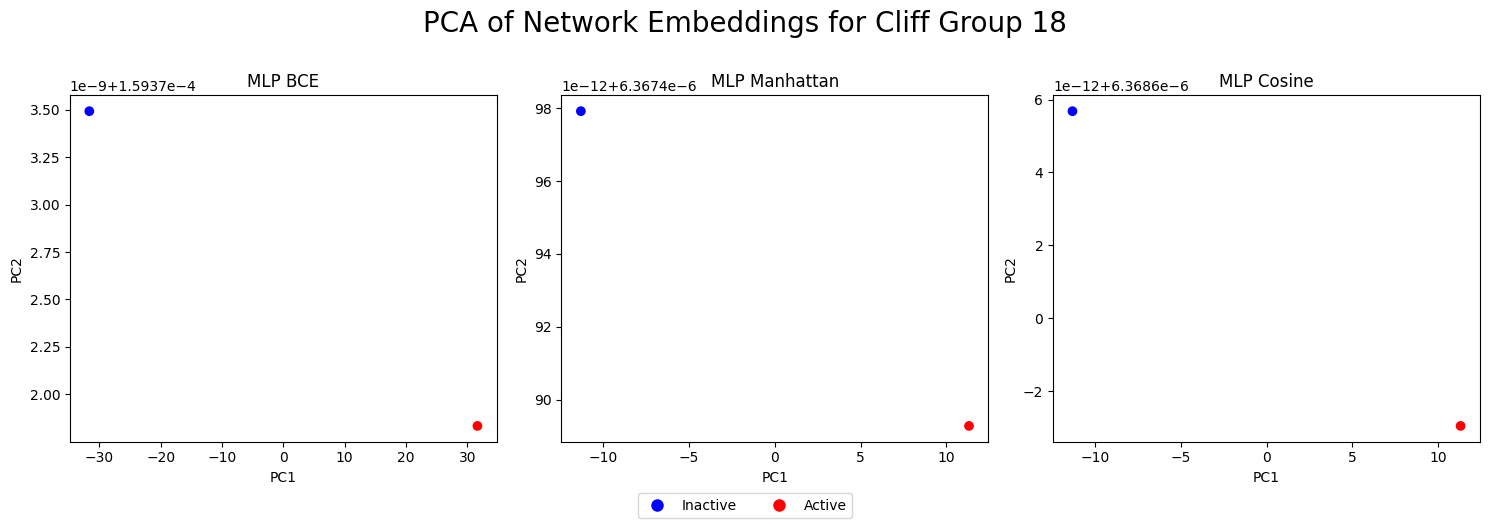

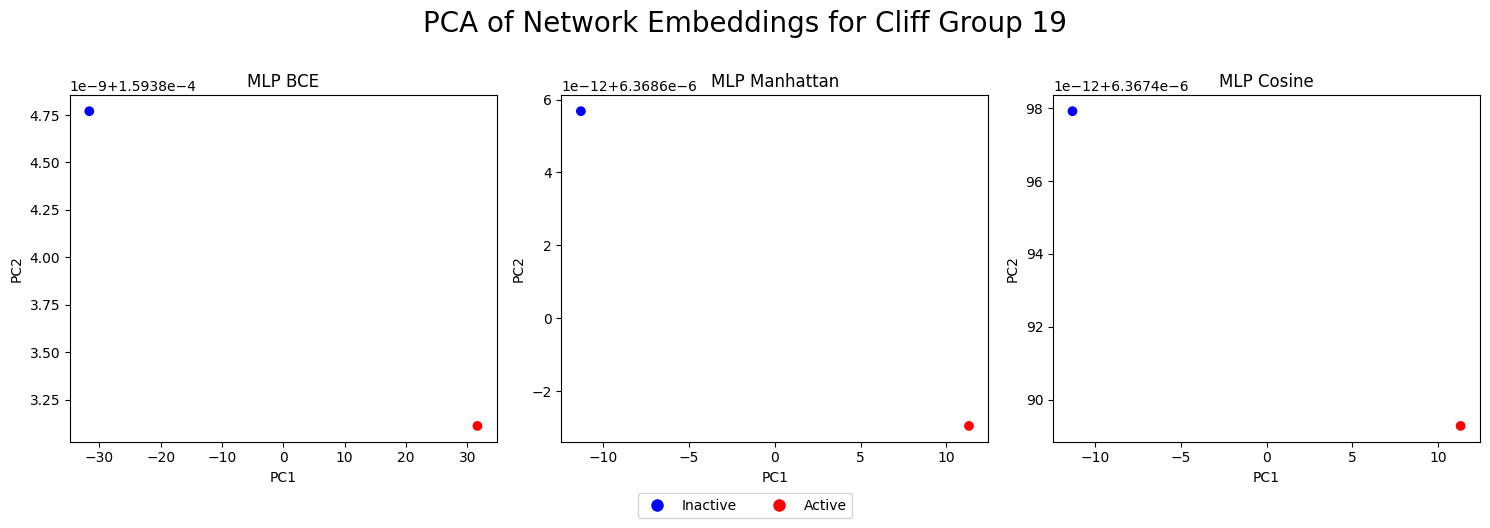

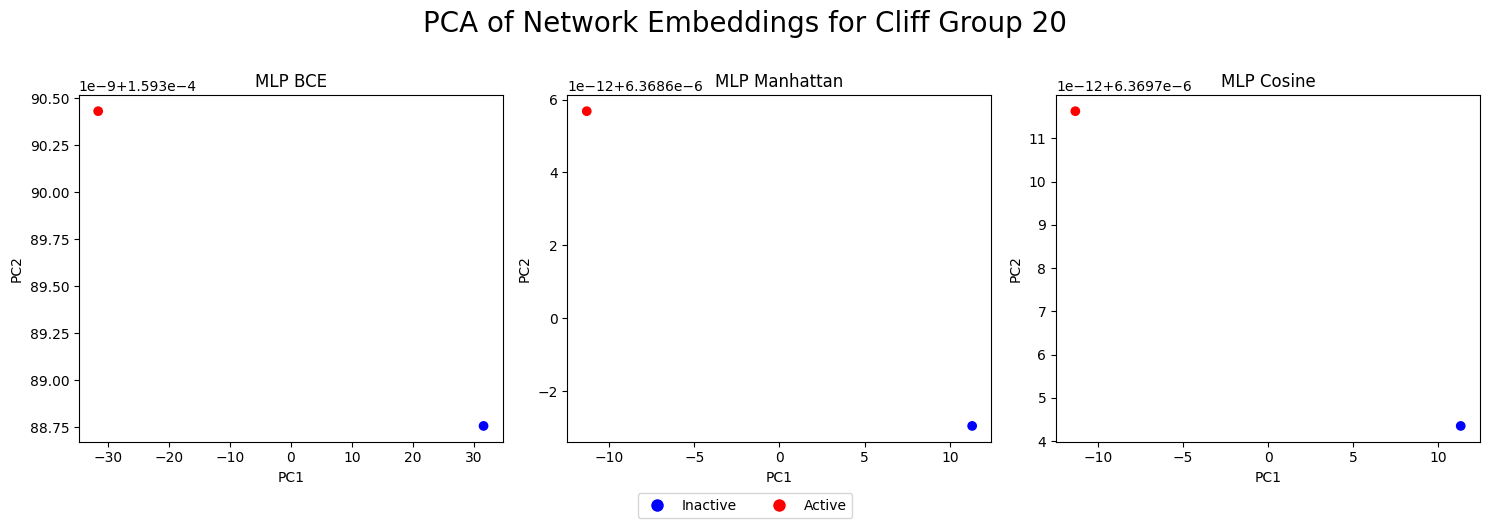

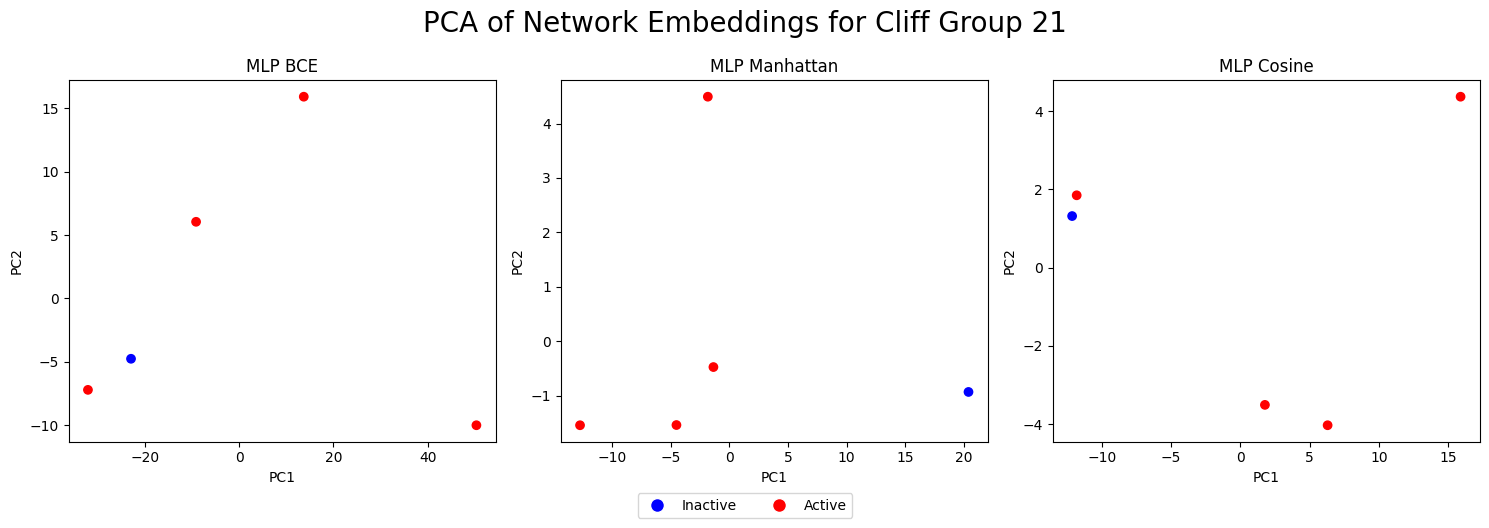

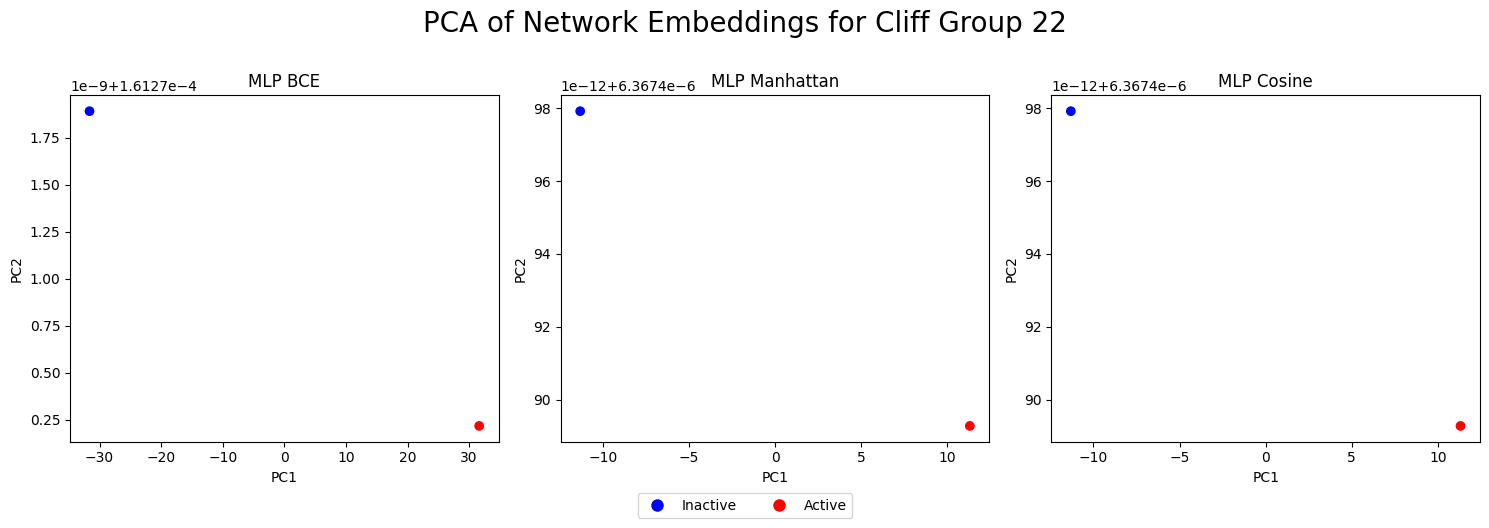

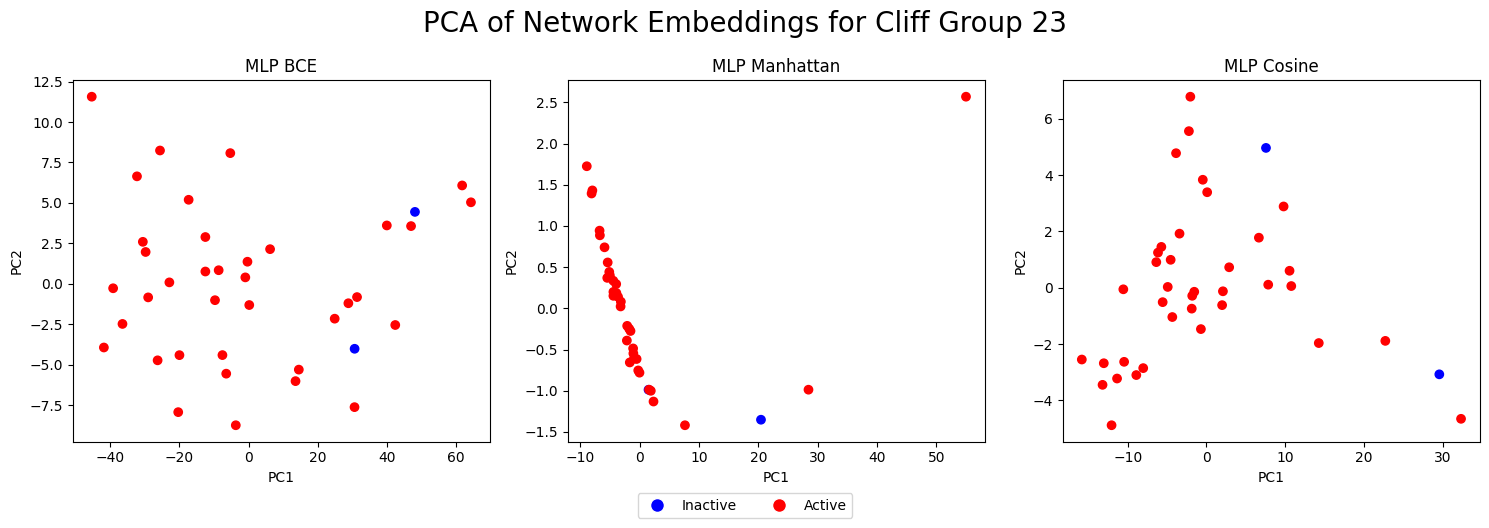

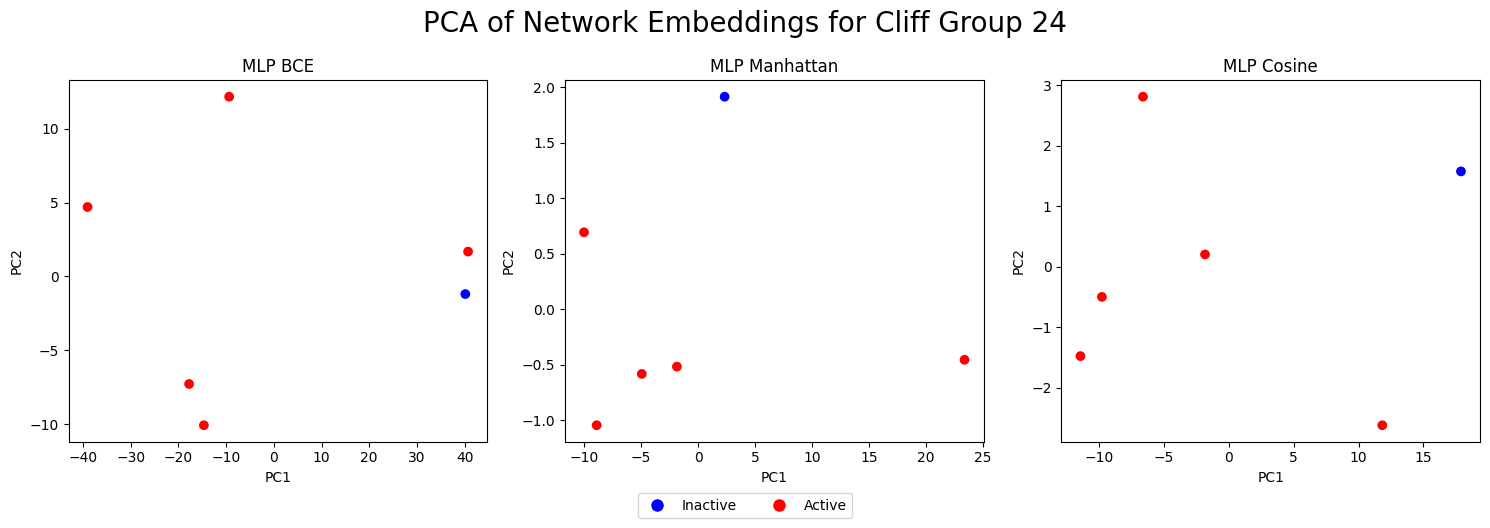

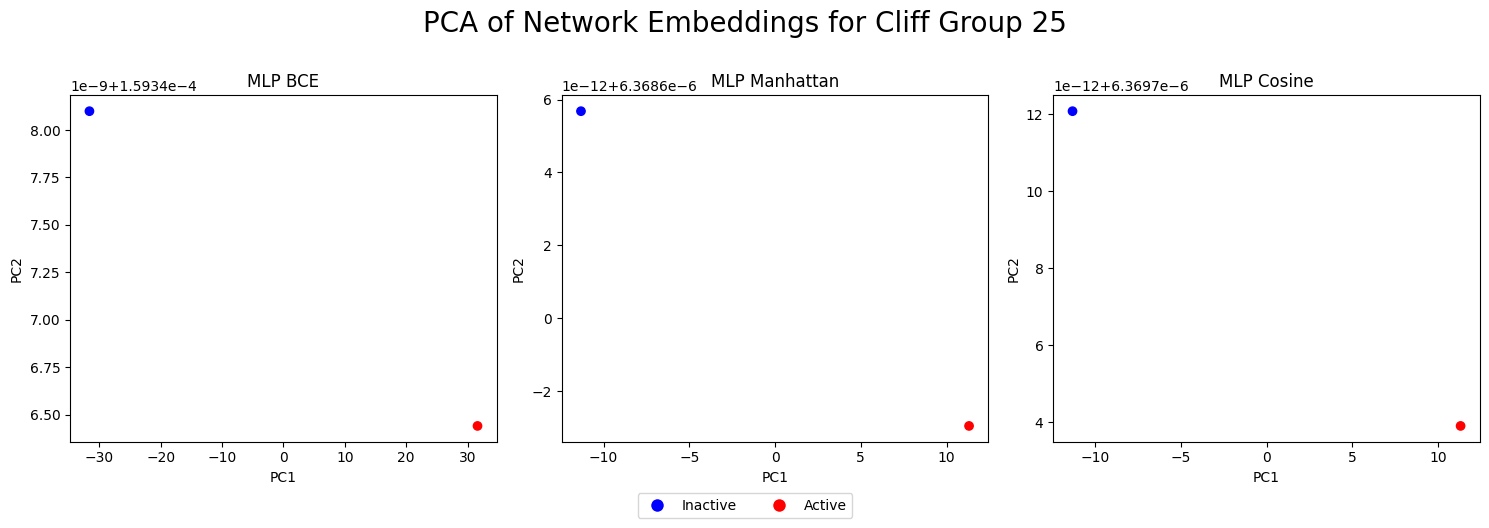

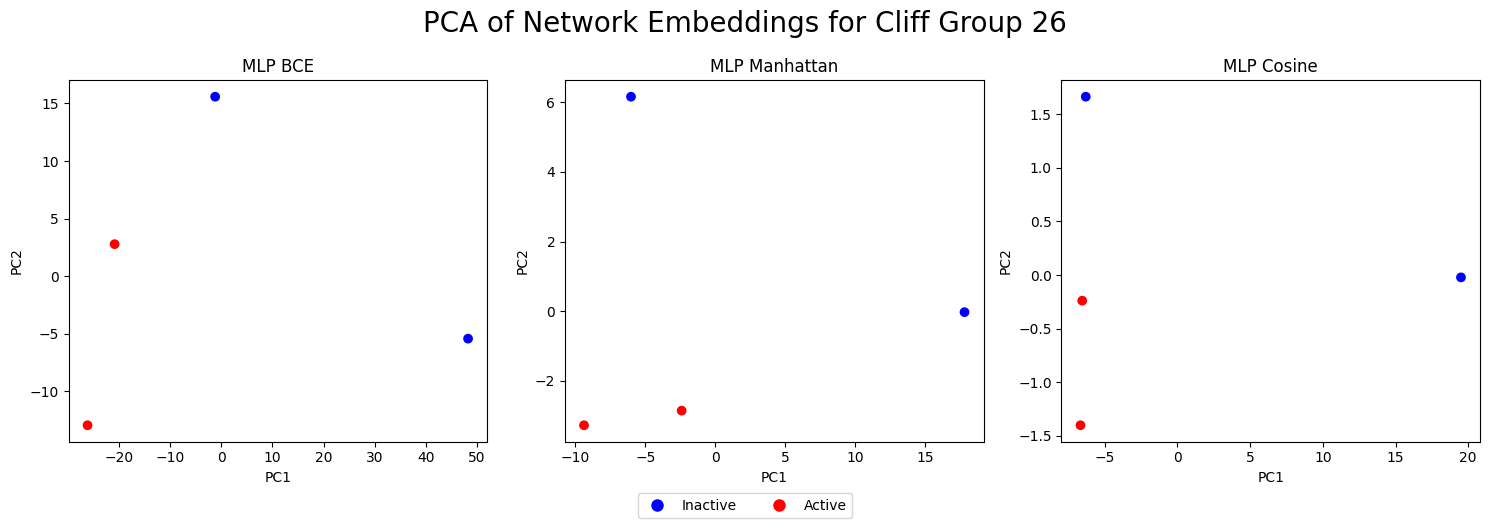

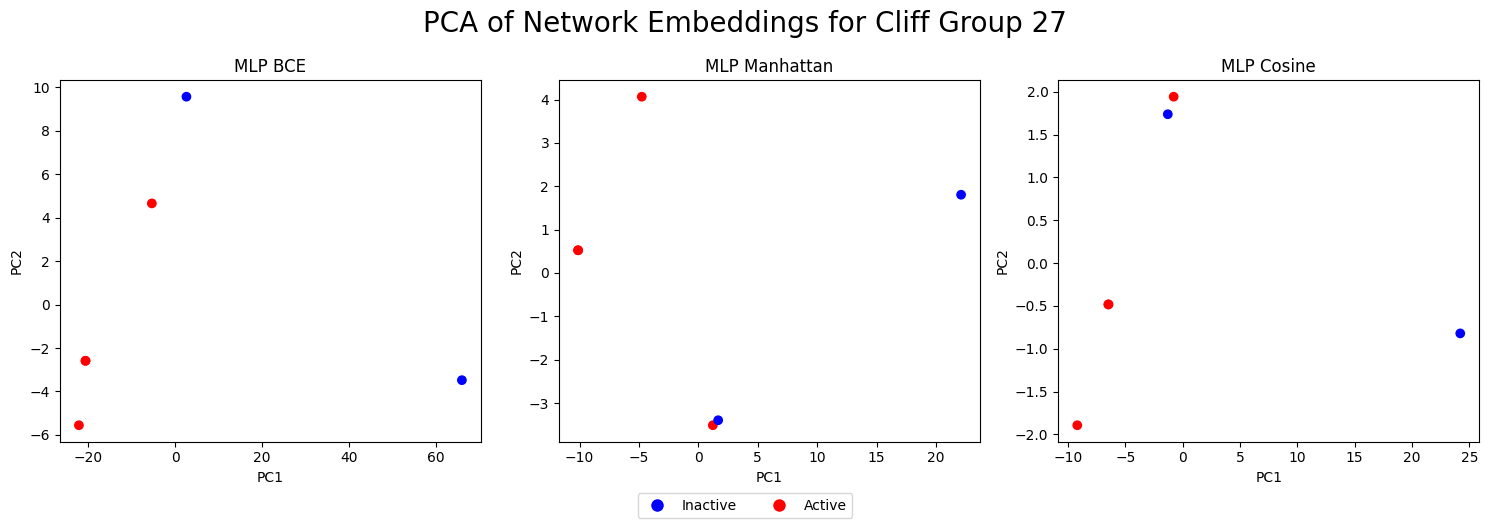

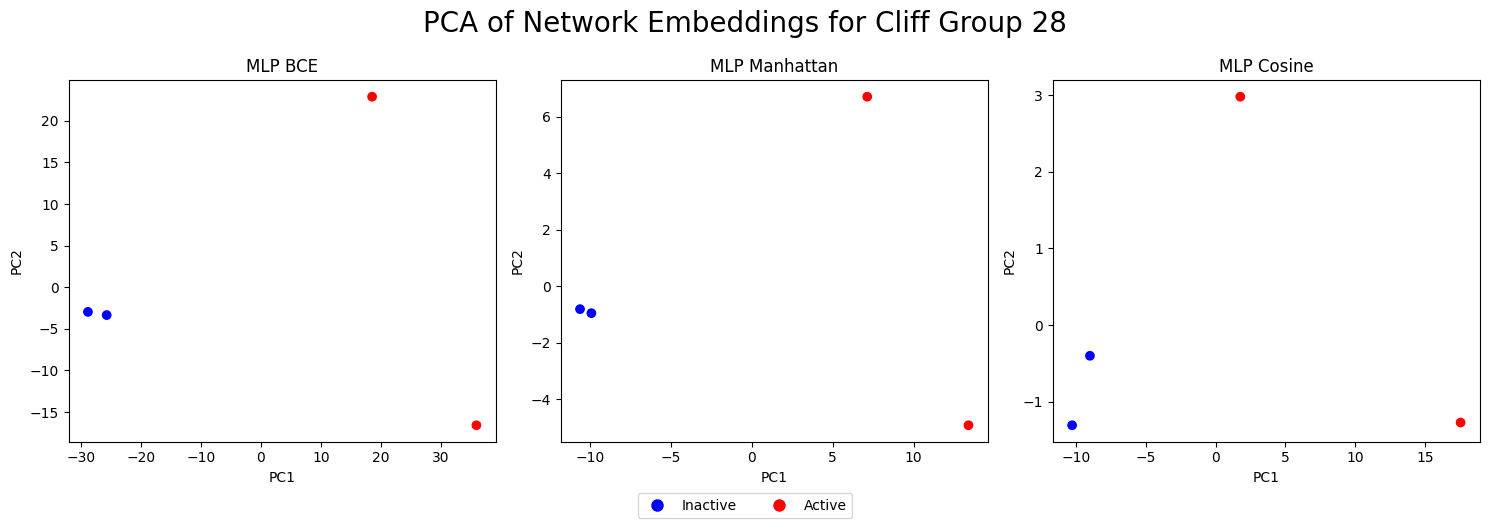

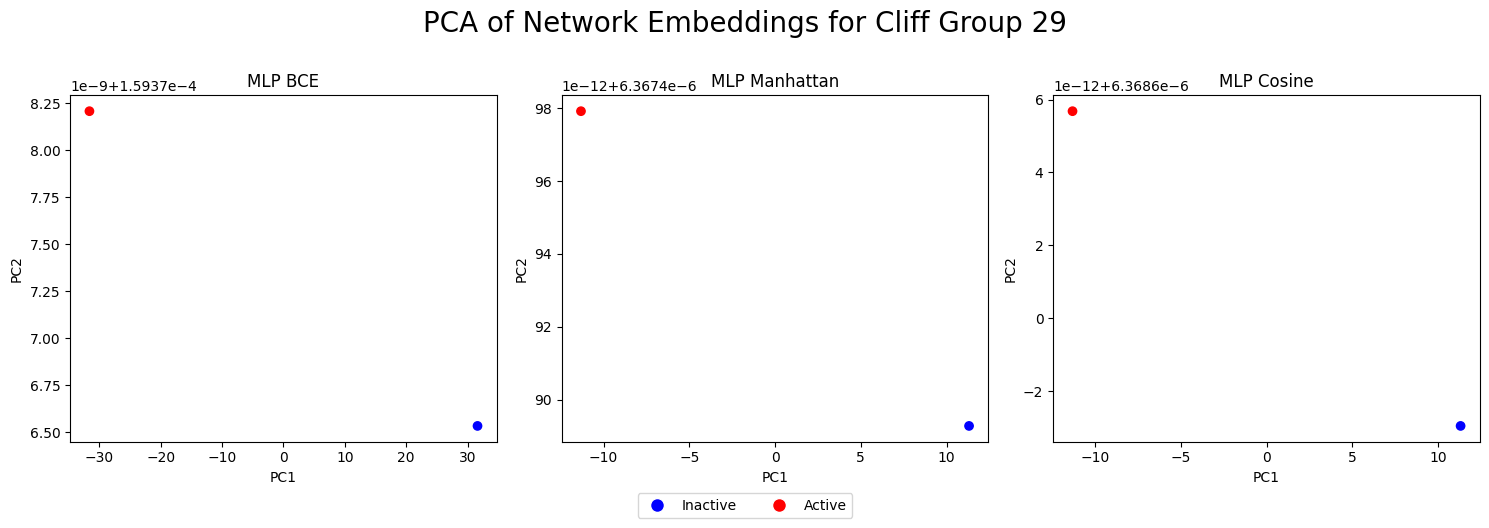

In [15]:
for i in range(len(group_dict)):
    plot_pca(group_id=i, seed=7)

In [16]:
df_test = pd.read_csv("../data/df_test.csv")
group_dict = get_cliff_groups_test(path_to_test="../data/df_test.csv")
group_map = {idx: key for key, indices in group_dict.items() for idx in indices}
df_test['cliff_group'] = df_test.index.map(group_map)
df_test['cliff_group'] = df_test['cliff_group'].fillna(-1)
df_test['cliff_group'] = df_test['cliff_group'].astype(int)

df_test.head()

smiles  exp_mean [nM]         y  \
0  O=C(NCCCN1CCN(c2cccc(Cl)c2Cl)CC1)c1cccc2c1-c1c...          36.00 -1.556303   
1  Fc1ccc(C(OC2CC3CCC(C2)N3Cc2ccc(Cl)c(Cl)c2)c2cc...         277.00 -2.442480   
2      COc1ccc(NS(=O)(=O)c2ccc(Br)cc2)cc1N1CCN(C)CC1         794.33 -2.900001   
3        Fc1ccc(C(OCCOC2CC3CCC(C2)N3)c2ccc(F)cc2)cc1        2520.00 -3.401401   
4  O=C(NCCCCCN1CCN(c2cccc(Cl)c2Cl)CC1)c1cccc2c1-c...          28.00 -1.447158   

   cliff_mol split  y [pEC50/pKi]  active  \
0          1  test       7.443697       1   
1          0  test       6.557520       0   
2          0  test       6.099999       0   
3          0  test       5.598599       0   
4          0  test       7.552842       1   

                                                ecfp  cliff_mol_binary  \
0  [-0.06217700042172756, 3.0942948523831184, -0....                 0   
1  [-0.06217700042172756, 3.0942948523831184, -0....                 0   
2  [-0.06217700042172756, -0.3231754075504108, -0...                 0   
3  [-0.06217700042172756, 3.0942948523831184, -0....                 0   
4  [-0.06217700042172756, 3.0942948523831184, -0....                 0   

  similar_molecules  cliff_group  
0               [4]           -1  
1                []           -1  
2                []           -1  
3                []           -1  
4               [0]           -1

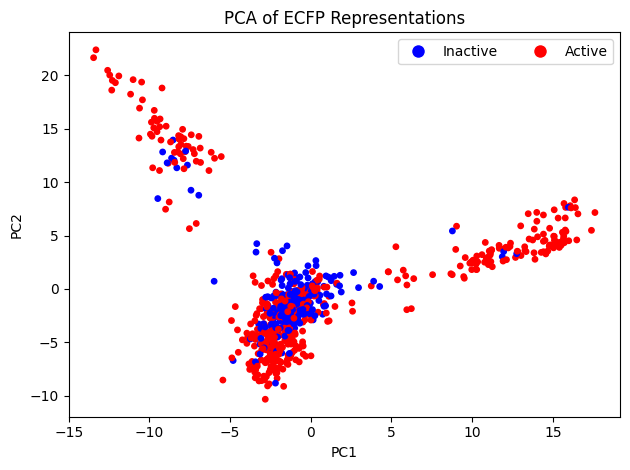

In [17]:
def str_to_array(x):
    return np.array(json.loads(x), dtype=np.float32)

class_colors = {0: 'blue', 1: 'red'}

ecfp_array = df_test["ecfp"].apply(str_to_array)
ecfp_array = np.array([np.array(elem) for elem in ecfp_array])

pca = PCA(n_components=2)
principal_components = pca.fit_transform(ecfp_array)

colors = df_test["active"].map(class_colors)

plt.scatter(principal_components[:, 0], principal_components[:, 1], c=colors, s=15)
plt.title("PCA of ECFP Representations")
plt.xlabel("PC1")
plt.ylabel("PC2")

handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=class_colors[0], markersize=10, label='Inactive'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=class_colors[1], markersize=10, label='Active')
]
plt.legend(handles=handles, loc='upper right', ncol=2)

plt.tight_layout()
plt.show()

In [18]:
def plot_pca_ecfp(df_test):

    fig, ax = plt.subplots(figsize=(10, 6))

    def str_to_array(x):
        return np.array(json.loads(x), dtype=np.float32)

    ecfp_array = df_test["ecfp"].apply(str_to_array)
    ecfp_array = np.array([np.array(elem) for elem in ecfp_array])

    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(ecfp_array)

    unique_classes = df_test["cliff_group"].unique()

    cmap = plt.get_cmap("gist_ncar", len(unique_classes))
    color_map = {cls: cmap(i) for i, cls in enumerate(unique_classes)}
    color_map = {cls: cmap(i / len(unique_classes)) for i, cls in enumerate(unique_classes)}

    colors = df_test["cliff_group"].map(color_map)

    ax.scatter(principal_components[:, 0], principal_components[:, 1], c=colors, alpha=0.4, s=15)
    ax.set_title("PCA of ECFP Representations")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

    for i, (x, y) in enumerate(principal_components):
        ax.annotate(
            str(df_test["cliff_group"].iloc[i]),  # Label
            (x, y),  # Position
            textcoords="offset points",
            xytext=(1.5, 1.5),  # Offset to avoid overlap
            fontsize=5,
            color="grey"
        )

    handles = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[cls], markersize=10, label="-1 (No Cliff)" if cls == -1 else str(cls))
        for cls in unique_classes
    ]
    legend = ax.legend(handles=handles, loc="center left", ncol=2, bbox_to_anchor=(1.02, 0.5), title="Cliff Groups")

    plt.tight_layout()
    plt.show()

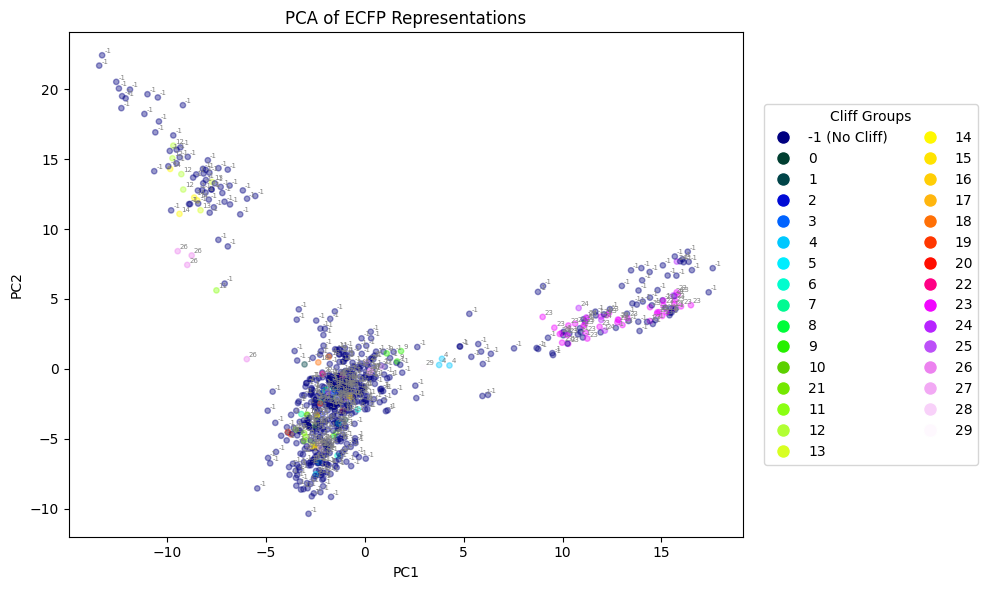

In [19]:
plot_pca_ecfp(df_test)

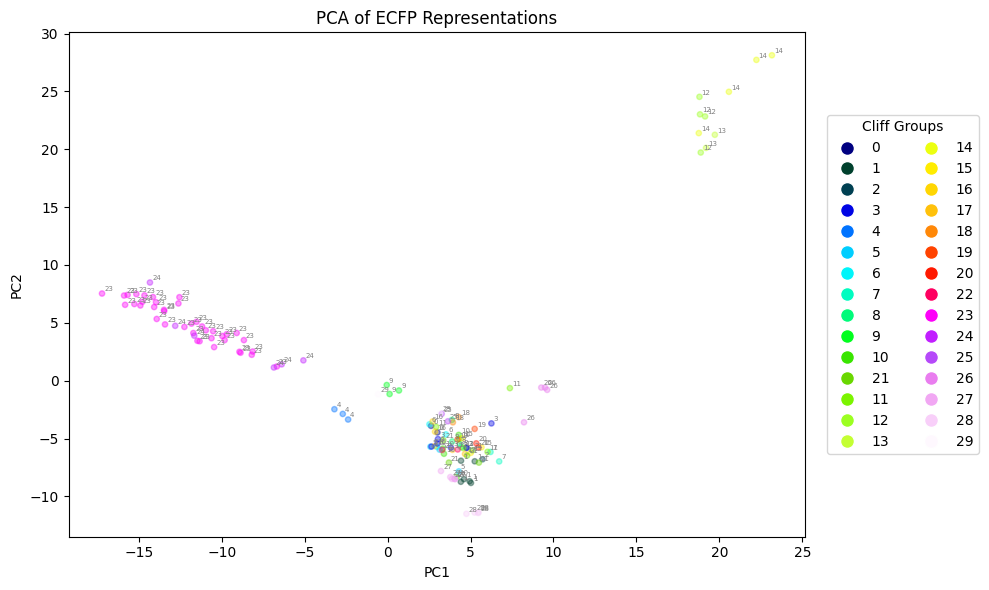

In [20]:
df_filtered = df_test[df_test["cliff_group"] != -1]

plot_pca_ecfp(df_filtered)